# T cells mapped to T2T version 2.0
# Day 6 post EP for CRISPoff and unedited
# Pipeline to Extract and Analyze mC profiles from BAM files and look at Forward & Reverse strands

Date: Sept. 7, 2025
Modify the window of the input size

Save subsets of reads

In [1]:
import sys
from pathlib import Path
from datetime import datetime

from matplotlib import pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
# import time
# import shap


# Add the folder containing 'my_functions.py' to sys.path
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))

# Import the module or specific functions
# from /home/michalula/code/epiCausality/epiCode/utils/funcs_extract_mC_profiles_from_BAMs.py
# from funcs_extract_mC_profiles_from_BAMs import system_info, extract_from_bam
from funcs_extract_mC_profiles_from_BAMs import (
    system_info,
    get_reference_sequence,
    create_output_directory,
    extract_from_bam,
    process_extracted_reads,
    visualize_data,
    create_padded_reads,
    plot_padded_reads,
    save_padded_reads,
    remove_low_methylated_reads,
    process_extracted_reads_no_fully_unmethylated,
    create_padded_reads_no_fully_unmethylated,
    subset_BAM_by_read_IDs,
    bam_to_sam,
    plot_bam_quality_metrics
    # main,
)
from funcs_analize_forward_reverse_extracted_mC_reads import analize_forward_reverse_CGs_pipeline

from funcs_check_quality_bams import get_read_info_by_index, get_read_info_by_name

modkit found with expected version 0.2.4


In [2]:
system_info()
date_today = datetime.today().strftime('%Y-%m-%d')
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta')
reg_genome_version = "t2t_v2_0"
region_chr = 'chr1'

# 6500bps: EXACT cutting region  
# chr1:206,583,334-206,589,873
region_start = 206583334    + 20
region_end = 206589874      - 20 
# CD55 TSS start: chr1:206586828-206606065 (+)
# (before TSS: 3474, after TSS: 3026 bps)

region_str = region_chr + ":" + str(region_start) + "-" + str(region_end) #'chr1:206586162-206586192'
region_length = region_end - region_start
print("region_length", region_length)


motifs=['CG,0']
ref_seq_list = get_reference_sequence(ref_genome_path, region_chr, region_start, region_end)

print('region_chr', region_chr)
print('region_start', region_start)
print('region_end', region_end)
print(f'{region_chr}:{region_start}-{region_end}') 

System: Linux
Release: 6.8.0-79-generic
Version: #79~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Aug 15 16:54:53 UTC 2
Processor: x86_64
Python version: 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]
region_length 6500
GTCATTGTATGGTTCCTGGGATAAGAGTAAGAACCGTGGTCCCTTGCTCTGTCAAAATCATAAACCTATTTTCTTTGTATTTTGACTTAATTACATAAGCTTGTTTTGGATTGGAAGGTCTATAGAGACTATTTTAGTGCCAAATGCTATTTAATCAATGCAGAAATAAGCCCTTGAGAGGTGCAGTGACTCAGCTGAGGACACACTGATAGTTTCTGGTAGATAAGTATGAAGCCTTGGAACTACTTCTCATATCATAAGCCCCTGGGTTCCCAAATCACCTCCCCAAGTACCTAATTCATCATCCTCTGCATACAAGAAATTTTTGCTCATTCCAATAAAAAGAATGTAGTACGGCAGGACAGGAGAAGTACAGGTTTTGGAATCAAACTAGGTTTAGATTCTGACCTGGTCGCTAGTTAGTGCATGGGCTTTGGTAAACAGCCTCTCAGCCTGTTTCCTTGTCTGCAAAATATGGATAGTTATCTTCACTTCATGAAGTTGTGTTGGTGAAATGGTATAATGTGTATAAAGCAACTGGAACACAACAAATGAGGCCATTTATTTAAAATAATCTTTAGTAAGTTATAAATTCACATATTTGCTTTTTTCTGAGGAATGCTTAGATTTTATCATAGATCTCTTTTCTAAATTGAGTAAATACATAGTGGATTTCTTTGTTTCCTTCCCCTCAGAATGTTGAAATTTGGCTGATTGTAACTATTACTTAAGACTCTATCCAGTAATTGTTCGTA

# Look at Cas9 T cells at day 6 post EP  



In [3]:
day_num = 28
day_num

28

In [4]:
output_dir_path = '/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output'
# '/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/croff/analyze_single_reads/output/' # "/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/"
output_dir_path


'/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output'

In [5]:
original_bam_path = "/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_CROFF_Day28/mergered_outputs/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20250721_Day28_CROFF_T_cells_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"

original_bam_path

'/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_CROFF_Day28/mergered_outputs/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20250721_Day28_CROFF_T_cells_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam'

experiment_name =  day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2
Region length: 6500
No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.7 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in up_chm13v2.0.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_t2t_v2_0_trim_20250721_Day28_CROFF_T_cells_minion_merged_flowc…

          |    0%

          | Transferring 28 from reads.CG,0.txt into reads.combined_basemods.h5, new size 28   0% | 00:00<?

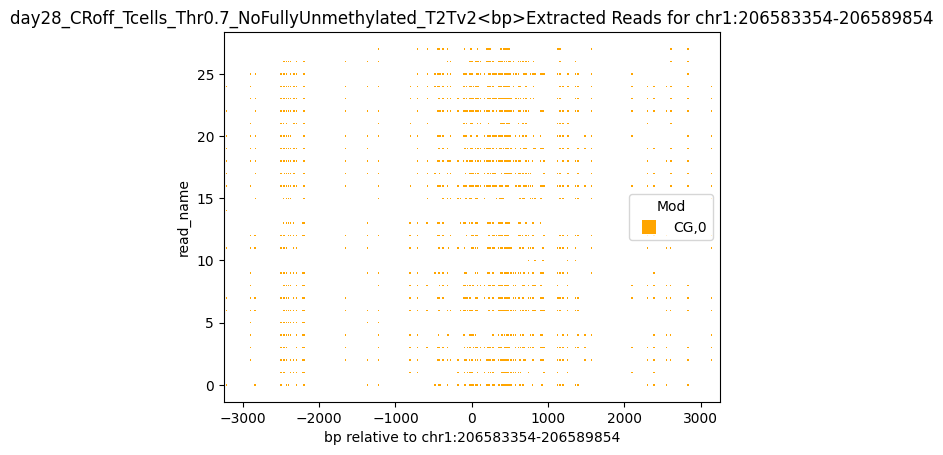

Found read coordinates: 28 reads
Unique read names with methylation: 28
In function count_indels_and_mismatches: Processing region is chr1:206583354-206589854
In function count_indels_and_mismatches: Region length is 6500
Found 13 reads with full coverage
Reads with methylation data: 28
Overlap between full coverage and methylation: 13
After full coverage filtering: 13 reads with methylation data
After removing reads with <90.0% threshold_fraction_overlap_aligned: 12 reads with methylation data
After removing reads with >70.0% threshold_fraction_mismatches: 12 reads with methylation data
After removing reads with >60 threshold_mapping_qualities: 12 reads with methylation data
After removing reads with >20 threshold_avg_base_qualities: 11 reads with methylation data
Final result: 798 reads with methylation information out of 28 total reads
Subset BAM written to: dimelo_v2_output/filtered_reads_overlap_MORE_than_0.9_day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam
Index written to

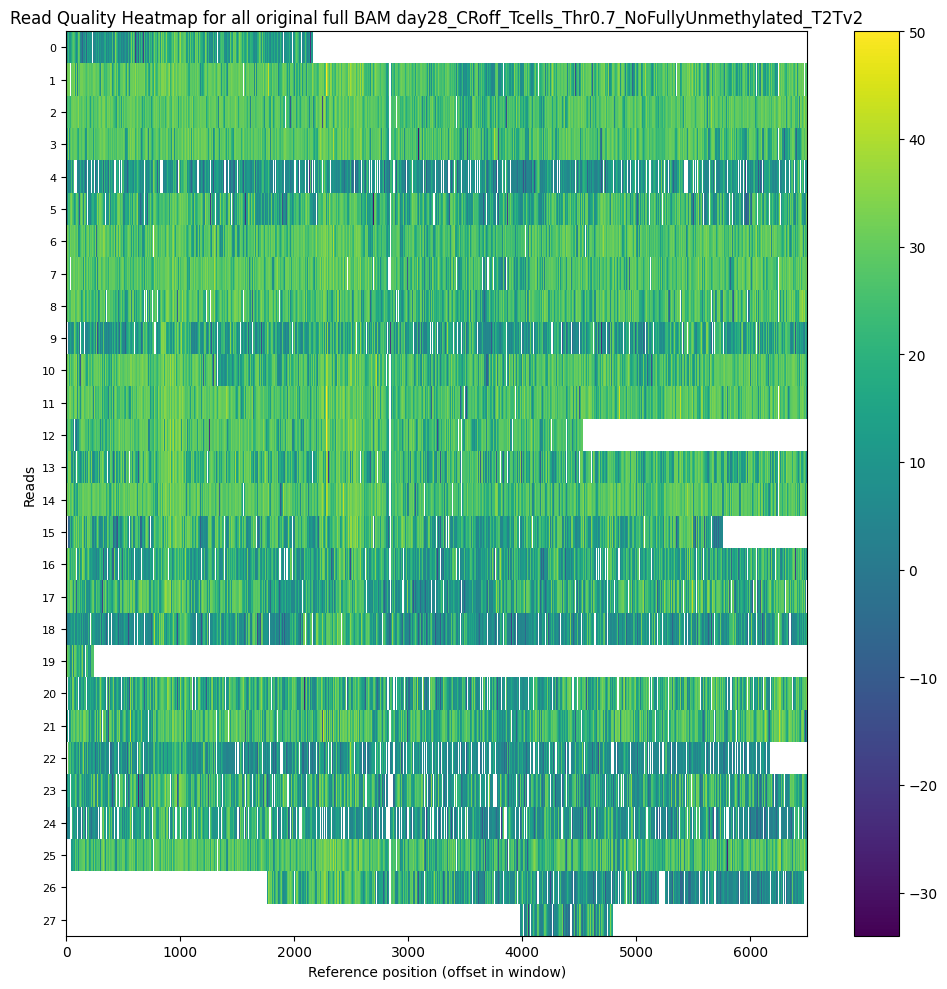

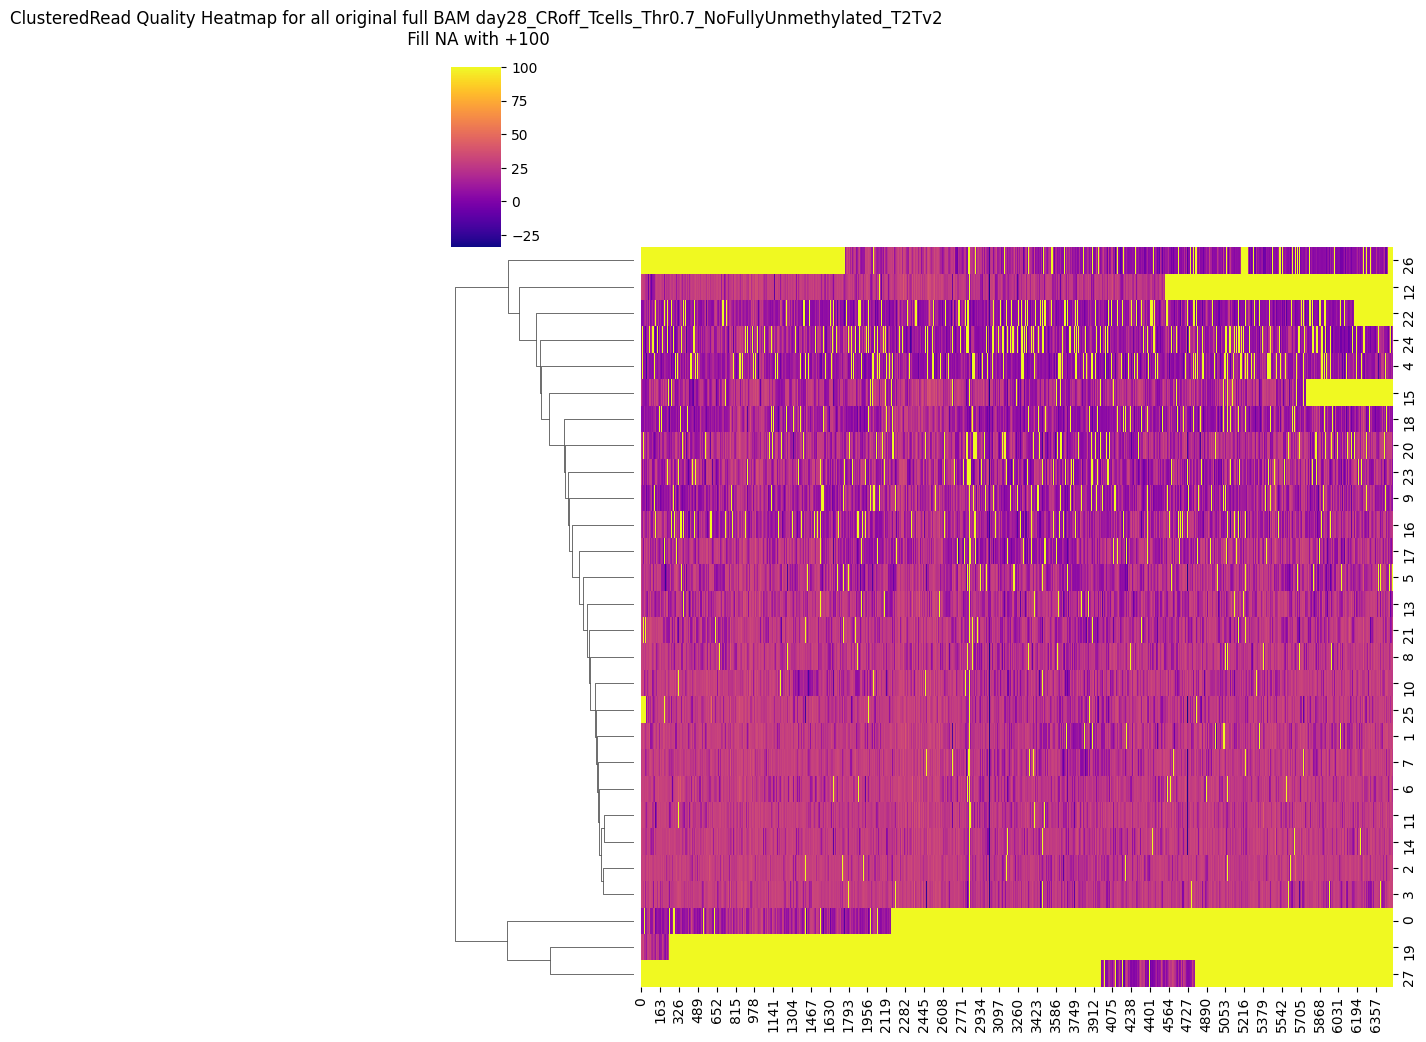

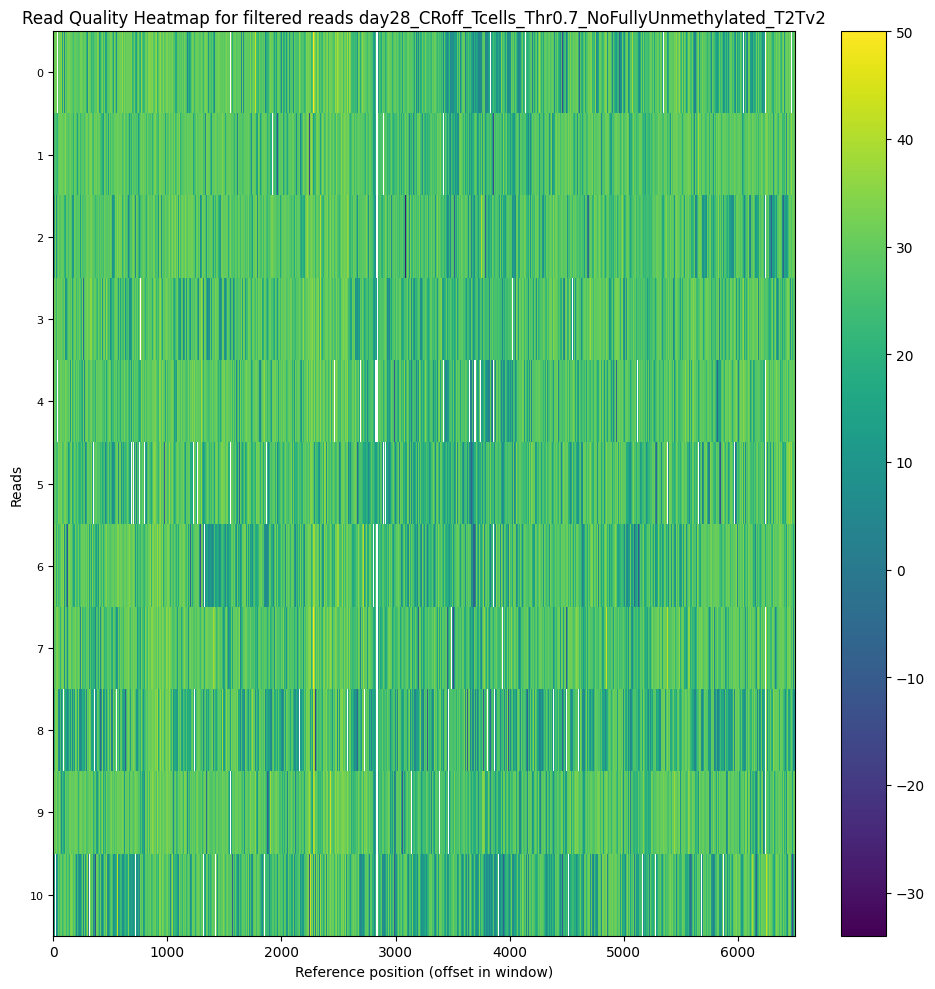

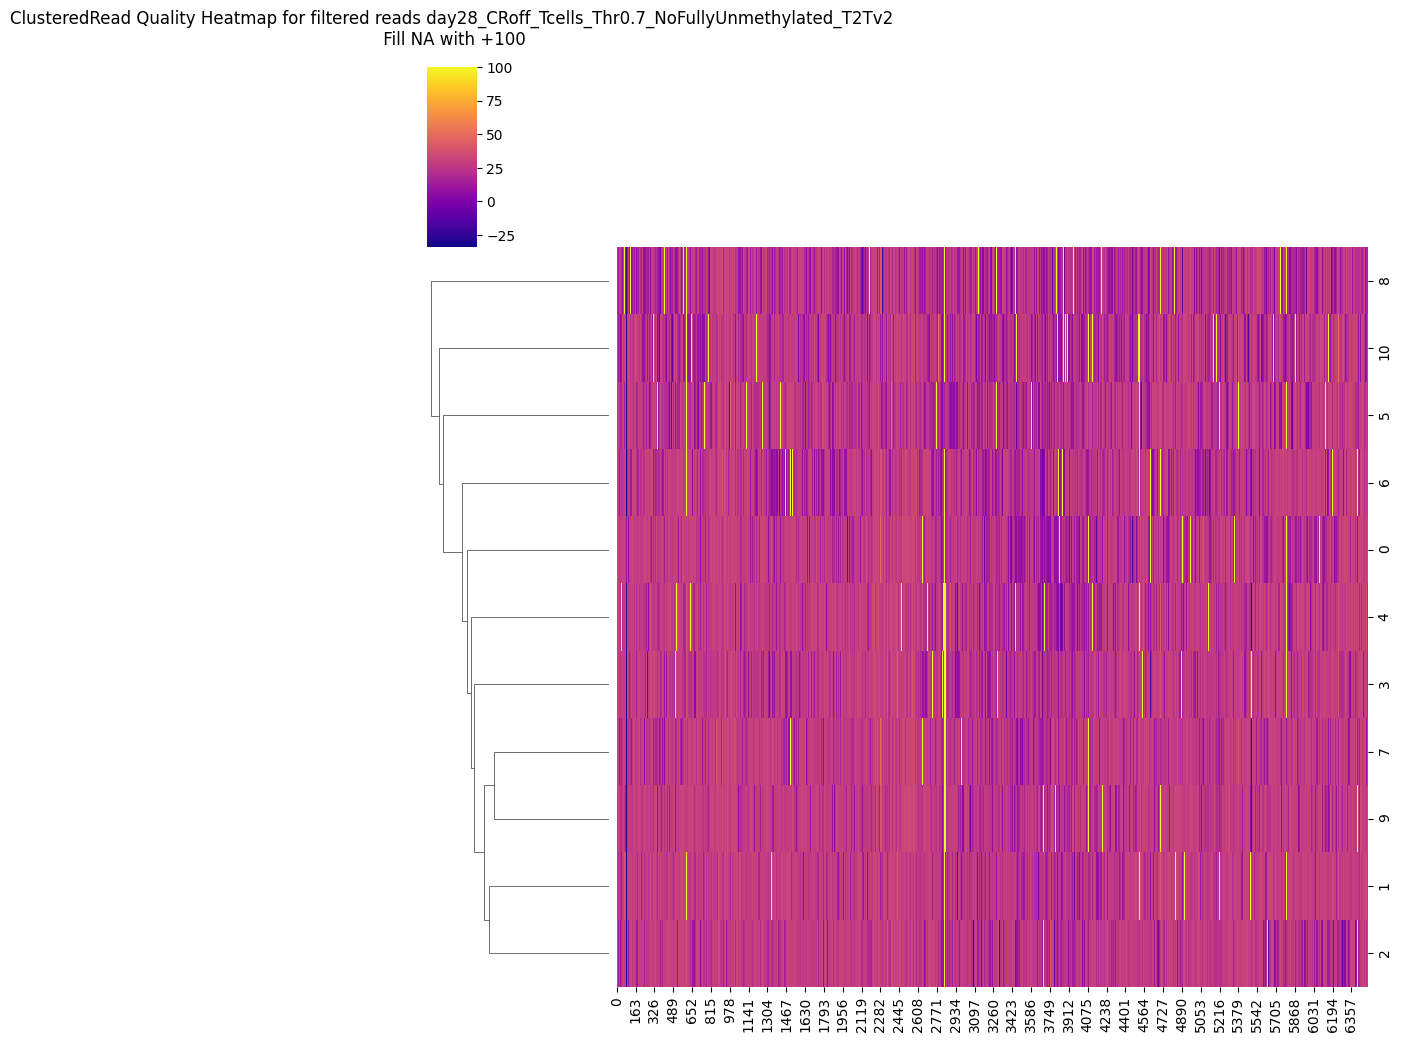

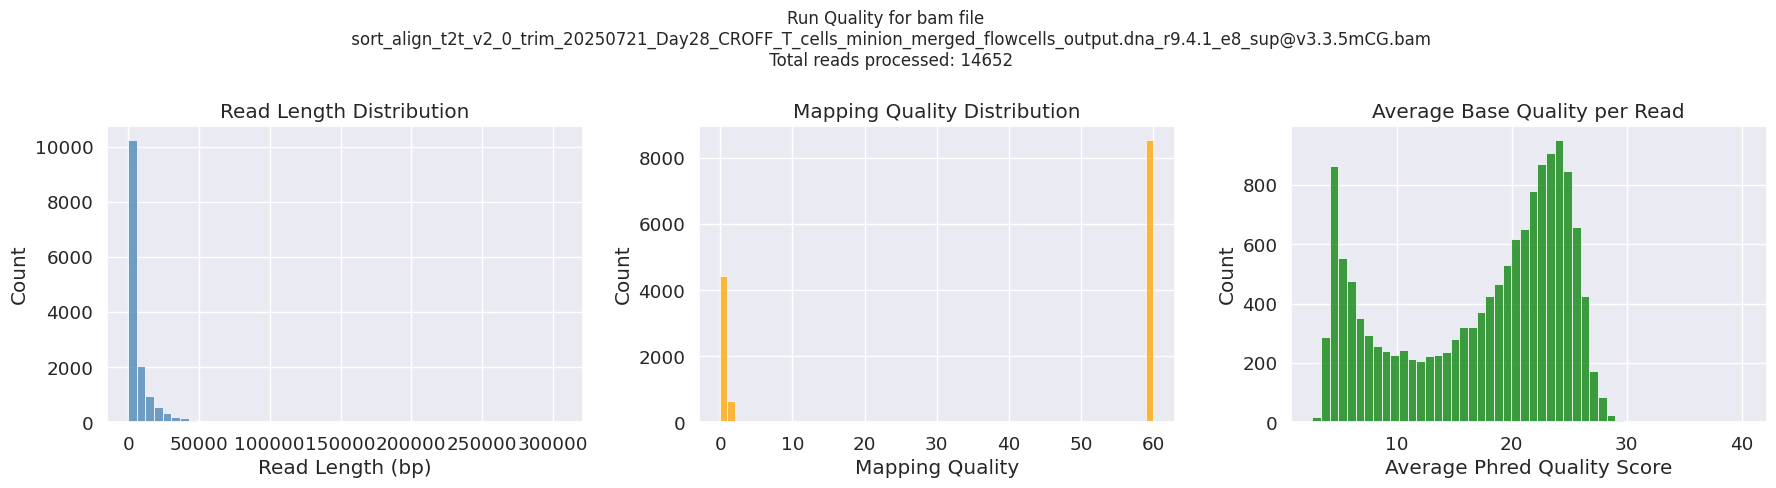

Total reads processed: 14652


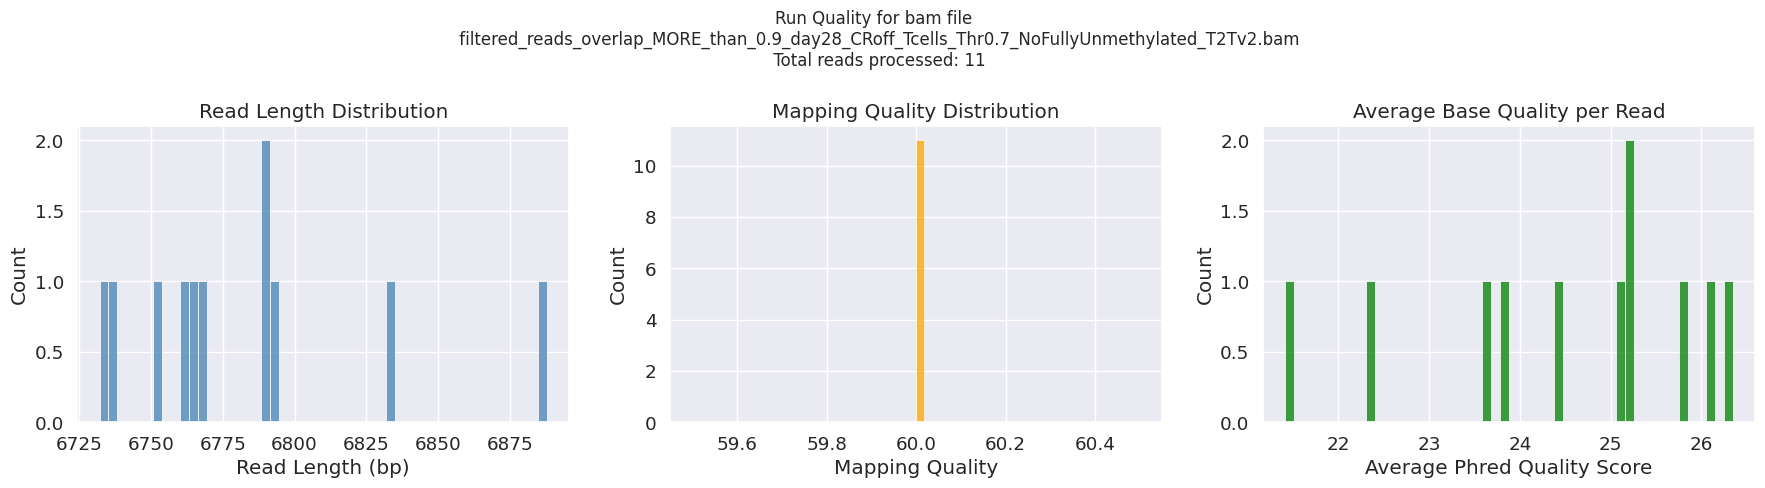

Total reads processed: 11


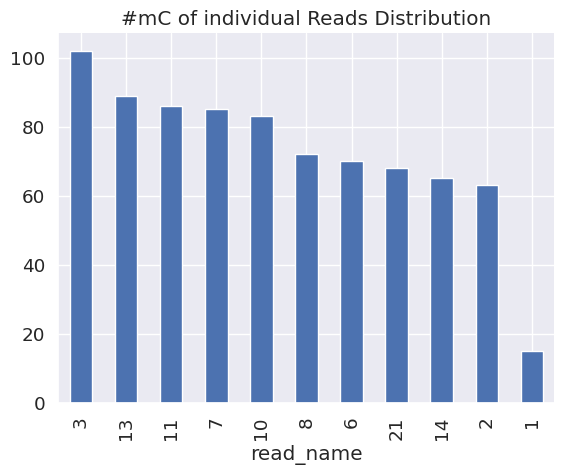

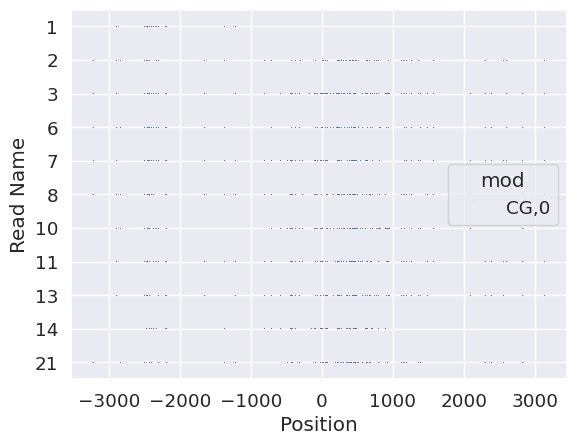

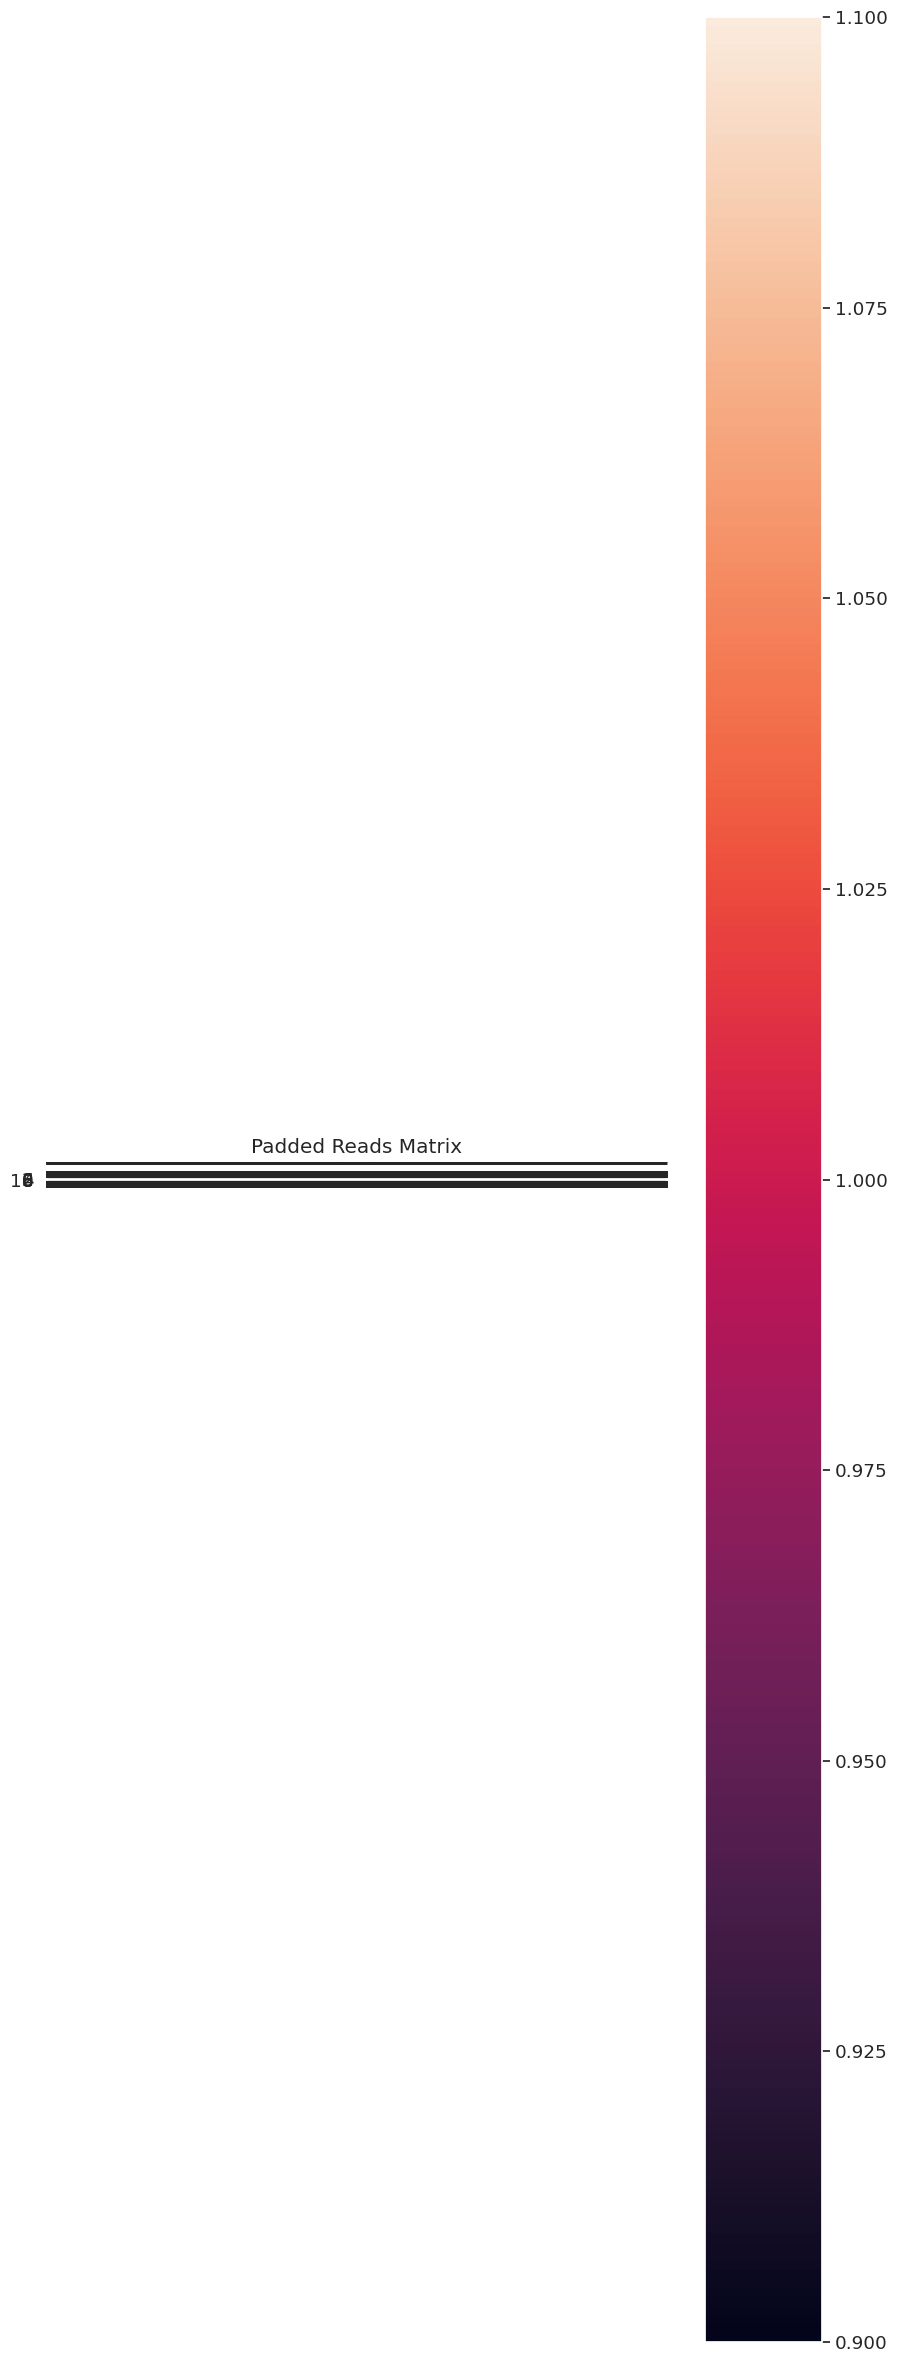

Padded reads saved to padded_reads_day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2_mCthresh0.7_t2t_v2_0_chr1:206583354-206589854_2025-09-08.npy
Padded reads loaded successfully.


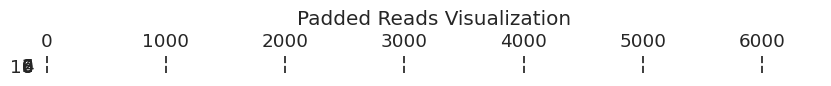

Visualization completed.
Region length: 6500
GTCATTGTATGGTTCCTGGGATAAGAGTAAGAACCGTGGTCCCTTGCTCTGTCAAAATCATAAACCTATTTTCTTTGTATTTTGACTTAATTACATAAGCTTGTTTTGGATTGGAAGGTCTATAGAGACTATTTTAGTGCCAAATGCTATTTAATCAATGCAGAAATAAGCCCTTGAGAGGTGCAGTGACTCAGCTGAGGACACACTGATAGTTTCTGGTAGATAAGTATGAAGCCTTGGAACTACTTCTCATATCATAAGCCCCTGGGTTCCCAAATCACCTCCCCAAGTACCTAATTCATCATCCTCTGCATACAAGAAATTTTTGCTCATTCCAATAAAAAGAATGTAGTACGGCAGGACAGGAGAAGTACAGGTTTTGGAATCAAACTAGGTTTAGATTCTGACCTGGTCGCTAGTTAGTGCATGGGCTTTGGTAAACAGCCTCTCAGCCTGTTTCCTTGTCTGCAAAATATGGATAGTTATCTTCACTTCATGAAGTTGTGTTGGTGAAATGGTATAATGTGTATAAAGCAACTGGAACACAACAAATGAGGCCATTTATTTAAAATAATCTTTAGTAAGTTATAAATTCACATATTTGCTTTTTTCTGAGGAATGCTTAGATTTTATCATAGATCTCTTTTCTAAATTGAGTAAATACATAGTGGATTTCTTTGTTTCCTTCCCCTCAGAATGTTGAAATTTGGCTGATTGTAACTATTACTTAAGACTCTATCCAGTAATTGTTCGTAAAATTTCTTTTCTTTTTTTTTTTTTGAGACGGAGTTTTGCTCTCGTCCCCCAGGCTGGAGTGCAATGGCGCGATCTTGGCTCACTGCAACCTCCGCCTCCCAGGTTCAAGTGATTCTCCCGCCTCAGCCTCCCAAGTAGCTGGGATTACAGGCACCTGCCACAACGCCCAGCCAATTTTTGTATTTTTAGTAGAGACGGG

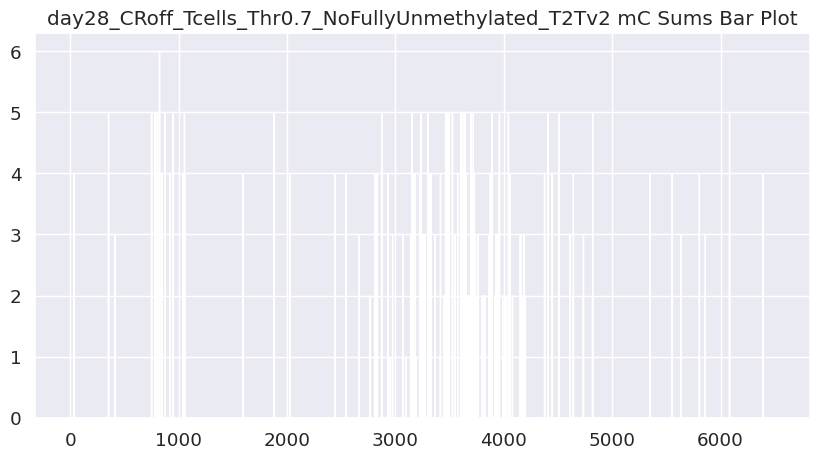

(mC_sums / len(CGs_all) = [0. 0. 0. ... 0. 0. 0.]


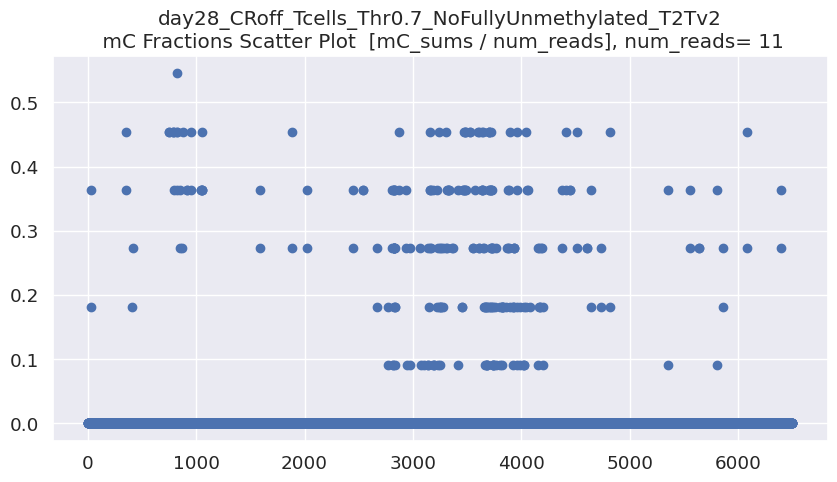

len(CGs_all) = 11
CGs_all.shape = (11, 137)
len(CGs_all_on_fwd_C_sums) = 6500
CGs_all_on_fwd_C_sums.shape = (6500,)


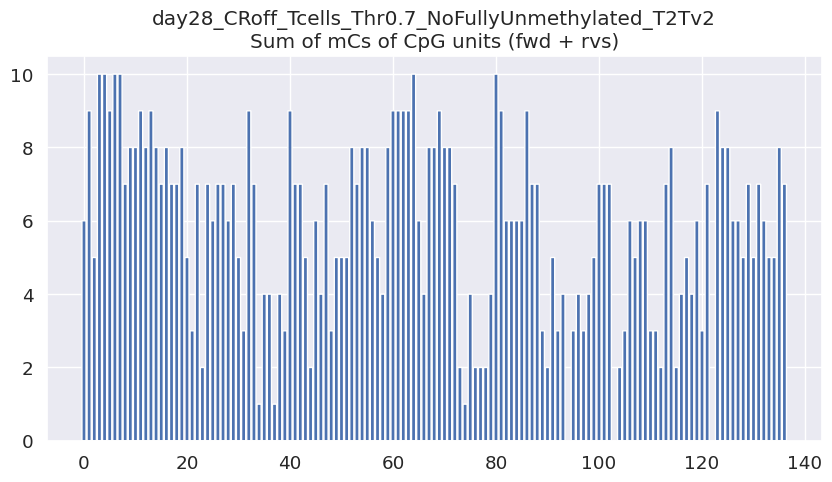

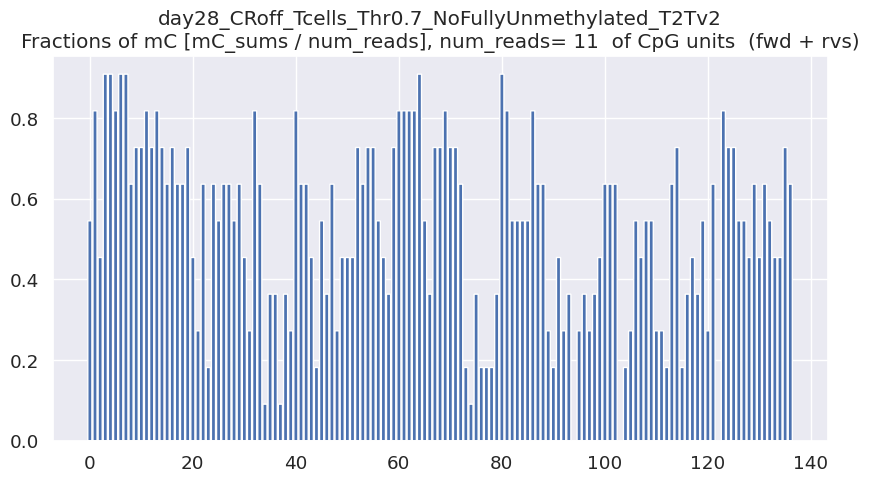

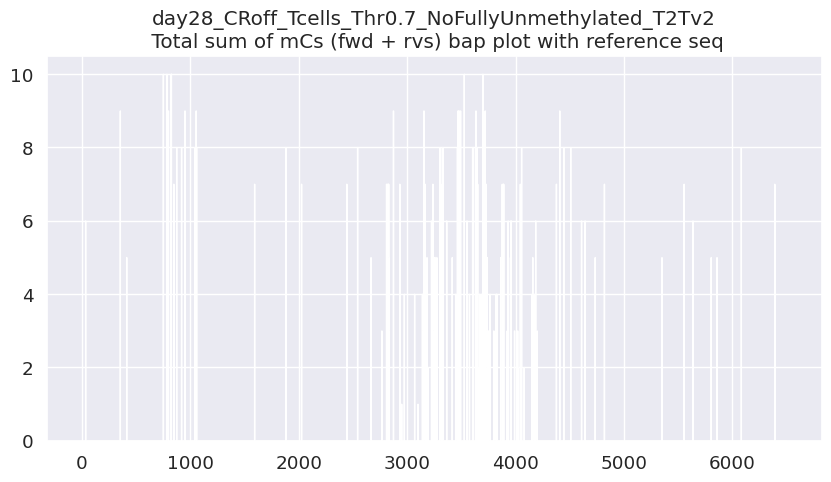

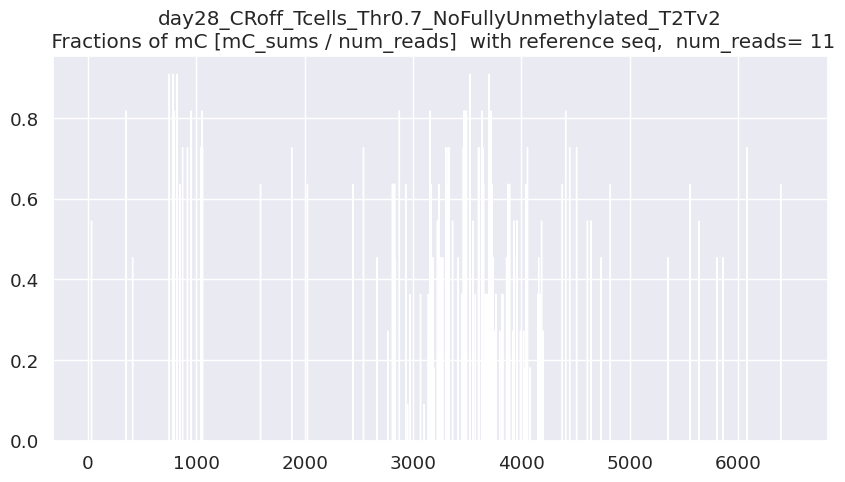

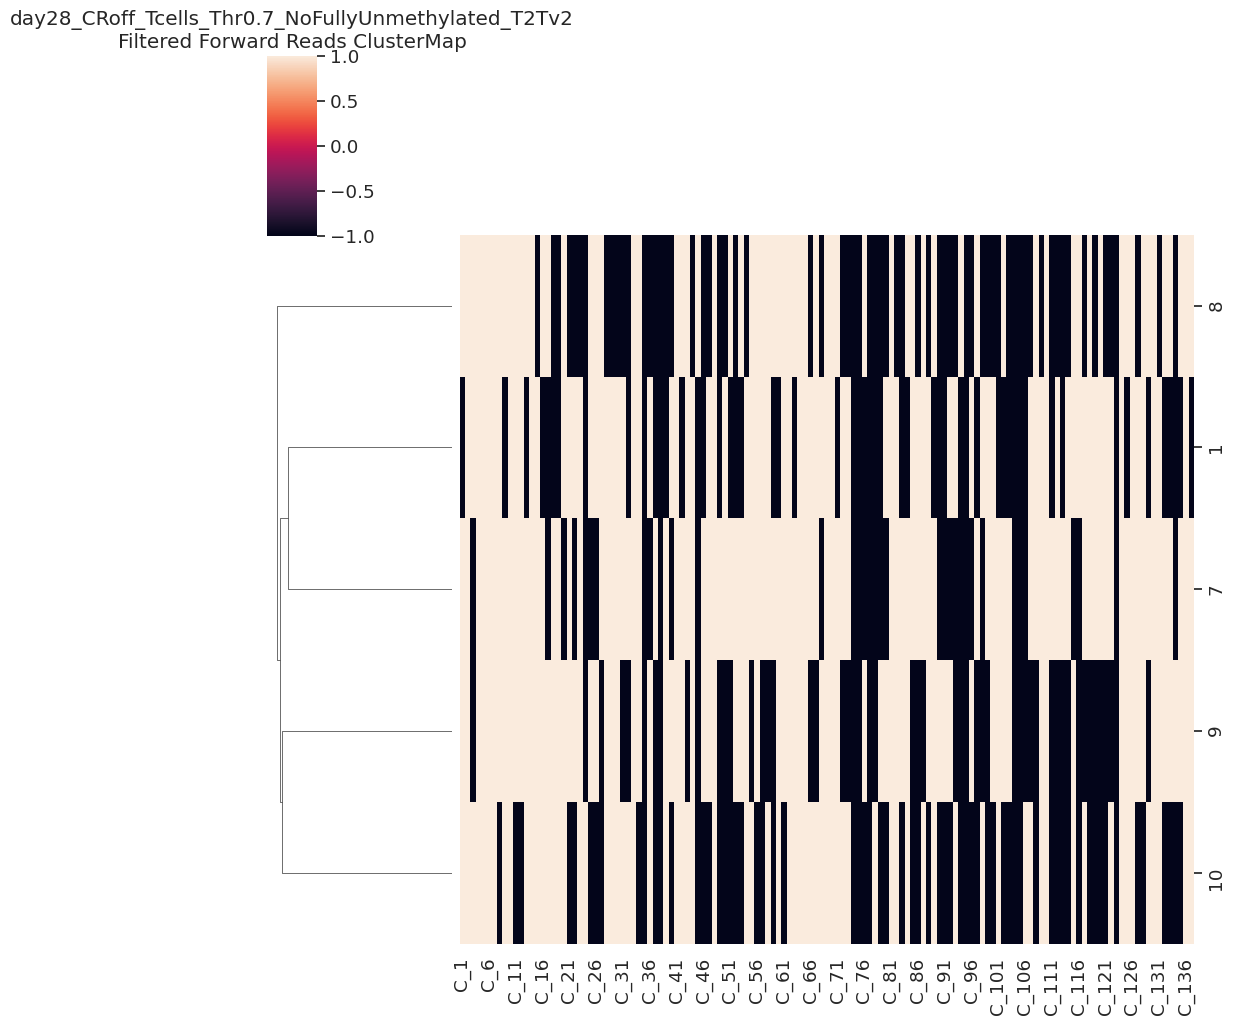

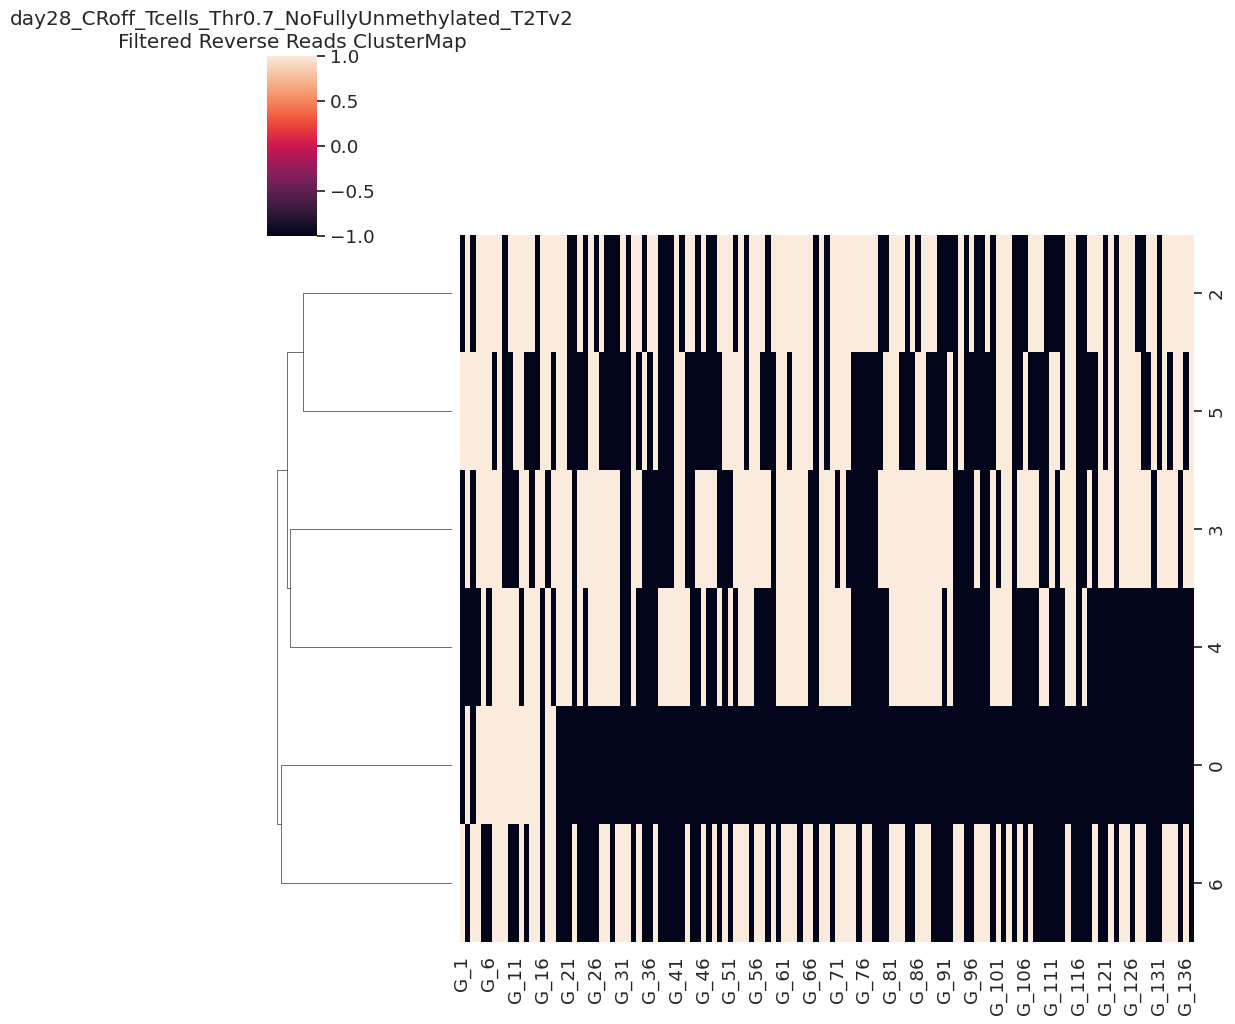

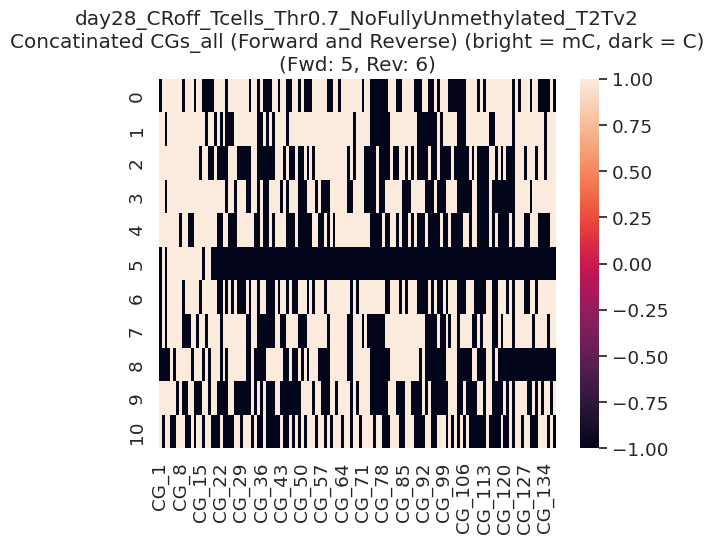

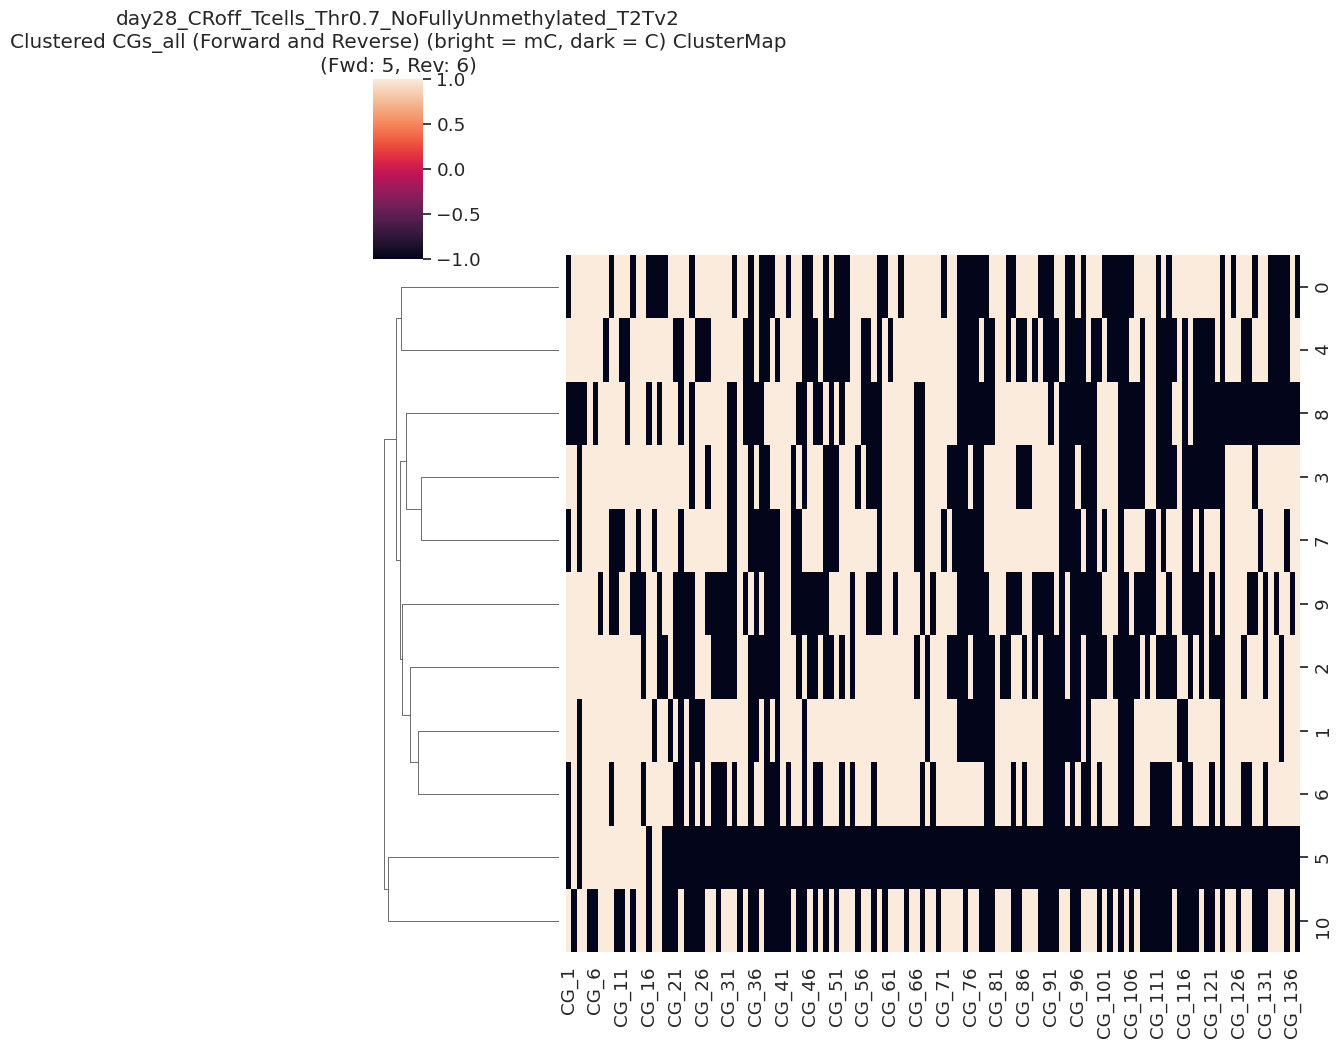

CGs_all saved as CG_137_padded_reads_day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2_mCthresh0.7_t2t_v2_0_chr1:206583354-206589854_2025-09-08_units_combined_numFWD5_numRVS6.npy in dimelo_v2_output
Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)


In [6]:
threshold_mC = 0.7 # 0.995 #0.7 #  0.9 #0.99

max_reads_plot = 3000

threshold_mapping_qualities=60 
threshold_avg_base_qualities=20

threshold_fraction_overlap_aligned = 0.9 # 0.1
threshold_fraction_mismatches = 0.7 # 0.5
# indel_fraction_threshold = 1  # 0.8
# non_fraction_threshold   = 1

# experiment_name = "day"+str(day_num)+"_unedited_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"
experiment_name = "day"+str(day_num)+"_CRoff_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"

bam_path = original_bam_path #  unedit_bam_path

print('experiment_name = ', experiment_name)

save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
output_dir = create_output_directory("./dimelo_v2_output")

extract_file, extract_regions = extract_from_bam(
    experiment_name = experiment_name,
    bam_path=bam_path,
    ref_genome_file=ref_genome_path,
    output_dir=output_dir,
    region=region_str,
    motifs=motifs,
    output_name='extracted_reads',
    threshold_mC=threshold_mC,
)
keep_full_coverage_reads_only=True

if extract_file:
    reads_df, regions_dict = process_extracted_reads(extract_file, bam_path, region_str, 
        motifs, ref_seq_list, ref_genome_path=ref_genome_path, 
        experiment_name=experiment_name, output_dir=output_dir, 
        keep_full_coverage_reads_only=keep_full_coverage_reads_only,
        threshold_fraction_overlap_aligned=threshold_fraction_overlap_aligned,
        threshold_fraction_mismatches=threshold_fraction_mismatches,
        threshold_mapping_qualities=threshold_mapping_qualities, 
        threshold_avg_base_qualities=threshold_avg_base_qualities,
        max_reads_plot=max_reads_plot)
        # indel_fraction_threshold=indel_fraction_threshold, 
        # non_fraction_threshold=non_fraction_threshold)
        
    visualize_data(reads_df)

    padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
    if padded_reads is not None:
        plot_padded_reads(padded_reads, ref_seq_list)
        save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)

# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")


experiment_name =  day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2
Region length: 6500
No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.995 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in up_chm13v2.0.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_t2t_v2_0_trim_20250721_Day28_CROFF_T_cells_minion_merged_flowc…

          |    0%

          | Transferring 28 from reads.CG,0.txt into reads.combined_basemods.h5, new size 28   0% | 00:00<?

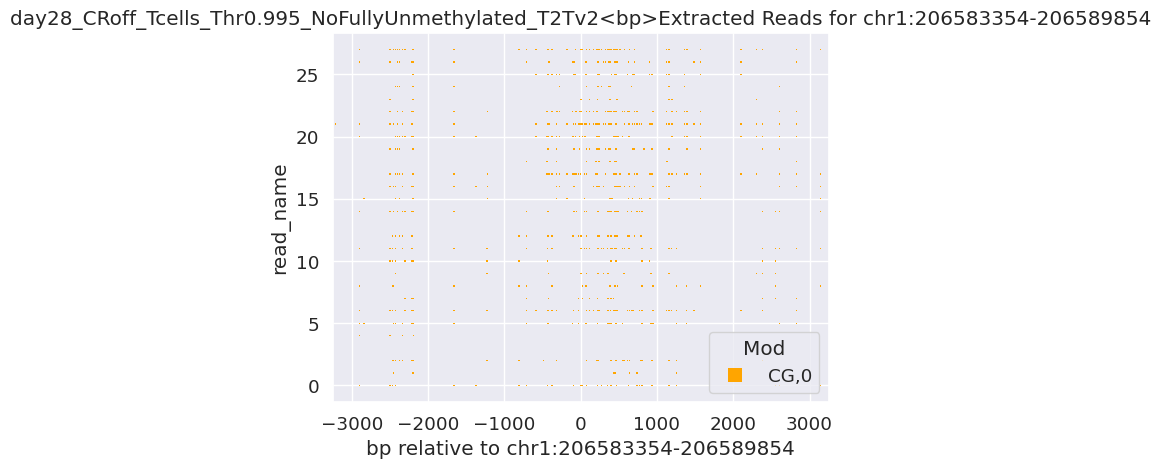

Found read coordinates: 28 reads
Unique read names with methylation: 26
In function count_indels_and_mismatches: Processing region is chr1:206583354-206589854
In function count_indels_and_mismatches: Region length is 6500
Found 13 reads with full coverage
Reads with methylation data: 26
Overlap between full coverage and methylation: 13
After full coverage filtering: 13 reads with methylation data
After removing reads with <90.0% threshold_fraction_overlap_aligned: 12 reads with methylation data
After removing reads with >70.0% threshold_fraction_mismatches: 12 reads with methylation data
After removing reads with >60 threshold_mapping_qualities: 12 reads with methylation data
After removing reads with >20 threshold_avg_base_qualities: 11 reads with methylation data
Final result: 401 reads with methylation information out of 28 total reads
Subset BAM written to: dimelo_v2_output/filtered_reads_overlap_MORE_than_0.9_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam
Index written 

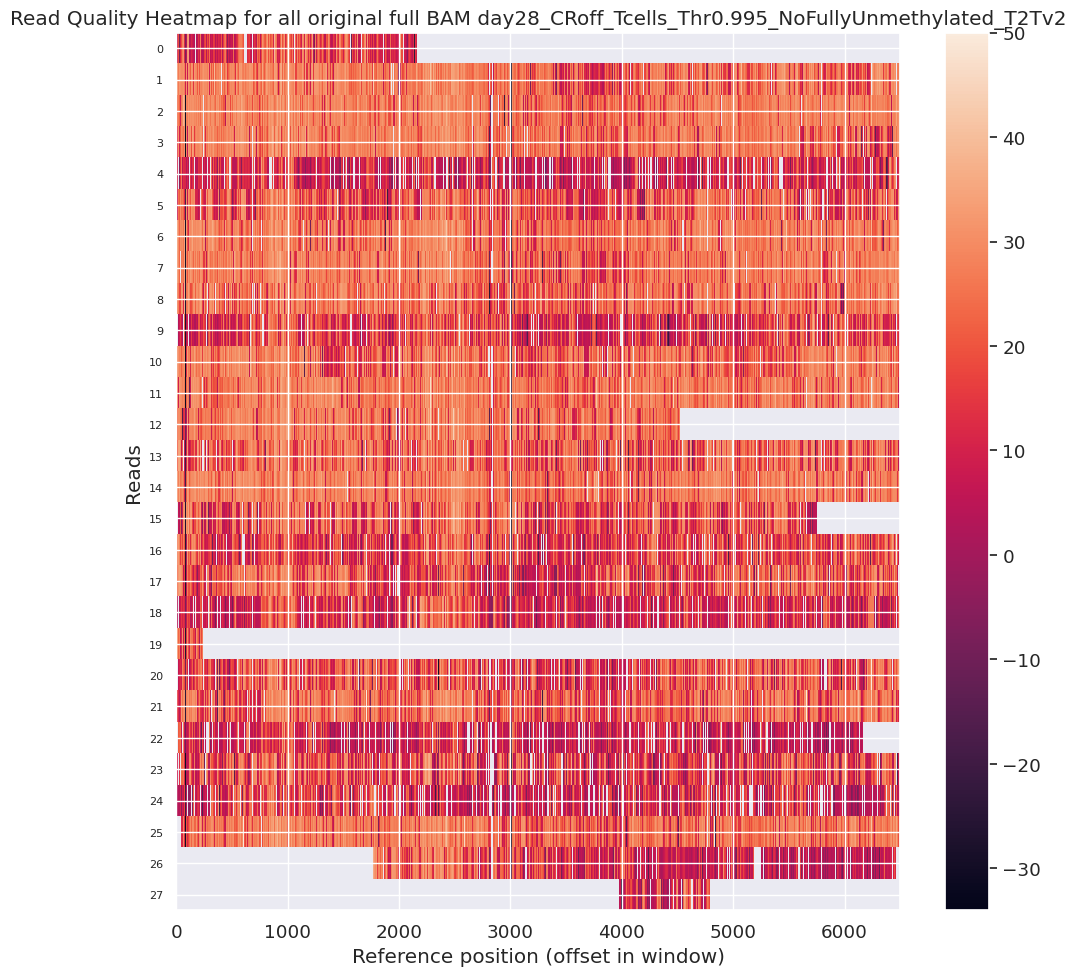

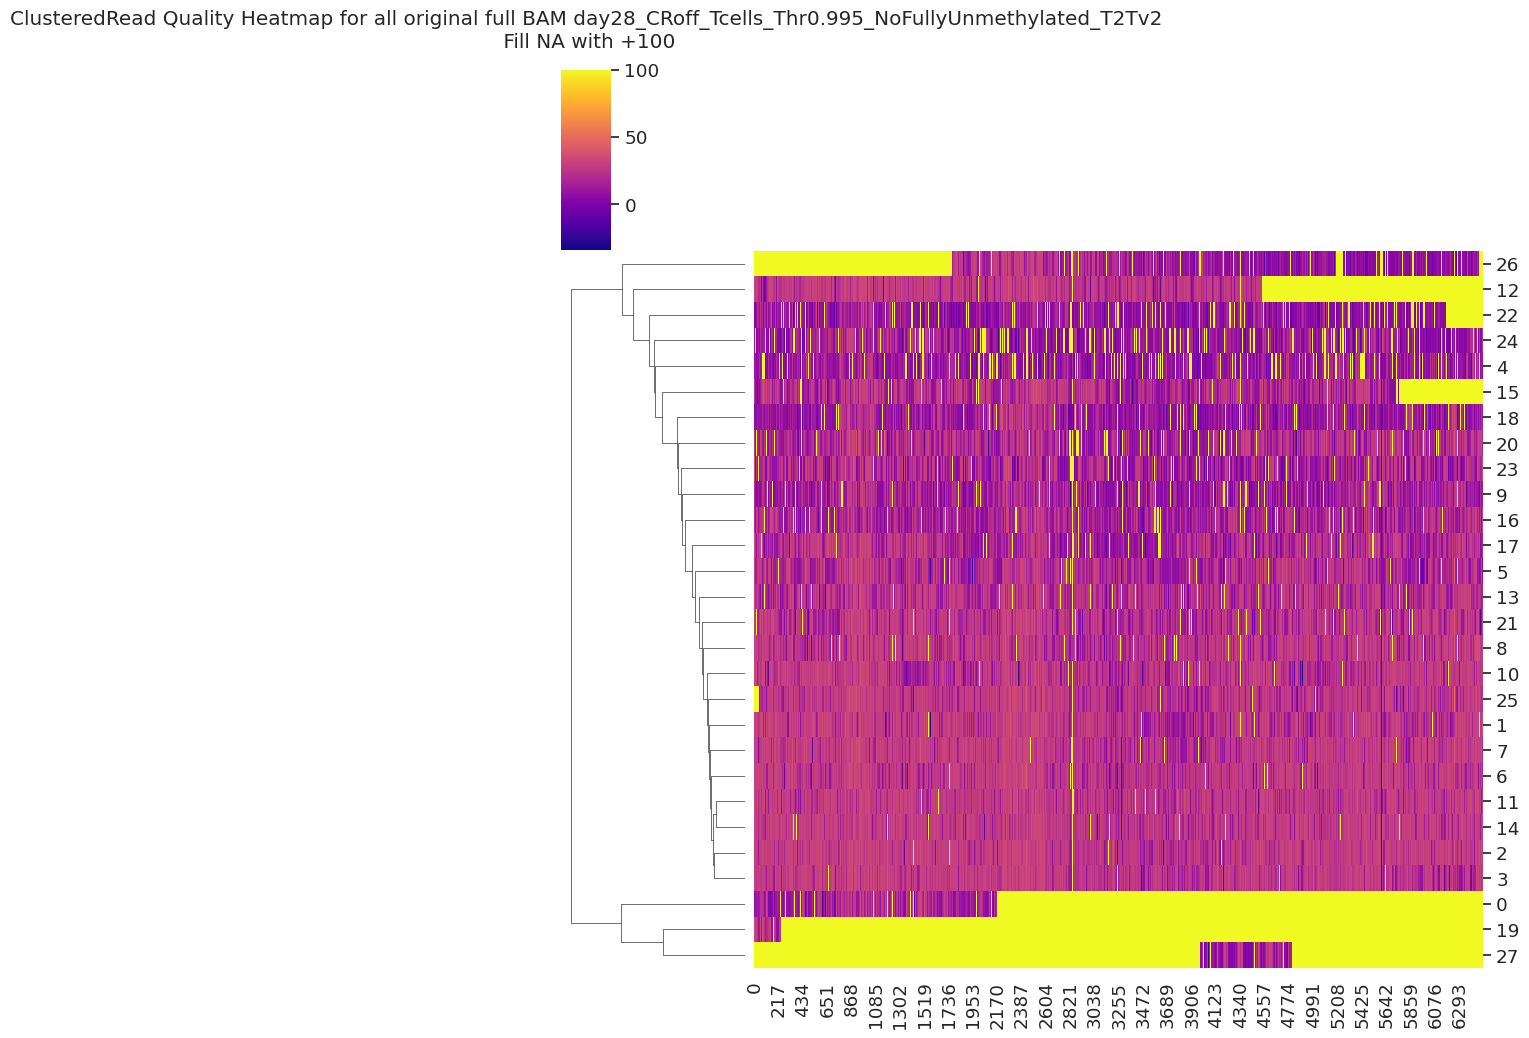

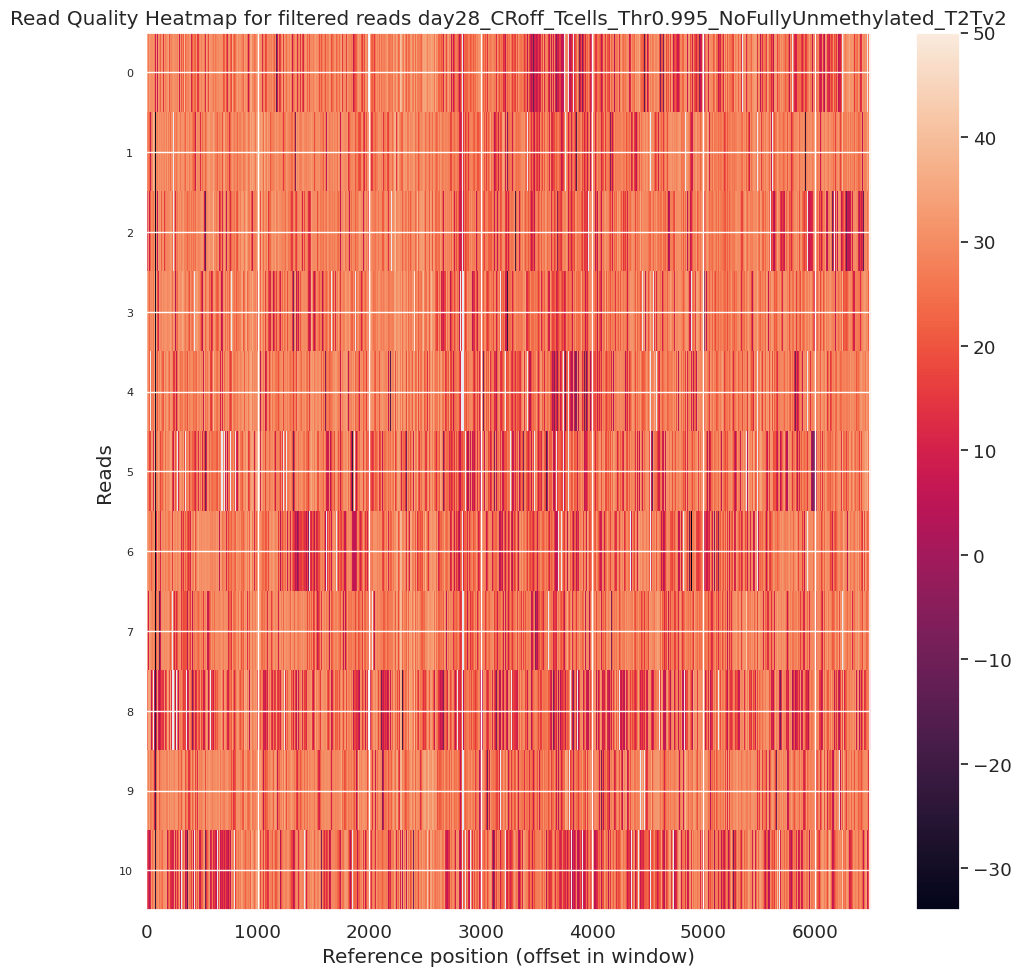

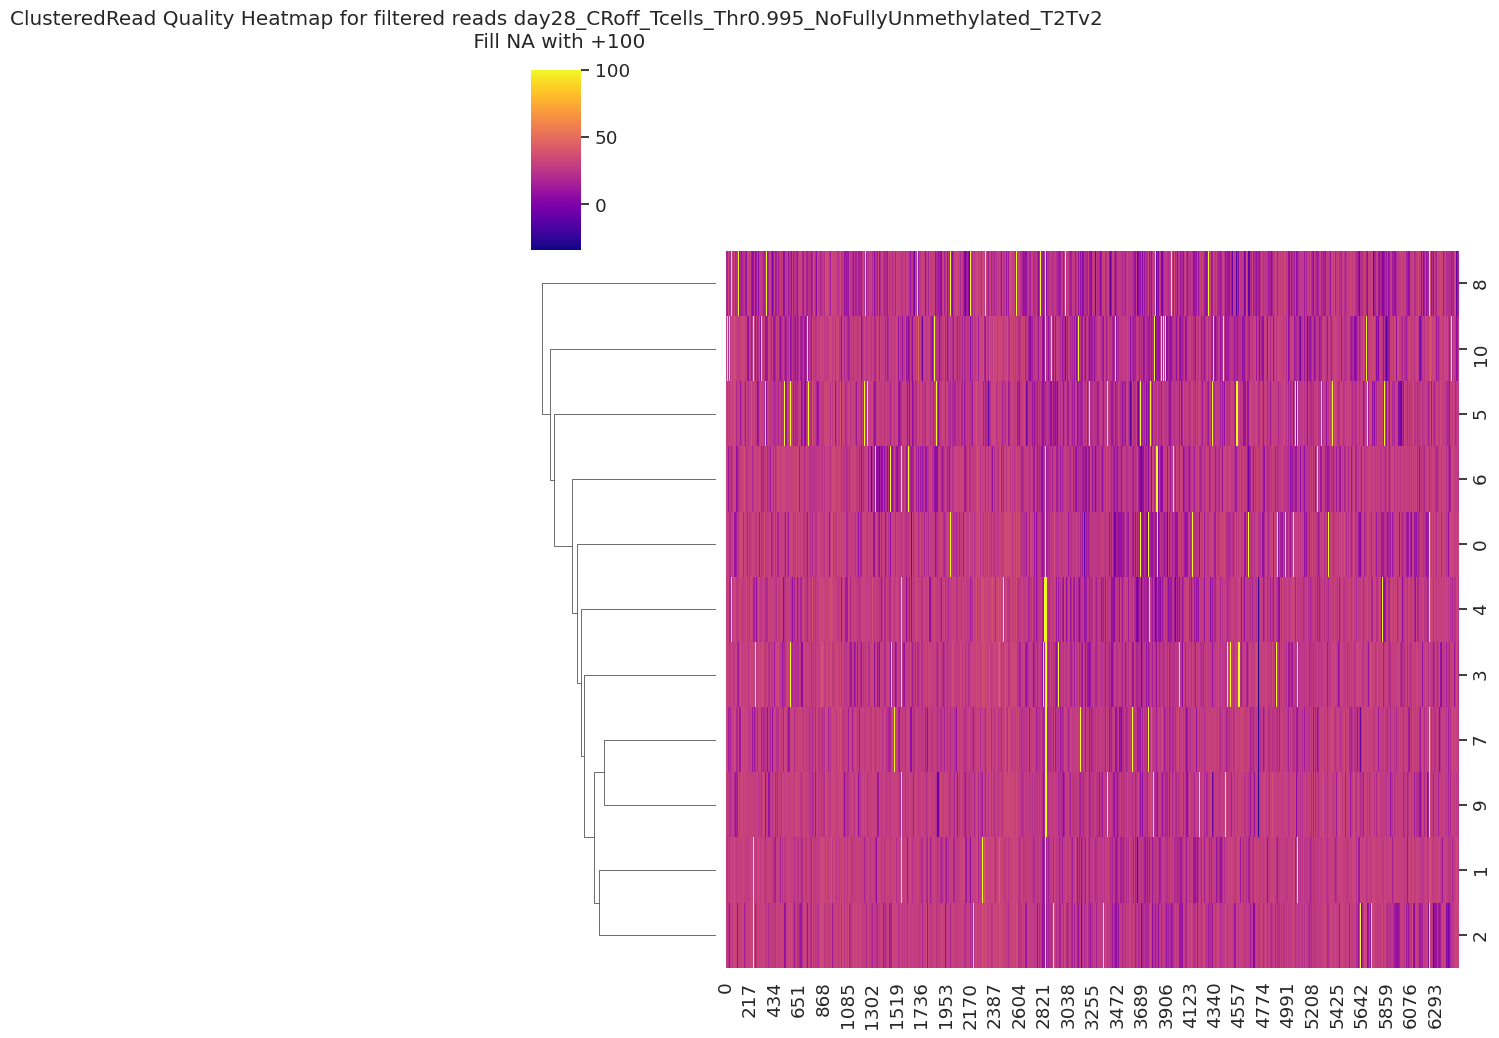

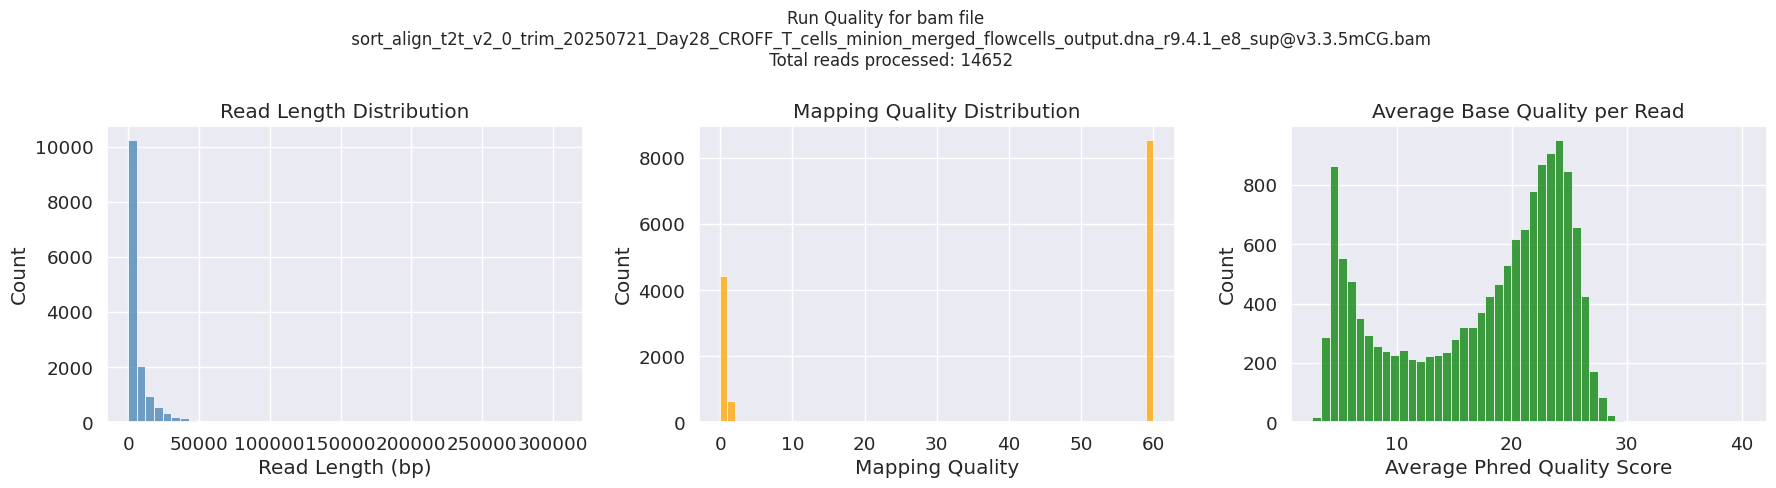

Total reads processed: 14652


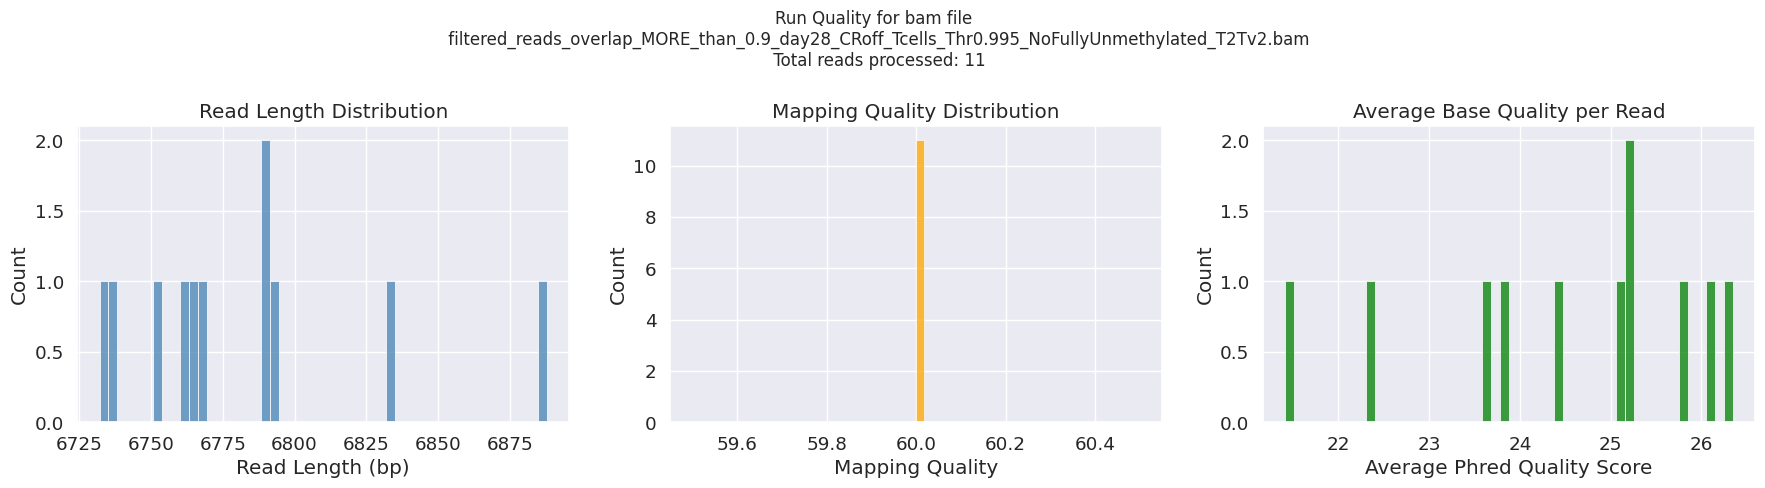

Total reads processed: 11


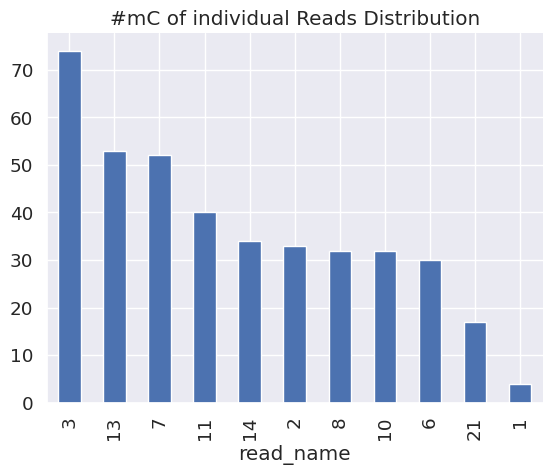

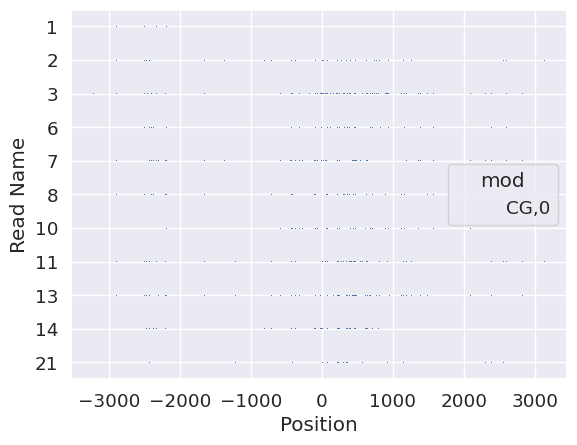

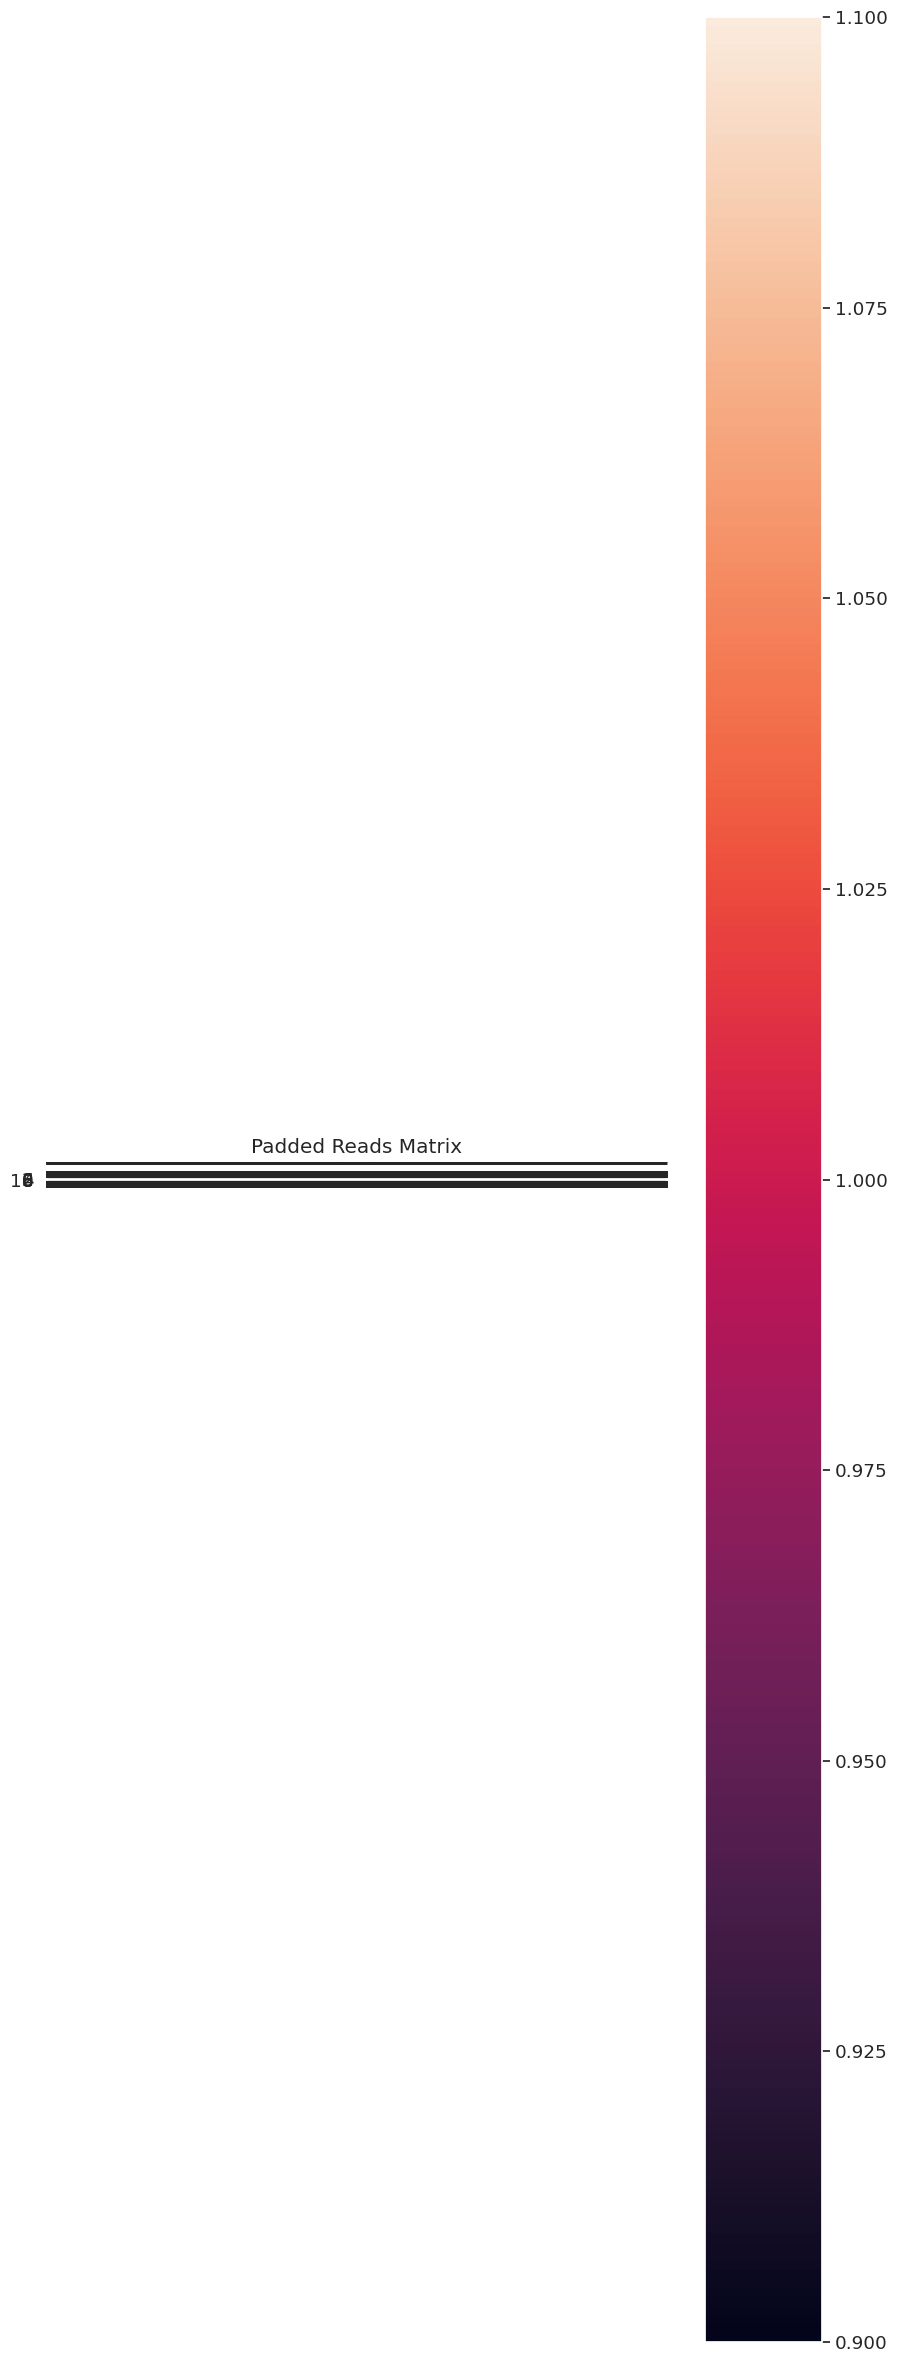

Padded reads saved to padded_reads_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2_mCthresh0.995_t2t_v2_0_chr1:206583354-206589854_2025-09-08.npy
Padded reads loaded successfully.


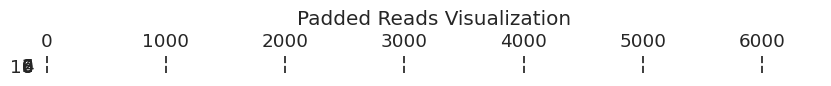

Visualization completed.
Region length: 6500
GTCATTGTATGGTTCCTGGGATAAGAGTAAGAACCGTGGTCCCTTGCTCTGTCAAAATCATAAACCTATTTTCTTTGTATTTTGACTTAATTACATAAGCTTGTTTTGGATTGGAAGGTCTATAGAGACTATTTTAGTGCCAAATGCTATTTAATCAATGCAGAAATAAGCCCTTGAGAGGTGCAGTGACTCAGCTGAGGACACACTGATAGTTTCTGGTAGATAAGTATGAAGCCTTGGAACTACTTCTCATATCATAAGCCCCTGGGTTCCCAAATCACCTCCCCAAGTACCTAATTCATCATCCTCTGCATACAAGAAATTTTTGCTCATTCCAATAAAAAGAATGTAGTACGGCAGGACAGGAGAAGTACAGGTTTTGGAATCAAACTAGGTTTAGATTCTGACCTGGTCGCTAGTTAGTGCATGGGCTTTGGTAAACAGCCTCTCAGCCTGTTTCCTTGTCTGCAAAATATGGATAGTTATCTTCACTTCATGAAGTTGTGTTGGTGAAATGGTATAATGTGTATAAAGCAACTGGAACACAACAAATGAGGCCATTTATTTAAAATAATCTTTAGTAAGTTATAAATTCACATATTTGCTTTTTTCTGAGGAATGCTTAGATTTTATCATAGATCTCTTTTCTAAATTGAGTAAATACATAGTGGATTTCTTTGTTTCCTTCCCCTCAGAATGTTGAAATTTGGCTGATTGTAACTATTACTTAAGACTCTATCCAGTAATTGTTCGTAAAATTTCTTTTCTTTTTTTTTTTTTGAGACGGAGTTTTGCTCTCGTCCCCCAGGCTGGAGTGCAATGGCGCGATCTTGGCTCACTGCAACCTCCGCCTCCCAGGTTCAAGTGATTCTCCCGCCTCAGCCTCCCAAGTAGCTGGGATTACAGGCACCTGCCACAACGCCCAGCCAATTTTTGTATTTTTAGTAGAGACGGG

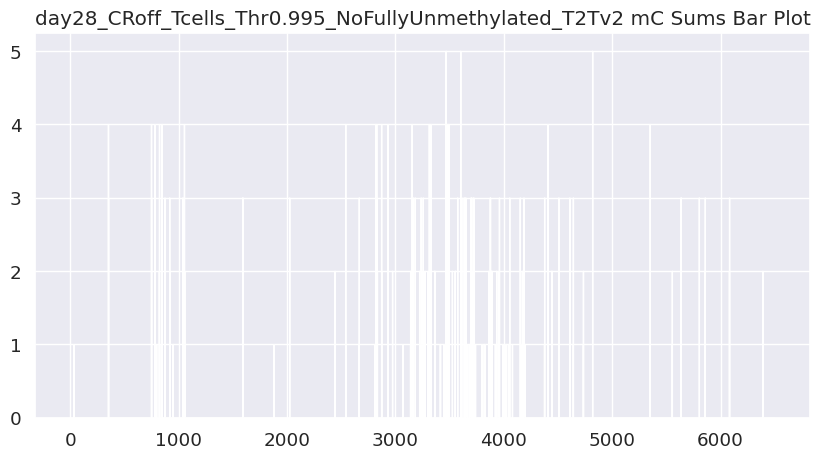

(mC_sums / len(CGs_all) = [0. 0. 0. ... 0. 0. 0.]


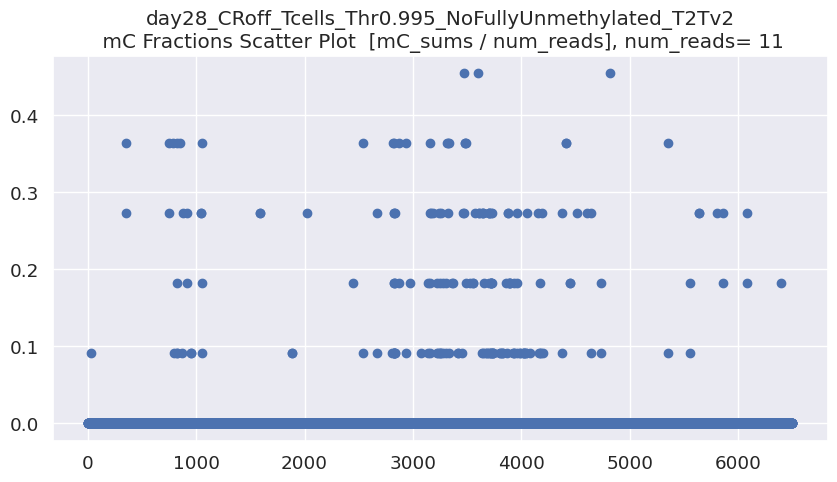

len(CGs_all) = 11
CGs_all.shape = (11, 137)
len(CGs_all_on_fwd_C_sums) = 6500
CGs_all_on_fwd_C_sums.shape = (6500,)


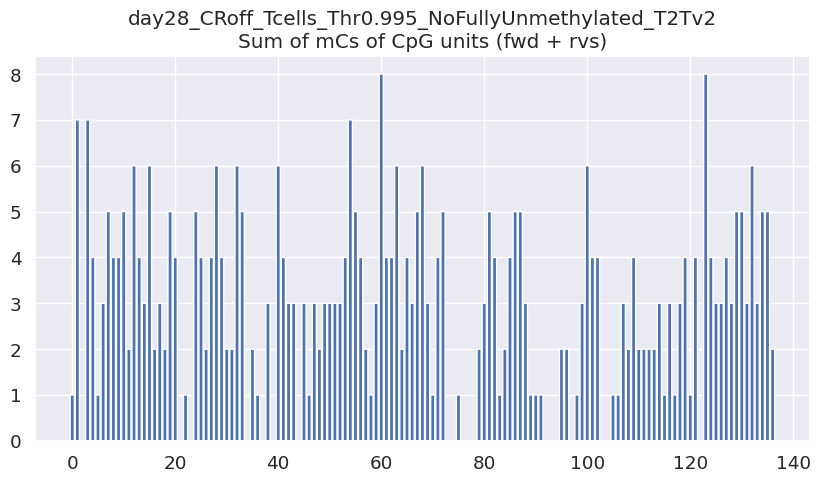

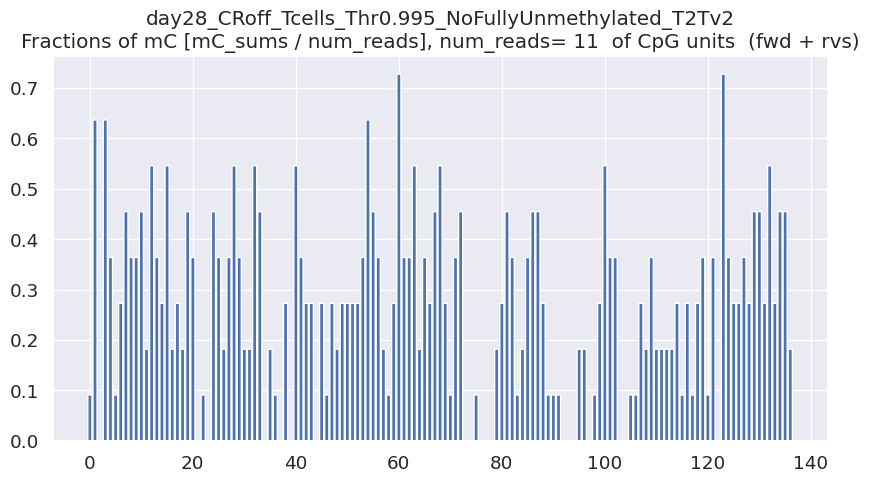

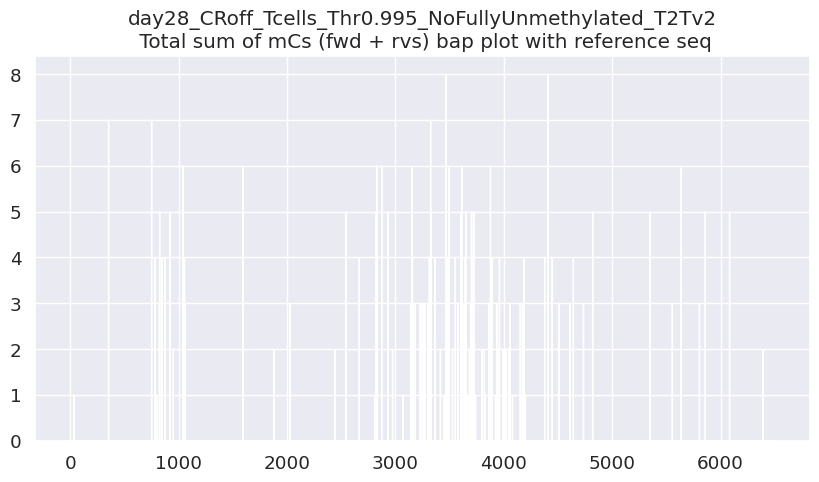

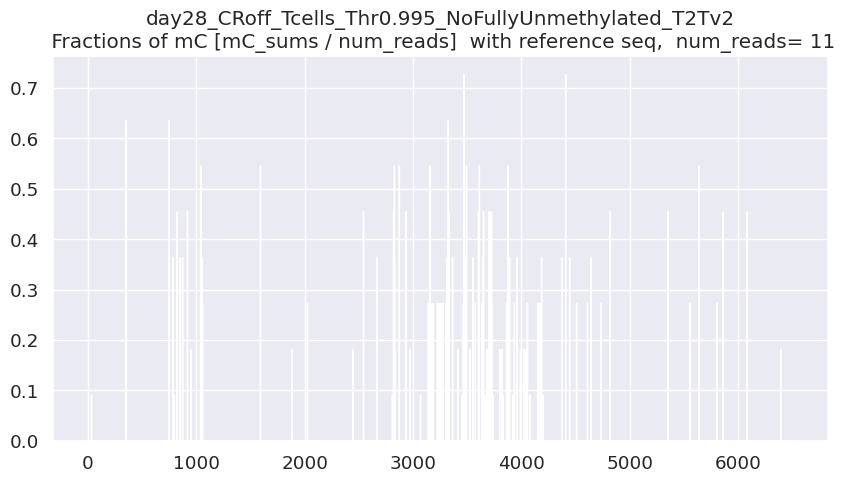

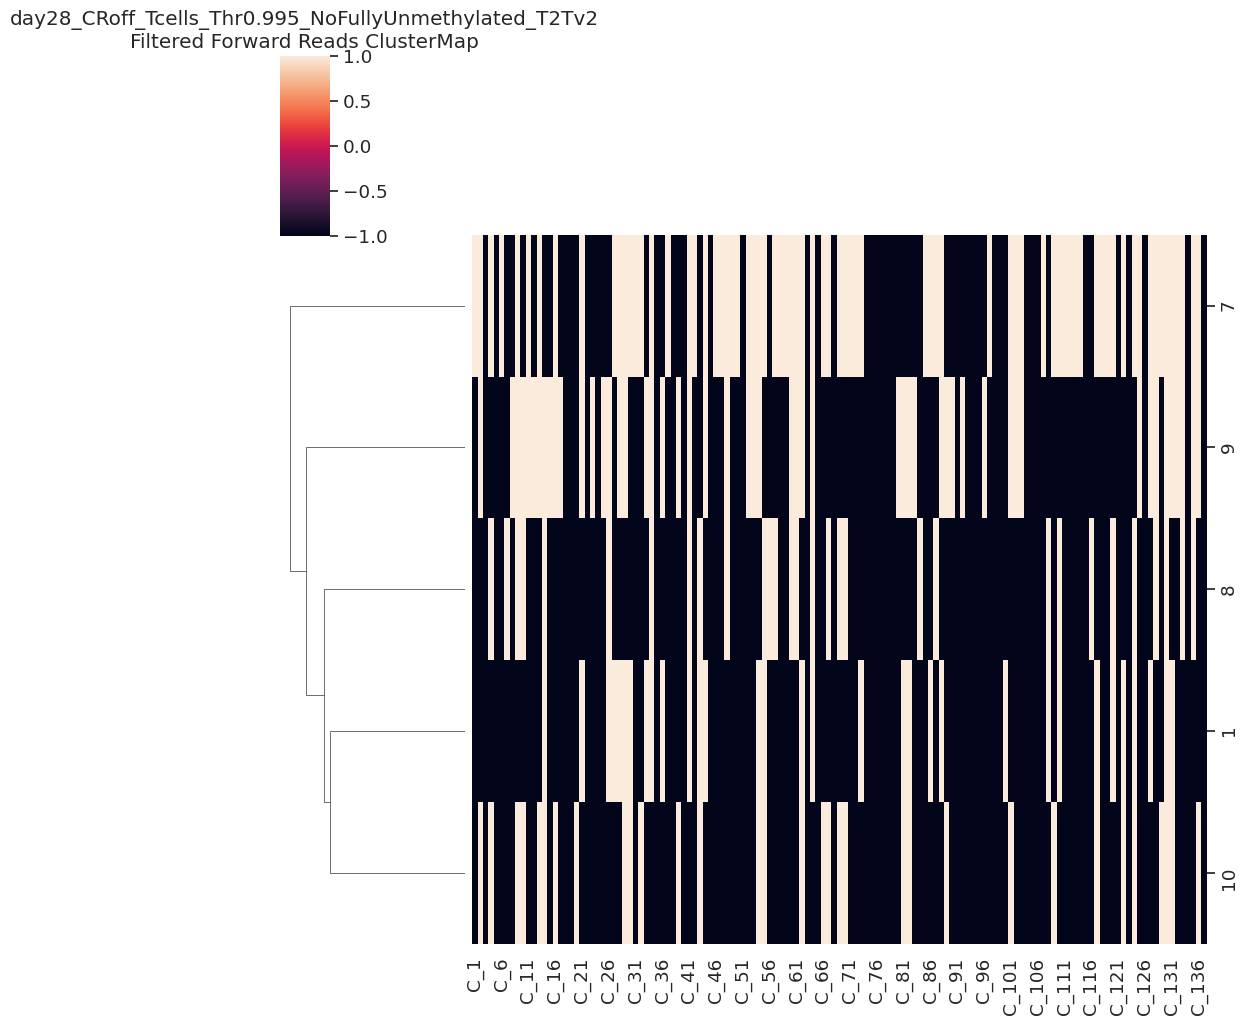

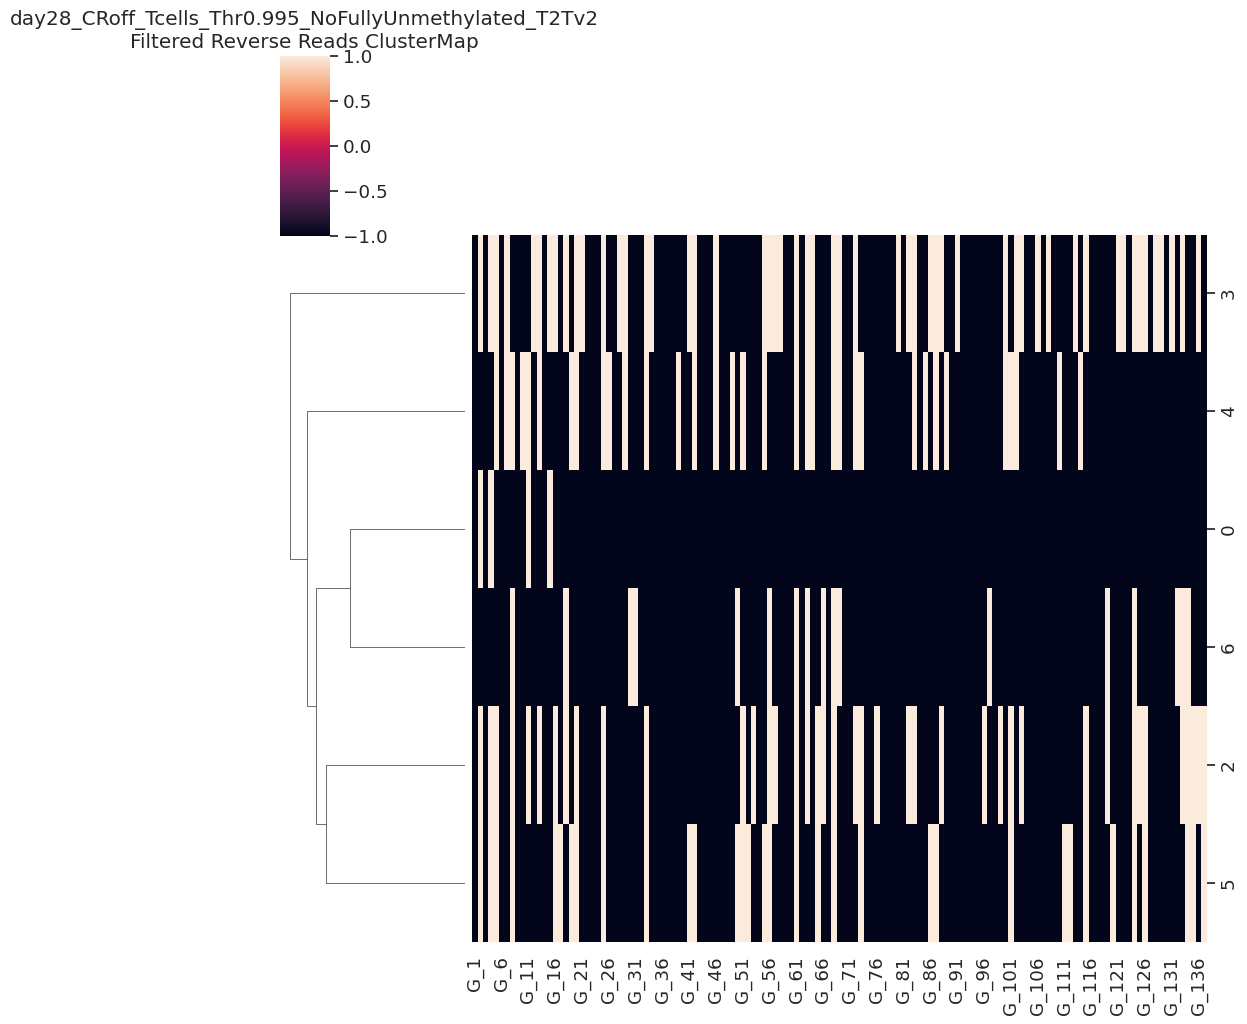

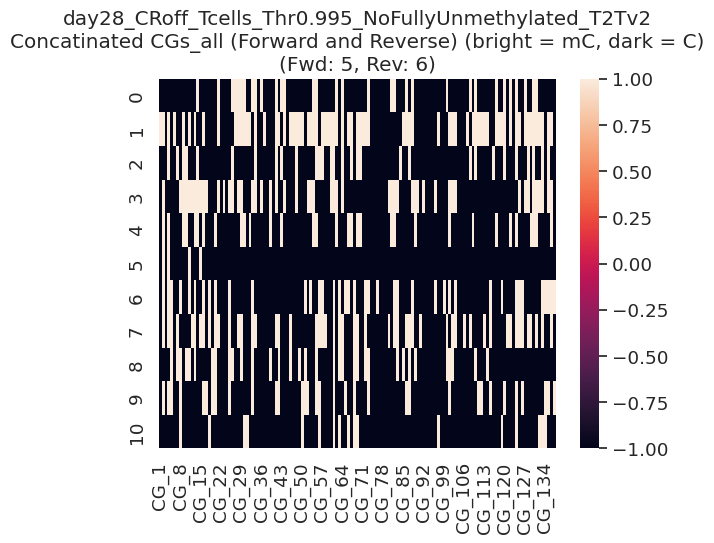

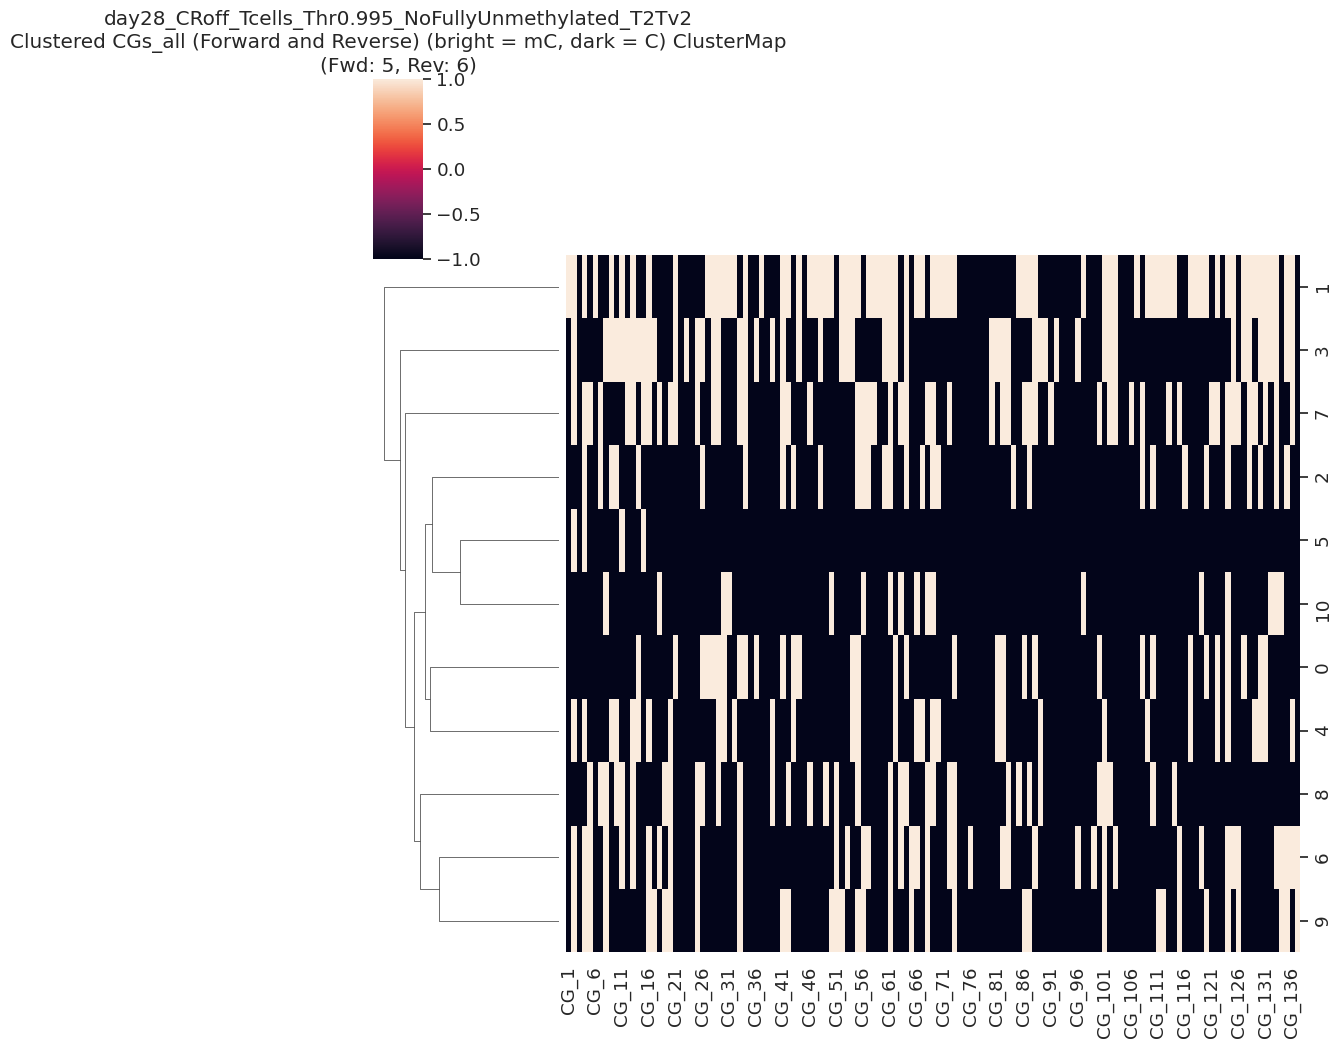

CGs_all saved as CG_137_padded_reads_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2_mCthresh0.995_t2t_v2_0_chr1:206583354-206589854_2025-09-08_units_combined_numFWD5_numRVS6.npy in dimelo_v2_output
Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)


In [7]:
threshold_mC = 0.995 #0.7 #  0.9 #0.99

max_reads_plot = 3000

threshold_mapping_qualities=60 
threshold_avg_base_qualities=20

threshold_fraction_overlap_aligned = 0.9 # 0.1
threshold_fraction_mismatches = 0.7 # 0.5
# indel_fraction_threshold = 1  # 0.8
# non_fraction_threshold   = 1

# experiment_name = "day"+str(day_num)+"_unedited_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"
experiment_name = "day"+str(day_num)+"_CRoff_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"

bam_path = original_bam_path #  unedit_bam_path

print('experiment_name = ', experiment_name)

save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
output_dir = create_output_directory("./dimelo_v2_output")

extract_file, extract_regions = extract_from_bam(
    experiment_name = experiment_name,
    bam_path=bam_path,
    ref_genome_file=ref_genome_path,
    output_dir=output_dir,
    region=region_str,
    motifs=motifs,
    output_name='extracted_reads',
    threshold_mC=threshold_mC,
)
keep_full_coverage_reads_only=True

if extract_file:
    reads_df, regions_dict = process_extracted_reads(extract_file, bam_path, region_str, 
        motifs, ref_seq_list, ref_genome_path=ref_genome_path, 
        experiment_name=experiment_name, output_dir=output_dir, 
        keep_full_coverage_reads_only=keep_full_coverage_reads_only,
        threshold_fraction_overlap_aligned=threshold_fraction_overlap_aligned,
        threshold_fraction_mismatches=threshold_fraction_mismatches,
        threshold_mapping_qualities=threshold_mapping_qualities, 
        threshold_avg_base_qualities=threshold_avg_base_qualities,
        max_reads_plot=max_reads_plot)
        # indel_fraction_threshold=indel_fraction_threshold, 
        # non_fraction_threshold=non_fraction_threshold)
        
    visualize_data(reads_df)

    padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
    if padded_reads is not None:
        plot_padded_reads(padded_reads, ref_seq_list)
        save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)

# Processing and visualizing CpG units on forward and reverse strands 
try: 

    # Process pipeline
    CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
        experiment_name=experiment_name, save_folder_path=output_dir, 
        save_padded_reads_name_np=save_padded_reads_name_np, 
        ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
    )

    print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
    # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

except Exception as e:
    print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")


experiment_name =  day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2
Region length: 6500
No specified number of cores requested. 24 available on machine, allocating all.
Modification threshold of 0.7 will be treated as coming from range 0-1.


          | Step 1: Identify motif locations in up_chm13v2.0.fasta   0% | 00:00

          | Step 2: Parse regions in sort_align_t2t_v2_0_trim_20250721_Day28_CROFF_T_cells_minion_merged_flowc…

          |    0%

          | Transferring 28 from reads.CG,0.txt into reads.combined_basemods.h5, new size 28   0% | 00:00<?

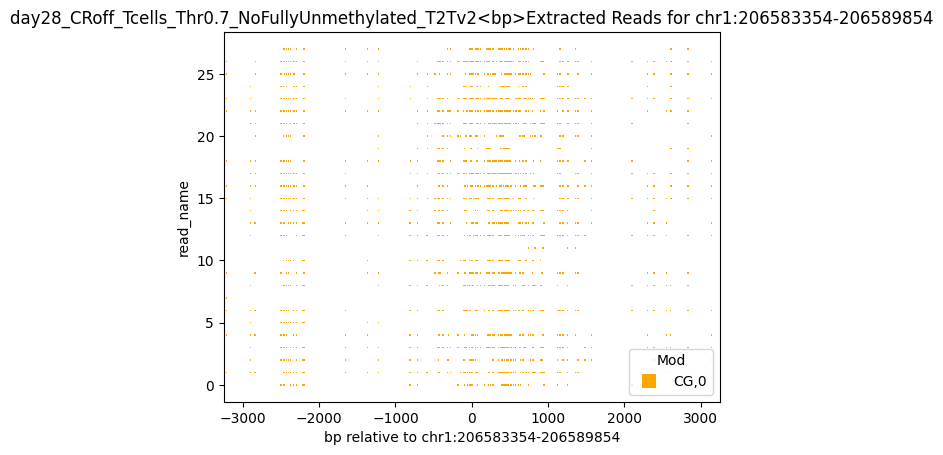

Found read coordinates: 28 reads
Unique read names with methylation: 28
In function count_indels_and_mismatches: Processing region is chr1:206583354-206589854
In function count_indels_and_mismatches: Region length is 6500
Found 13 reads with full coverage
Reads with methylation data: 28
Overlap between full coverage and methylation: 13
After full coverage filtering: 13 reads with methylation data
After removing reads with <70.0% fraction_overlap_aligned_threshold: 12 reads with methylation data
After removing reads with >70.0% fraction_mismatches_threshold: 12 reads with methylation data
Final result: 886 reads with methylation information out of 28 total reads
Subset BAM written to: dimelo_v2_output/filtered_reads_overlap_MORE_than_0.7_day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam
Index written to: dimelo_v2_output/filtered_reads_overlap_MORE_than_0.7_day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam.bai
Filtered BAM with reads that have mC and base overlap > 0.7 writt

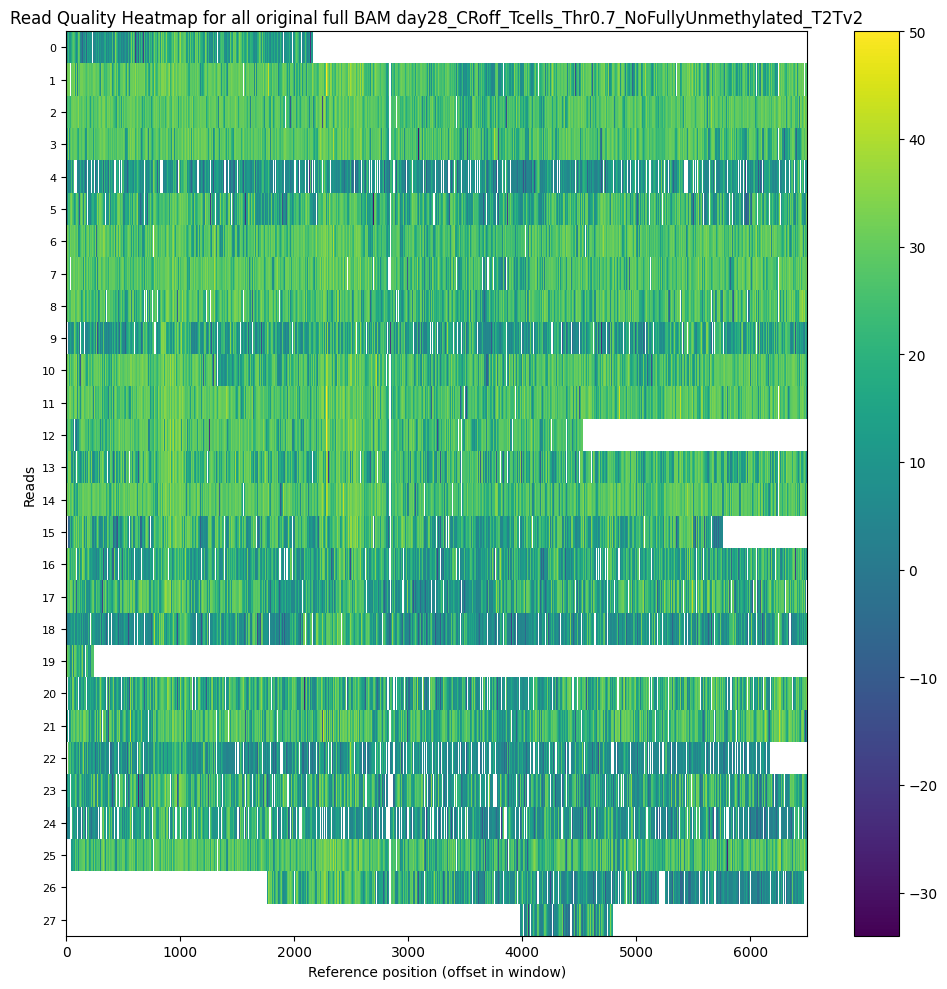

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



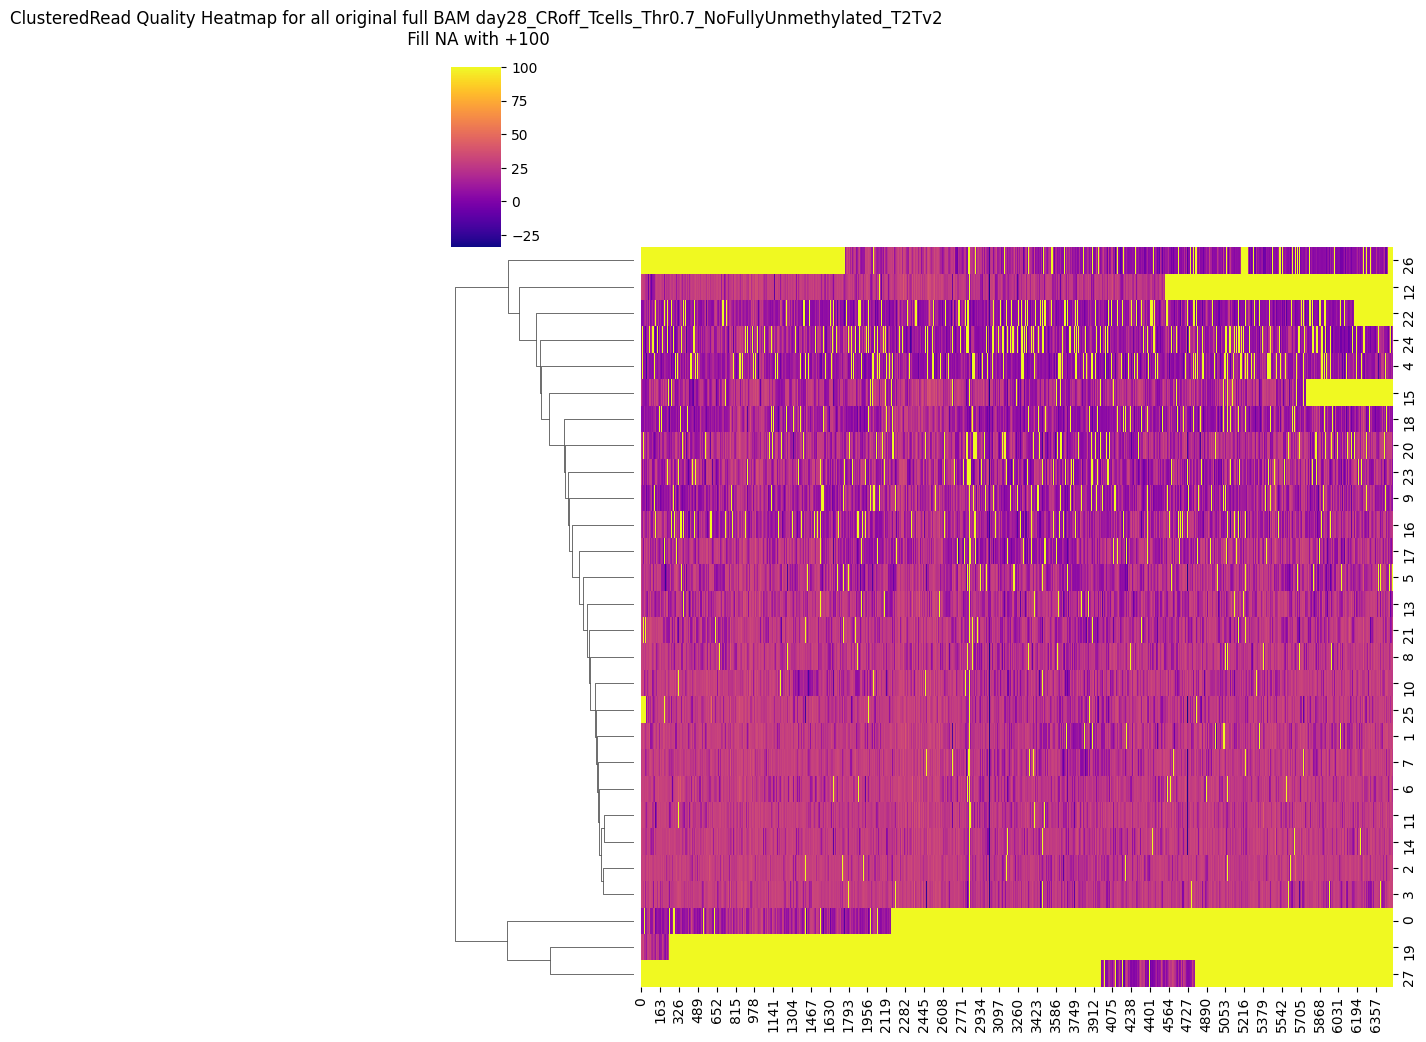

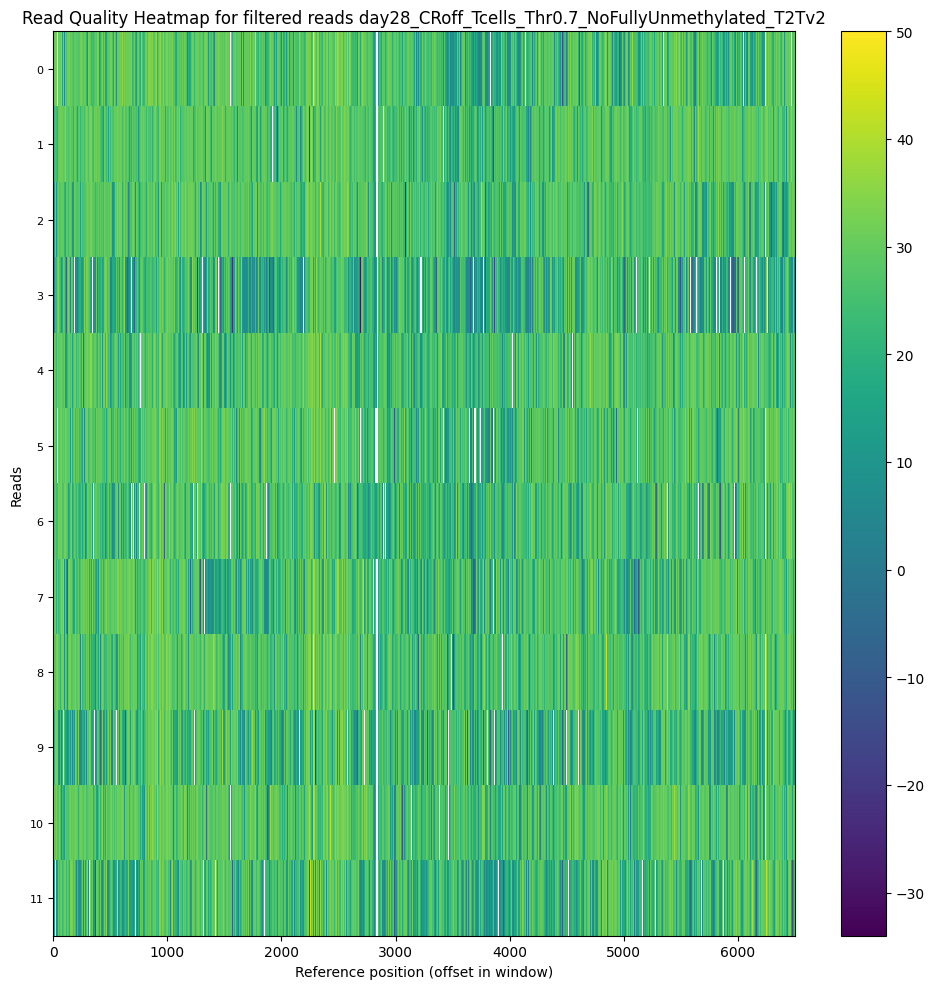

/home/michalula/miniconda3/envs/dimelo_v2_modkit_parsing/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



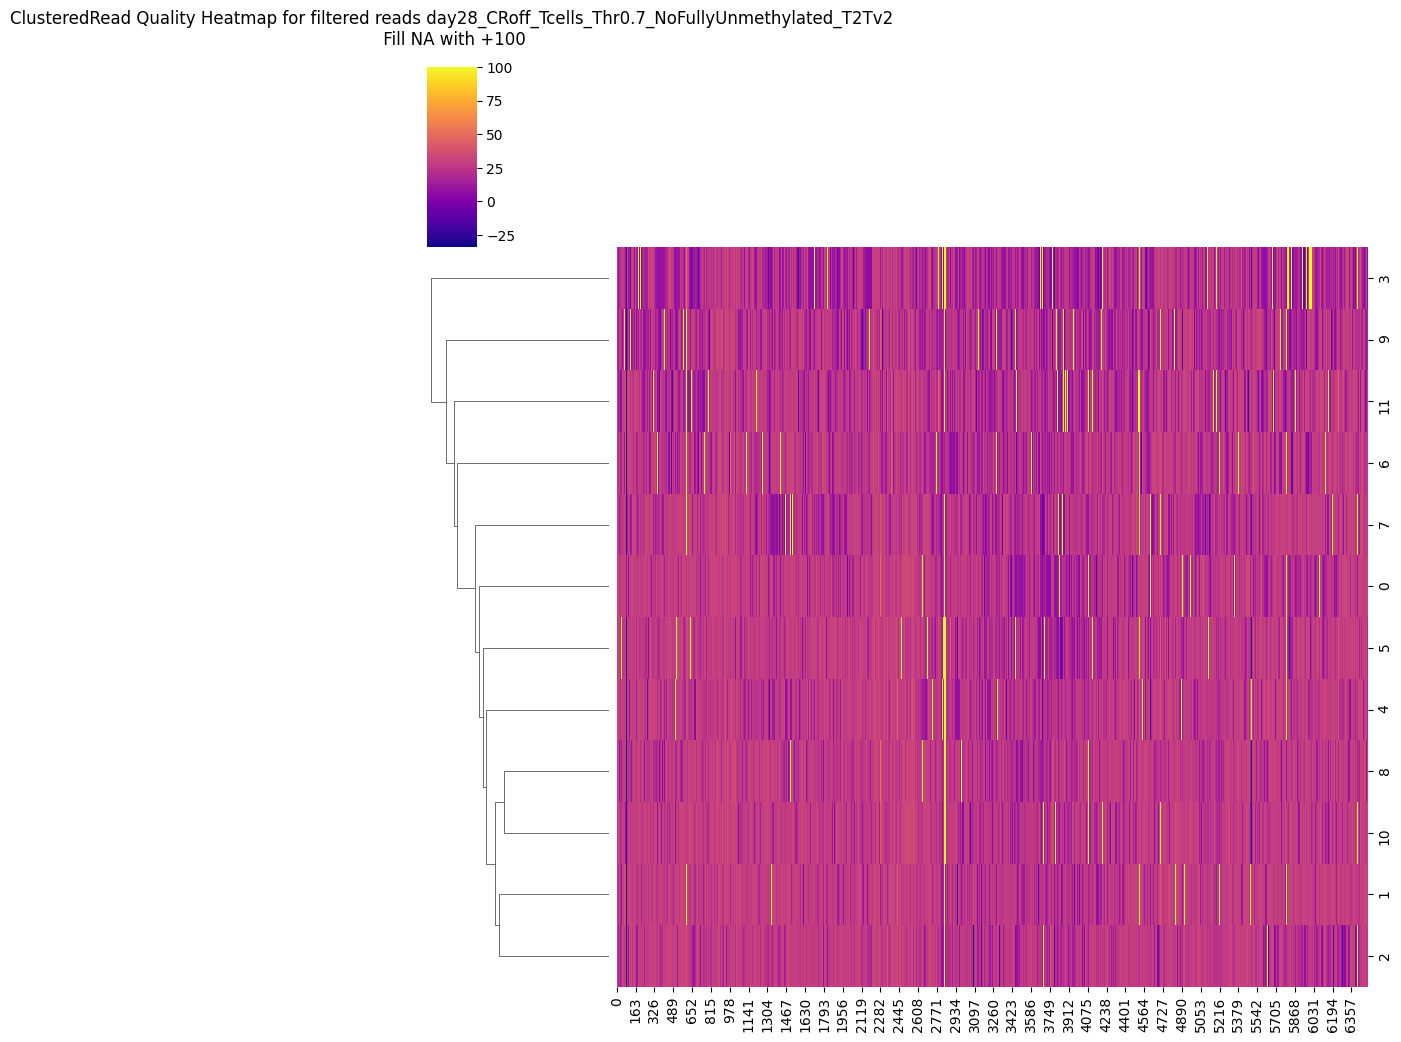

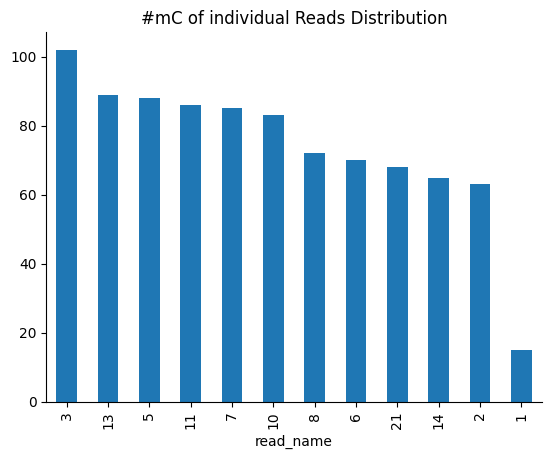

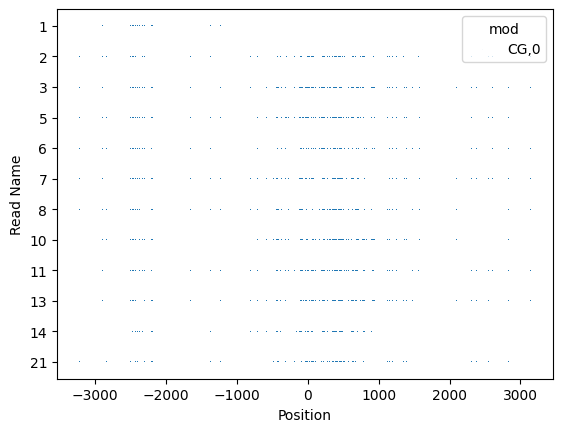

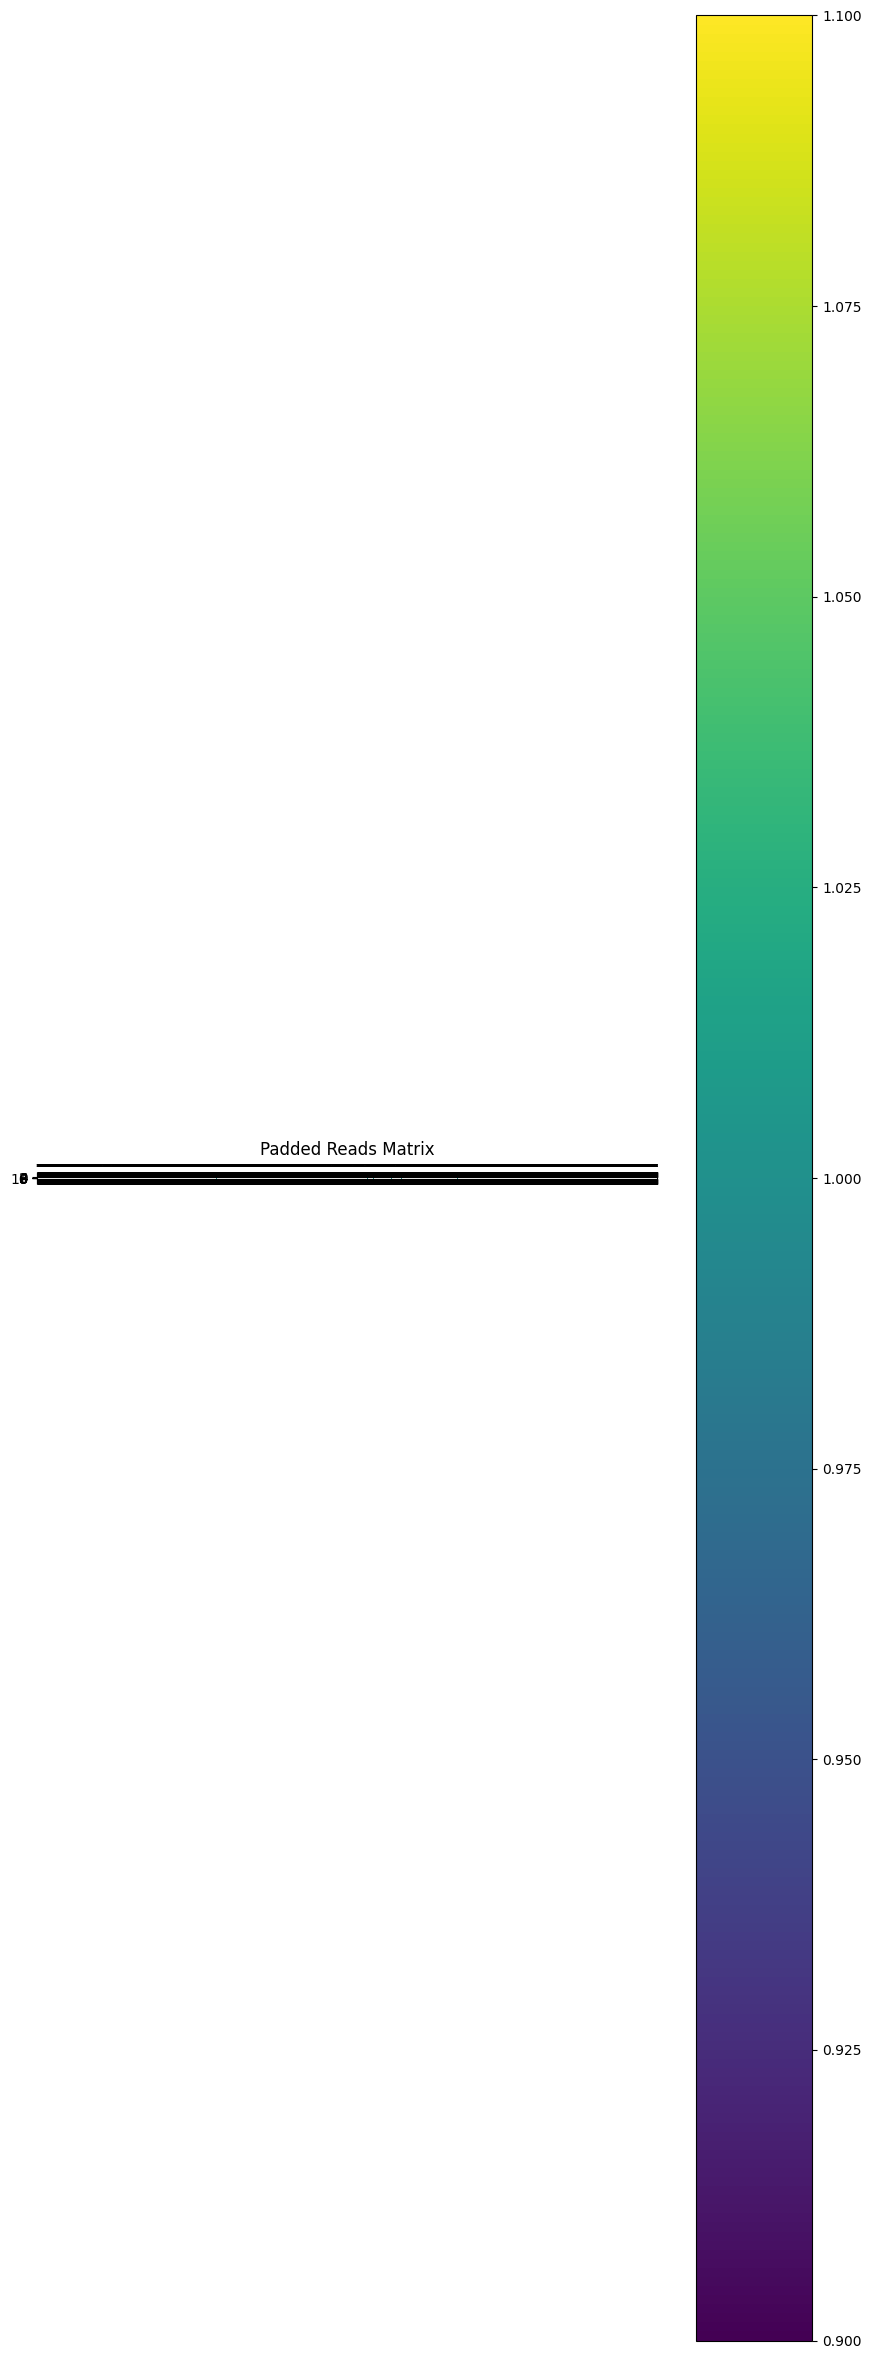

Padded reads saved to padded_reads_day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2_mCthresh0.7_t2t_v2_0_chr1:206583354-206589854_2025-09-07.npy
Padded reads loaded successfully.


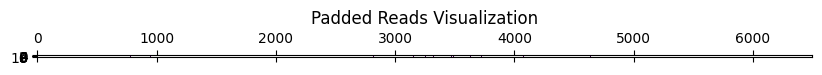

Visualization completed.
Region length: 6500
GTCATTGTATGGTTCCTGGGATAAGAGTAAGAACCGTGGTCCCTTGCTCTGTCAAAATCATAAACCTATTTTCTTTGTATTTTGACTTAATTACATAAGCTTGTTTTGGATTGGAAGGTCTATAGAGACTATTTTAGTGCCAAATGCTATTTAATCAATGCAGAAATAAGCCCTTGAGAGGTGCAGTGACTCAGCTGAGGACACACTGATAGTTTCTGGTAGATAAGTATGAAGCCTTGGAACTACTTCTCATATCATAAGCCCCTGGGTTCCCAAATCACCTCCCCAAGTACCTAATTCATCATCCTCTGCATACAAGAAATTTTTGCTCATTCCAATAAAAAGAATGTAGTACGGCAGGACAGGAGAAGTACAGGTTTTGGAATCAAACTAGGTTTAGATTCTGACCTGGTCGCTAGTTAGTGCATGGGCTTTGGTAAACAGCCTCTCAGCCTGTTTCCTTGTCTGCAAAATATGGATAGTTATCTTCACTTCATGAAGTTGTGTTGGTGAAATGGTATAATGTGTATAAAGCAACTGGAACACAACAAATGAGGCCATTTATTTAAAATAATCTTTAGTAAGTTATAAATTCACATATTTGCTTTTTTCTGAGGAATGCTTAGATTTTATCATAGATCTCTTTTCTAAATTGAGTAAATACATAGTGGATTTCTTTGTTTCCTTCCCCTCAGAATGTTGAAATTTGGCTGATTGTAACTATTACTTAAGACTCTATCCAGTAATTGTTCGTAAAATTTCTTTTCTTTTTTTTTTTTTGAGACGGAGTTTTGCTCTCGTCCCCCAGGCTGGAGTGCAATGGCGCGATCTTGGCTCACTGCAACCTCCGCCTCCCAGGTTCAAGTGATTCTCCCGCCTCAGCCTCCCAAGTAGCTGGGATTACAGGCACCTGCCACAACGCCCAGCCAATTTTTGTATTTTTAGTAGAGACGGG

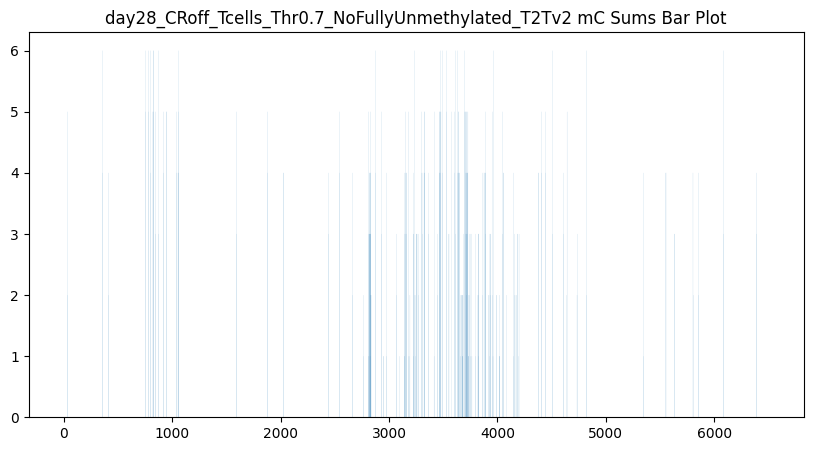

(mC_sums / len(CGs_all) = [0. 0. 0. ... 0. 0. 0.]


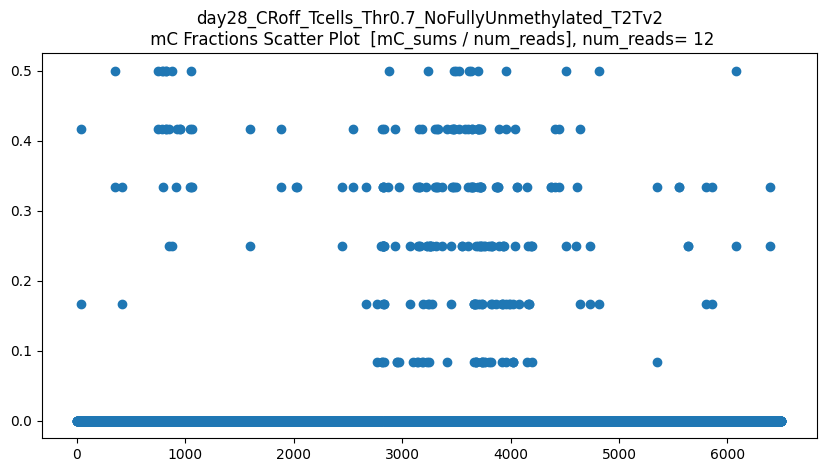

len(CGs_all) = 12
CGs_all.shape = (12, 137)
len(CGs_all_on_fwd_C_sums) = 6500
CGs_all_on_fwd_C_sums.shape = (6500,)


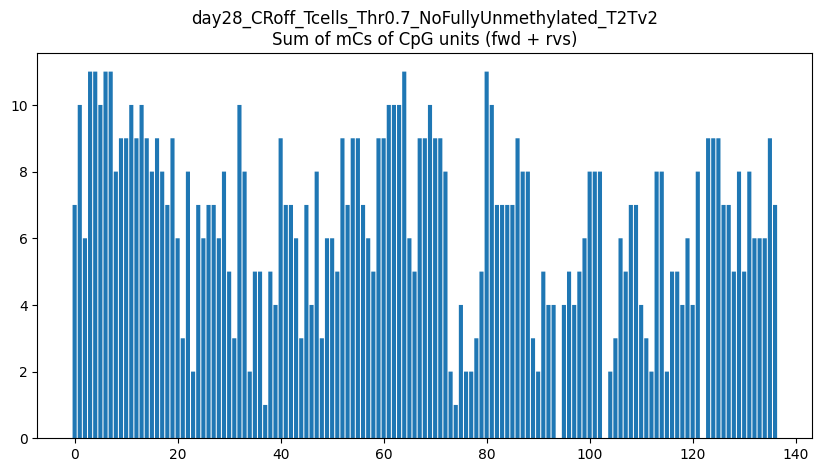

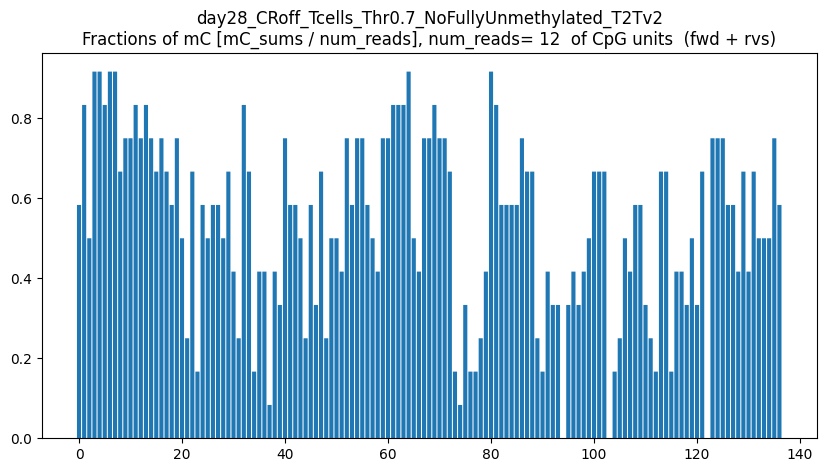

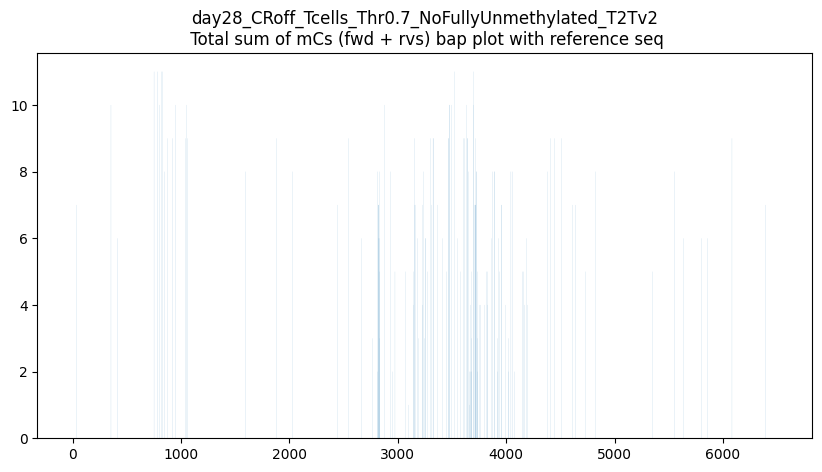

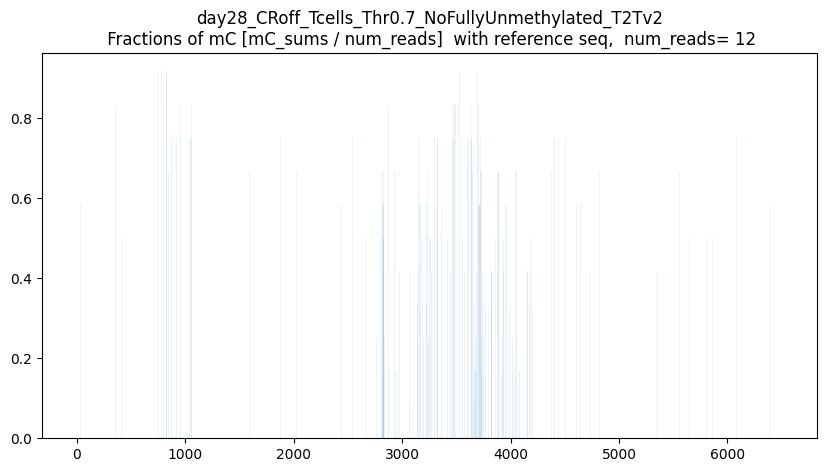

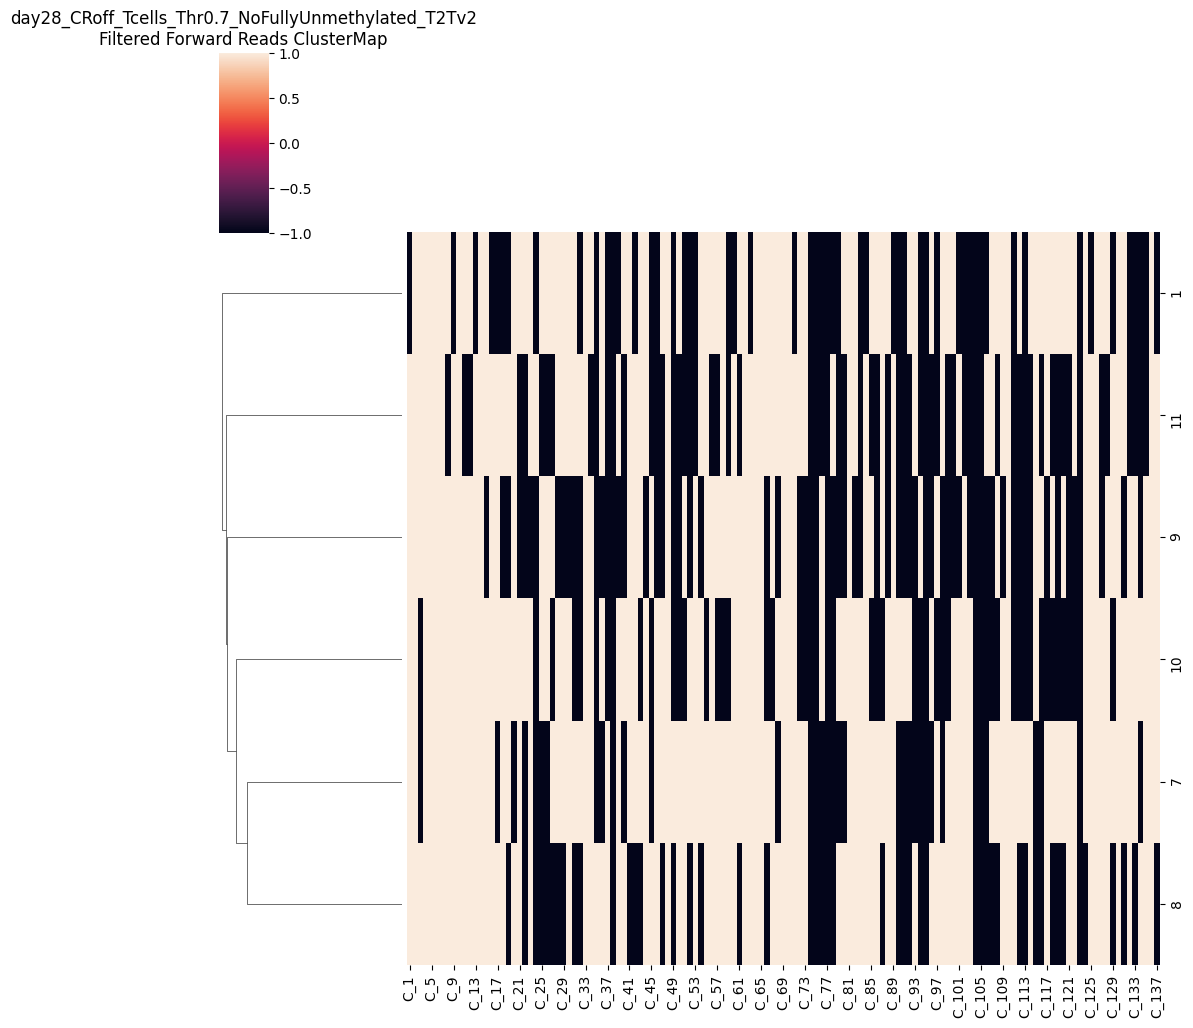

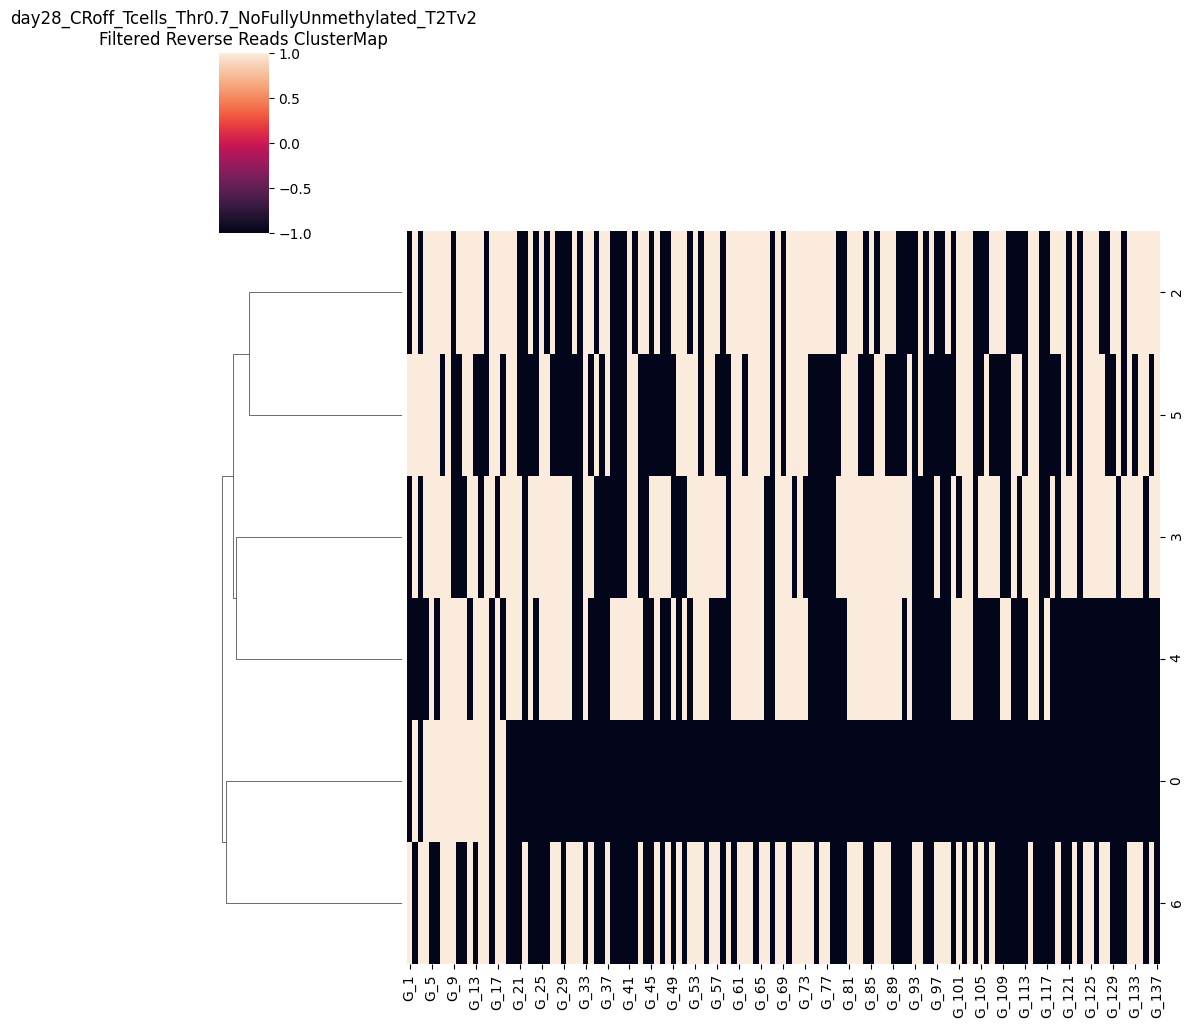

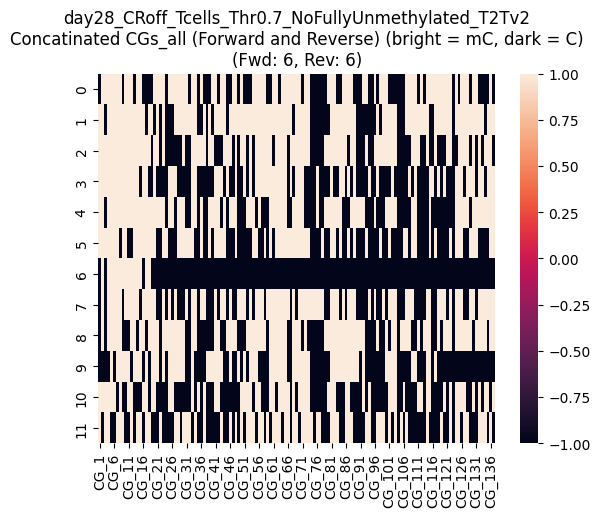

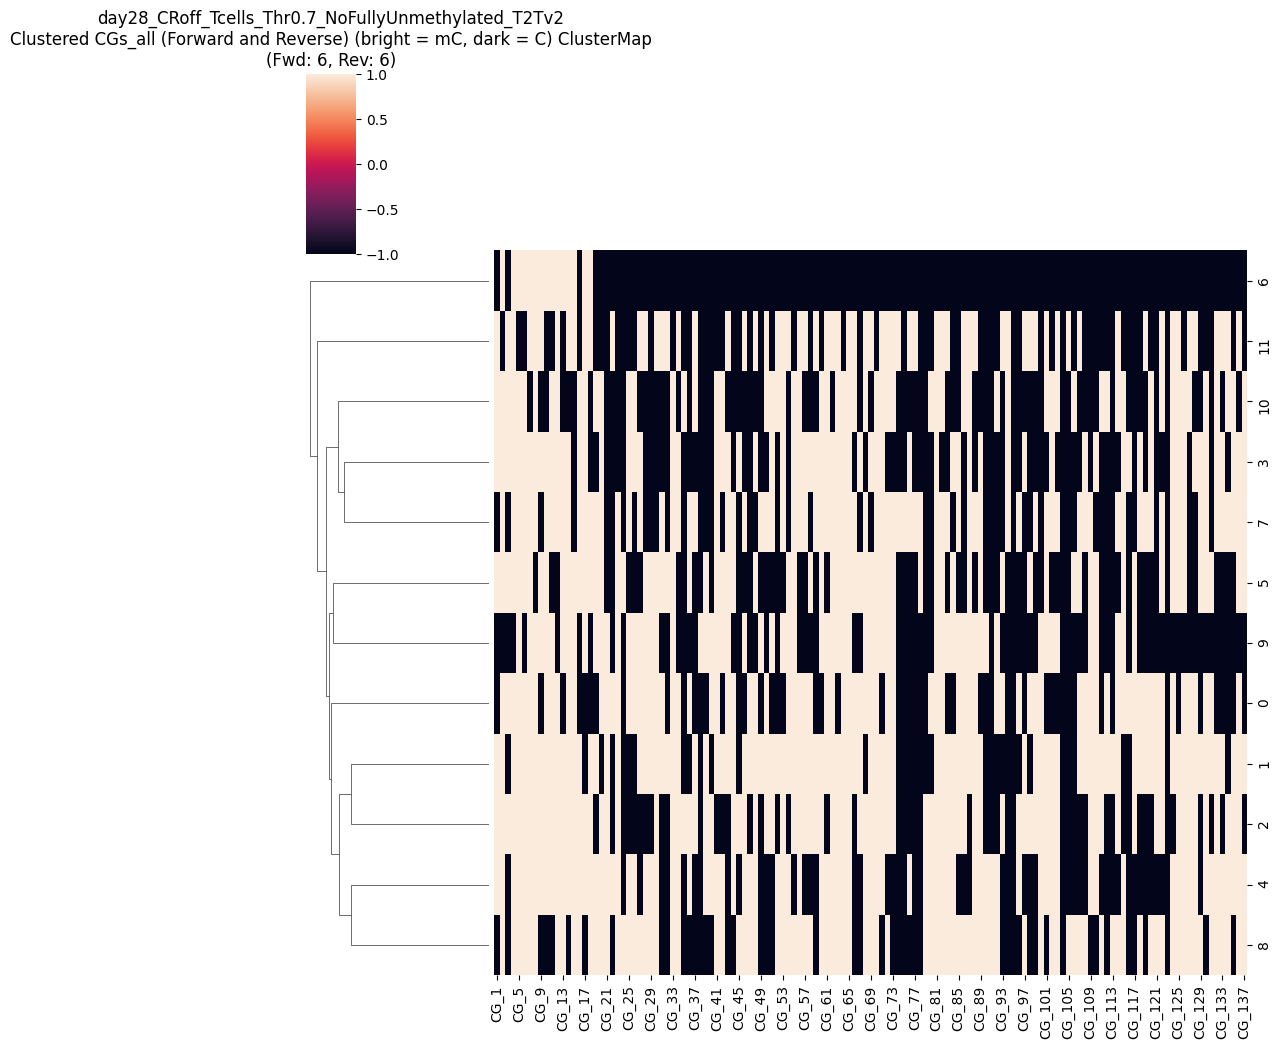

CGs_all saved as CG_137_padded_reads_day28_CRoff_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2_mCthresh0.7_t2t_v2_0_chr1:206583354-206589854_2025-09-07_units_combined_numFWD6_numRVS6.npy in dimelo_v2_output
Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)


In [ ]:
# threshold_mC = 0.7 # 0.995 #0.7 #  0.9 #0.99
# fraction_overlap_aligned_threshold= 0.7 # 0.1
# fraction_mismatches_threshold = 0.7 # 0.5
# # indel_fraction_threshold = 1  # 0.8
# # non_fraction_threshold   = 1

# experiment_name = "day"+str(day_num)+"_CRoff_Tcells_Thr"+str(threshold_mC)+"_NoFullyUnmethylated_T2Tv2"
# bam_path = original_bam_path #  unedit_bam_path

# print('experiment_name = ', experiment_name)

# save_padded_reads_name_np = f"padded_reads_{experiment_name}_mCthresh{threshold_mC}_{reg_genome_version}_{region_str}_{date_today}.npy"
# output_dir = create_output_directory("./dimelo_v2_output")

# extract_file, extract_regions = extract_from_bam(
#     experiment_name = experiment_name,
#     bam_path=bam_path,
#     ref_genome_file=ref_genome_path,
#     output_dir=output_dir,
#     region=region_str,
#     motifs=motifs,
#     output_name='extracted_reads',
#     threshold_mC=threshold_mC,
# )
# keep_full_coverage_reads_only=True

# if extract_file:
#     reads_df, regions_dict = process_extracted_reads(extract_file, bam_path, region_str, 
#         motifs, ref_seq_list, ref_genome_path=ref_genome_path, 
#         experiment_name=experiment_name, output_dir=output_dir, 
#         keep_full_coverage_reads_only=keep_full_coverage_reads_only,
#         fraction_overlap_aligned_threshold=fraction_overlap_aligned_threshold,
#         fraction_mismatches_threshold=fraction_mismatches_threshold)
#         # indel_fraction_threshold=indel_fraction_threshold, 
#         # non_fraction_threshold=non_fraction_threshold)
        
#     visualize_data(reads_df)

#     padded_reads = create_padded_reads(reads_df, regions_dict, region_length)
#     if padded_reads is not None:
#         plot_padded_reads(padded_reads, ref_seq_list)
#         save_padded_reads(padded_reads, output_dir, save_padded_reads_name_np)

# # Processing and visualizing CpG units on forward and reverse strands 
# try: 

#     # Process pipeline
#     CGs_all, C_fwd_df, G_revs_df, padded_reads_df, CG_pair_idx, CG_coordinates, CG_info_df = analize_forward_reverse_CGs_pipeline(
#         experiment_name=experiment_name, save_folder_path=output_dir, 
#         save_padded_reads_name_np=save_padded_reads_name_np, 
#         ref_genome_file=ref_genome_path, region_chr=region_chr, region_start=region_start, region_end=region_end
#     )

#     print("Pipeline executed successfully (analize_forward_reverse_CGs_pipeline function)")
#     # return CGs_all, C_fwd_df, G_revs_df, padded_reads_df

# except Exception as e:
#     print(f"Error in main pipeline (analize_forward_reverse_CGs_pipeline function): {e}")


In [8]:
reads_df

read_name_str read_name read_id_number   mod  \
0    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
1    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
2    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
3    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
4    c758517d-05c4-4357-8457-6526c65c72a0         2              2  CG,0   
..                                    ...       ...            ...   ...   
451  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
452  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
453  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
454  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
455  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   

      pos  read_lengths  mapping_qualities  avg_base_qualities  \
0   -2897          6790                 60           24.387482   
1   -2500          6790                 60           24.387482   
2   -2332          6790                 60           24.387482   
3   -2193          6790                 60           24.387482   
4   -2897          6766                 60           26.344073   
..    ...           ...                ...                 ...   
451   921          6768                 60           22.379580   
452  1157          6768                 60           22.379580   
453  2304          6768                 60           22.379580   
454  2386          6768                 60           22.379580   
455  2554          6768                 60           22.379580   

     num_overlap_aligned_bases  fraction_overlap_aligned  num_nones  \
0                         6404                  0.985231        102   
1                         6404                  0.985231        102   
2                         6404                  0.985231        102   
3                         6404                  0.985231        102   
4                         6436                  0.990154         64   
..                         ...                       ...        ...   
451                       6352                  0.977231        151   
452                       6352                  0.977231        151   
453                       6352                  0.977231        151   
454                       6352                  0.977231        151   
455                       6352                  0.977231        151   

     fraction_nones  num_inserts  fraction_inserts  num_mismatches  \
0          0.015022          110          0.016200              48   
1          0.015022          110          0.016200              48   
2          0.015022          110          0.016200              48   
3          0.015022          110          0.016200              48   
4          0.009459           50          0.007390              30   
..              ...          ...               ...             ...   
451        0.022311          149          0.022015              86   
452        0.022311          149          0.022015              86   
453        0.022311          149          0.022015              86   
454        0.022311          149          0.022015              86   
455        0.022311          149          0.022015              86   

     fraction_mismatches  num_ambiguous  pos_shifted  
0               0.007069              0          353  
1               0.007069              0          750  
2               0.007069              0          918  
3               0.007069              0         1057  
4               0.004434              0          353  
..                   ...            ...          ...  
451             0.012707              0         4171  
452             0.012707              0         4407  
453             0.012707              0         5554  
454             0.012707              0         5636  
455             0.01270

(array([3., 0., 3., 1., 2., 0., 0., 1., 0., 1.]),
 array([0.00325299, 0.00456823, 0.00588346, 0.0071987 , 0.00851393,
        0.00982917, 0.0111444 , 0.01245964, 0.01377487, 0.01509011,
        0.01640534]),
 <BarContainer object of 10 artists>)

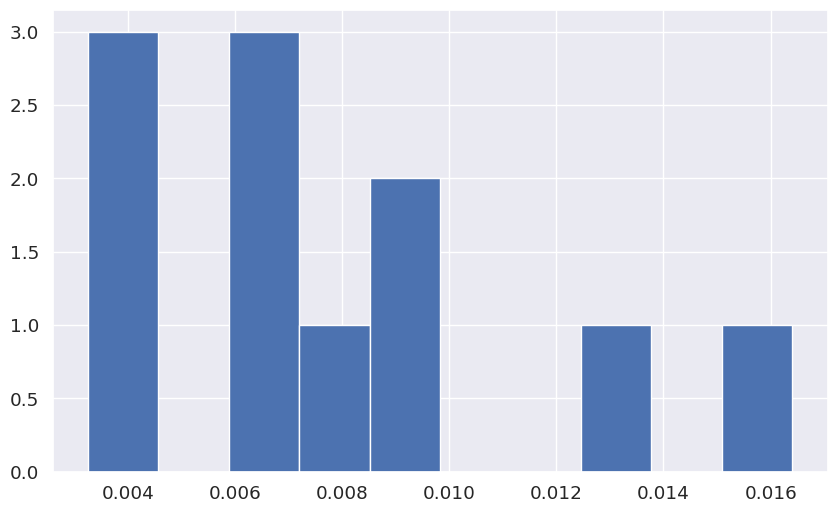

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(np.unique(reads_df['fraction_mismatches']))

(array([1., 1., 1., 0., 0., 0., 3., 1., 1., 3.]),
 array([0.974     , 0.97569231, 0.97738462, 0.97907692, 0.98076923,
        0.98246154, 0.98415385, 0.98584615, 0.98753846, 0.98923077,
        0.99092308]),
 <BarContainer object of 10 artists>)

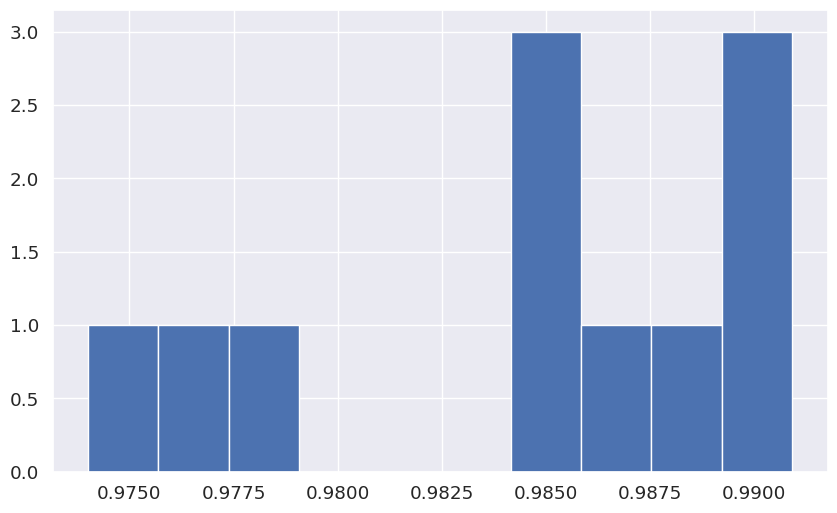

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(np.unique(reads_df['fraction_overlap_aligned']))

In [11]:
np.unique(reads_df['num_nones'])

array([ 59,  64,  71,  76,  89, 102, 103, 104, 151, 152, 180])

In [12]:
# np.unique(reads_df['num_indels'])

In [13]:
# np.unique(reads_df['nones_fraction'])

In [14]:
# np.unique(reads_df['indel_fraction'])

In [15]:
reads_df

read_name_str read_name read_id_number   mod  \
0    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
1    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
2    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
3    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
4    c758517d-05c4-4357-8457-6526c65c72a0         2              2  CG,0   
..                                    ...       ...            ...   ...   
451  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
452  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
453  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
454  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
455  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   

      pos  read_lengths  mapping_qualities  avg_base_qualities  \
0   -2897          6790                 60           24.387482   
1   -2500          6790                 60           24.387482   
2   -2332          6790                 60           24.387482   
3   -2193          6790                 60           24.387482   
4   -2897          6766                 60           26.344073   
..    ...           ...                ...                 ...   
451   921          6768                 60           22.379580   
452  1157          6768                 60           22.379580   
453  2304          6768                 60           22.379580   
454  2386          6768                 60           22.379580   
455  2554          6768                 60           22.379580   

     num_overlap_aligned_bases  fraction_overlap_aligned  num_nones  \
0                         6404                  0.985231        102   
1                         6404                  0.985231        102   
2                         6404                  0.985231        102   
3                         6404                  0.985231        102   
4                         6436                  0.990154         64   
..                         ...                       ...        ...   
451                       6352                  0.977231        151   
452                       6352                  0.977231        151   
453                       6352                  0.977231        151   
454                       6352                  0.977231        151   
455                       6352                  0.977231        151   

     fraction_nones  num_inserts  fraction_inserts  num_mismatches  \
0          0.015022          110          0.016200              48   
1          0.015022          110          0.016200              48   
2          0.015022          110          0.016200              48   
3          0.015022          110          0.016200              48   
4          0.009459           50          0.007390              30   
..              ...          ...               ...             ...   
451        0.022311          149          0.022015              86   
452        0.022311          149          0.022015              86   
453        0.022311          149          0.022015              86   
454        0.022311          149          0.022015              86   
455        0.022311          149          0.022015              86   

     fraction_mismatches  num_ambiguous  pos_shifted  
0               0.007069              0          353  
1               0.007069              0          750  
2               0.007069              0          918  
3               0.007069              0         1057  
4               0.004434              0          353  
..                   ...            ...          ...  
451             0.012707              0         4171  
452             0.012707              0         4407  
453             0.012707              0         5554  
454             0.012707              0         5636  
455             0.01270

In [16]:
reads_df.shape

(401, 18)

# Threshold 80%*mean(mC in alll reads)

In [17]:
threshold_percent = 80
filtered_reads_df, methylation_counts, remove_reads_df = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

Mean methylated CGs per read: 33.0
Maximum methylated CGs per read: 74.0
Threshold (80% of max): 26.40
Original number of reads: 11
Number of reads after filtering: 9
Removed 2 reads


read_name_str read_name read_id_number   mod  \
4    c758517d-05c4-4357-8457-6526c65c72a0         2              2  CG,0   
5    c758517d-05c4-4357-8457-6526c65c72a0         2              2  CG,0   
6    c758517d-05c4-4357-8457-6526c65c72a0         2              2  CG,0   
7    c758517d-05c4-4357-8457-6526c65c72a0         2              2  CG,0   
8    c758517d-05c4-4357-8457-6526c65c72a0         2              2  CG,0   
..                                    ...       ...            ...   ...   
434  57b38588-021d-4039-bce7-6a1324d97628        14             14  CG,0   
435  57b38588-021d-4039-bce7-6a1324d97628        14             14  CG,0   
436  57b38588-021d-4039-bce7-6a1324d97628        14             14  CG,0   
437  57b38588-021d-4039-bce7-6a1324d97628        14             14  CG,0   
438  57b38588-021d-4039-bce7-6a1324d97628        14             14  CG,0   

      pos  read_lengths  mapping_qualities  avg_base_qualities  \
4   -2897          6766                 60           26.344073   
5   -2500          6766                 60           26.344073   
6   -2467          6766                 60           26.344073   
7   -2426          6766                 60           26.344073   
8   -1658          6766                 60           26.344073   
..    ...           ...                ...                 ...   
434   612          6738                 60           26.087415   
435   626          6738                 60           26.087415   
436   637          6738                 60           26.087415   
437   709          6738                 60           26.087415   
438   793          6738                 60           26.087415   

     num_overlap_aligned_bases  fraction_overlap_aligned  num_nones  \
4                         6436                  0.990154         64   
5                         6436                  0.990154         64   
6                         6436                  0.990154         64   
7                         6436                  0.990154         64   
8                         6436                  0.990154         64   
..                         ...                       ...        ...   
434                       6430                  0.989231         71   
435                       6430                  0.989231         71   
436                       6430                  0.989231         71   
437                       6430                  0.989231         71   
438                       6430                  0.989231         71   

     fraction_nones  num_inserts  fraction_inserts  num_mismatches  \
4          0.009459           50          0.007390              30   
5          0.009459           50          0.007390              30   
6          0.009459           50          0.007390              30   
7          0.009459           50          0.007390              30   
8          0.009459           50          0.007390              30   
..              ...          ...               ...             ...   
434        0.010537           47          0.006975              29   
435        0.010537           47          0.006975              29   
436        0.010537           47          0.006975              29   
437        0.010537           47          0.006975              29   
438        0.010537           47          0.006975              29   

     fraction_mismatches  num_ambiguous  pos_shifted  num_CG_methylated  
4               0.004434              0          353                1.0  
5               0.004434              0          750                1.0  
6               0.004434              0          783                1.0  
7               0.004434              0          824                1.0  
8               0.004434              0         1592                1.0  
..                   ...            ...          ...                ...  
434             0.004304              0         3862                1.0  
435             0.004304            

In [18]:
remove_reads_df

read_name_str read_name read_id_number   mod  \
0    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
1    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
2    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
3    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
439  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
440  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
441  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
442  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
443  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
444  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
445  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
446  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
447  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
448  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
449  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
450  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
451  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
452  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
453  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
454  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
455  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   

      pos  read_lengths  mapping_qualities  avg_base_qualities  \
0   -2897          6790                 60           24.387482   
1   -2500          6790                 60           24.387482   
2   -2332          6790                 60           24.387482   
3   -2193          6790                 60           24.387482   
439 -2426          6768                 60           22.379580   
440 -1225          6768                 60           22.379580   
441  -421          6768                 60           22.379580   
442  -419          6768                 60           22.379580   
443     3          6768                 60           22.379580   
444    79          6768                 60           22.379580   
445   218          6768                 60           22.379580   
446   228          6768                 60           22.379580   
447   302          6768                 60           22.379580   
448   353          6768                 60           22.379580   
449   361          6768                 60           22.379580   
450   570          6768                 60           22.379580   
451   921          6768                 60           22.379580   
452  1157          6768                 60           22.379580   
453  2304          6768                 60           22.379580   
454  2386          6768                 60           22.379580   
455  2554          6768                 60           22.379580   

     num_overlap_aligned_bases  fraction_overlap_aligned  num_nones  \
0                         6404                  0.985231        102   
1                         6404                  0.985231        102   
2                         6404                  0.985231        102   
3                         6404                  0.985231        102   
439                       6352                  0.977231        151   
440                       6352                  0.977231        151   
441                       6352                  0.977231        151   
442                       6352                  0.977231        151   
443                       6352                  0.977231        151   
444                       6352                  0.977231        151   
445                       6352                  0.977231        151   
446                       6352                  0.

In [19]:
bam_path

'/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_CROFF_Day28/mergered_outputs/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20250721_Day28_CROFF_T_cells_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam'

In [20]:
!pwd

/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads


In [21]:
# output_dir_path = '/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/' # "/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/"
removed_reads_bam_name = "reads_with_mC_less_than_mean_x_" +  str(threshold_percent) + "_" + experiment_name +".bam"
removed_output_bam_path=Path(output_dir_path, removed_reads_bam_name)
removed_output_bam_path

PosixPath('/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/reads_with_mC_less_than_mean_x_80_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam')

In [22]:
subset_BAM_by_read_IDs(original_bam_path, remove_reads_df, output_bam_path=removed_output_bam_path, index_output=True)


Subset BAM written to: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/reads_with_mC_less_than_mean_x_80_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam
Index written to: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/reads_with_mC_less_than_mean_x_80_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam.bai


PosixPath('/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/reads_with_mC_less_than_mean_x_80_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam')

# Save filtered reads to BAM

In [23]:
# output_dir_path = "/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/outputs"
removed_reads_bam_name = "filtered_reads_with_mC_MORE_than_mean_x_" +  str(threshold_percent) + "_" + experiment_name +".bam"
filtered_output_bam_path=Path(output_dir_path, removed_reads_bam_name)
filtered_output_bam_path

PosixPath('/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_80_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam')

In [24]:
subset_BAM_by_read_IDs(original_bam_path, filtered_reads_df, output_bam_path=filtered_output_bam_path, index_output=True)


Subset BAM written to: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_80_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam
Index written to: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_80_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam.bai


PosixPath('/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_80_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam')

In [25]:
sam_path = bam_to_sam(filtered_output_bam_path, sam_path=None)
sam_path

Converted BAM → SAM: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_80_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.sam


PosixPath('/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_80_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.sam')

In [26]:
# sam_path = bam_to_sam(removed_output_bam_path, sam_path=None)
# sam_path
# removed_reads_bam_path = '/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/reads_with_mC_less_than_mean_x_50_day6_unedited_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam'
# removed_reads_bam_path
# plot_bam_quality_metrics(removed_reads_bam_path)

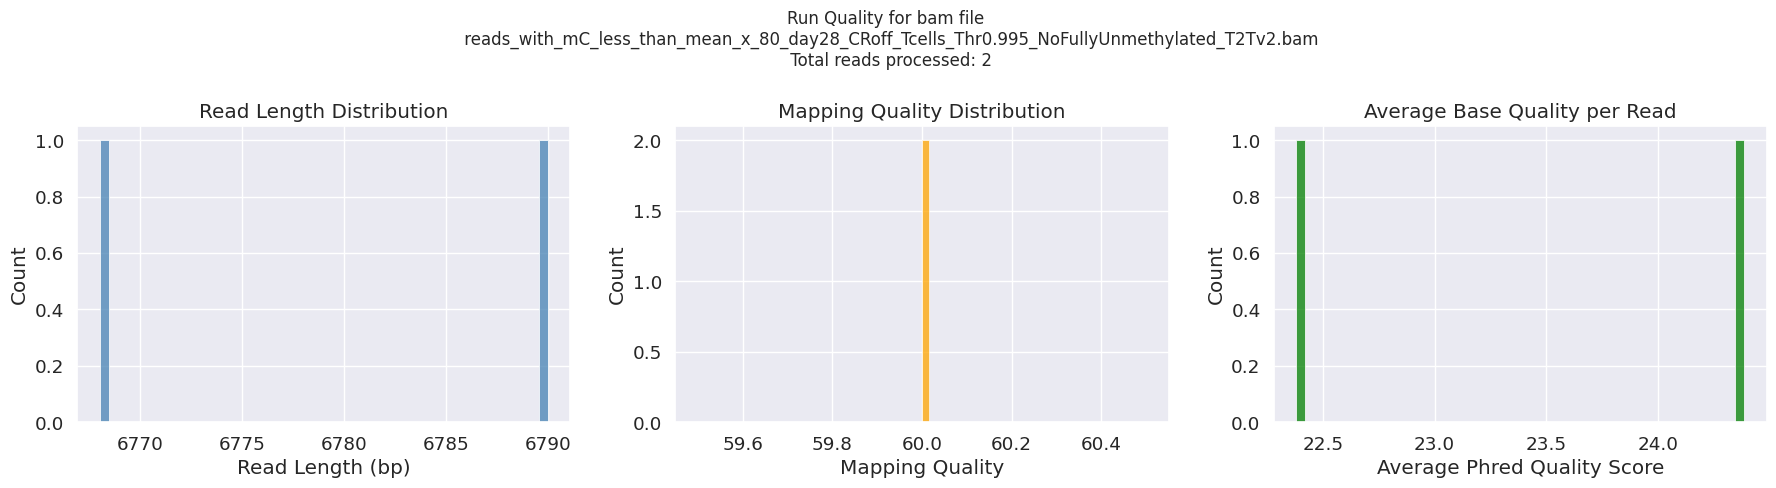

Total reads processed: 2


In [27]:

plot_bam_quality_metrics(removed_output_bam_path)

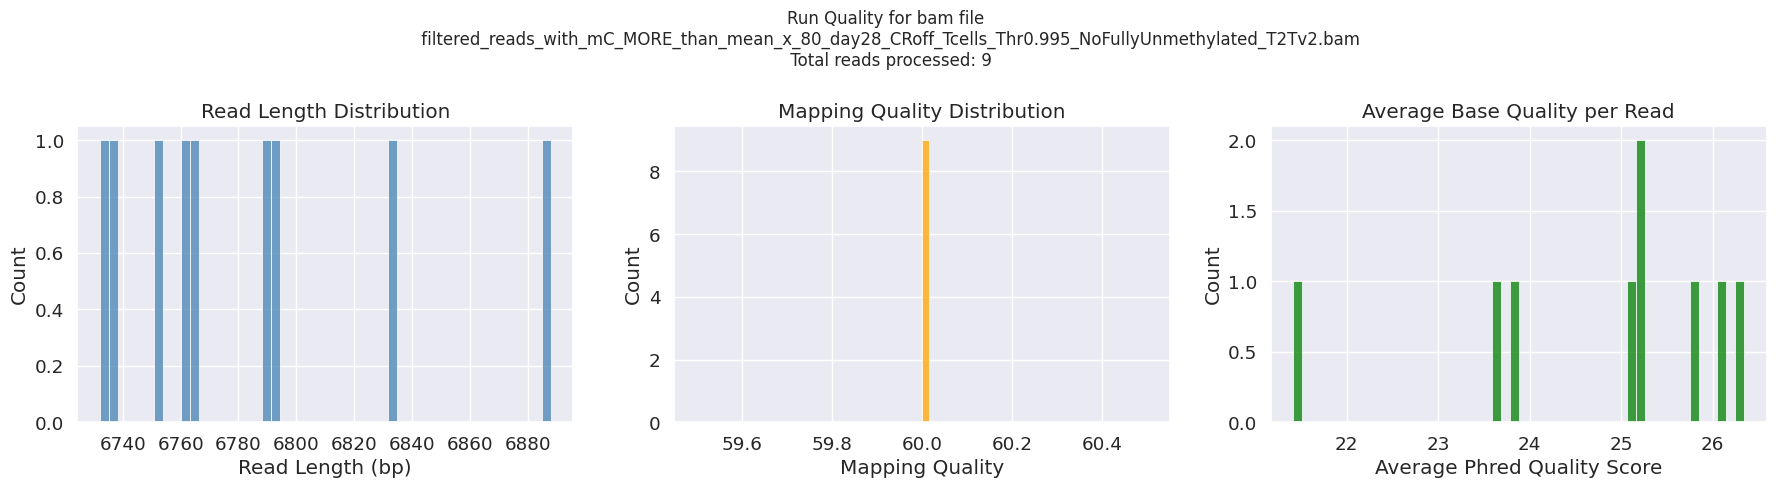

Total reads processed: 9


In [28]:
plot_bam_quality_metrics(filtered_output_bam_path)

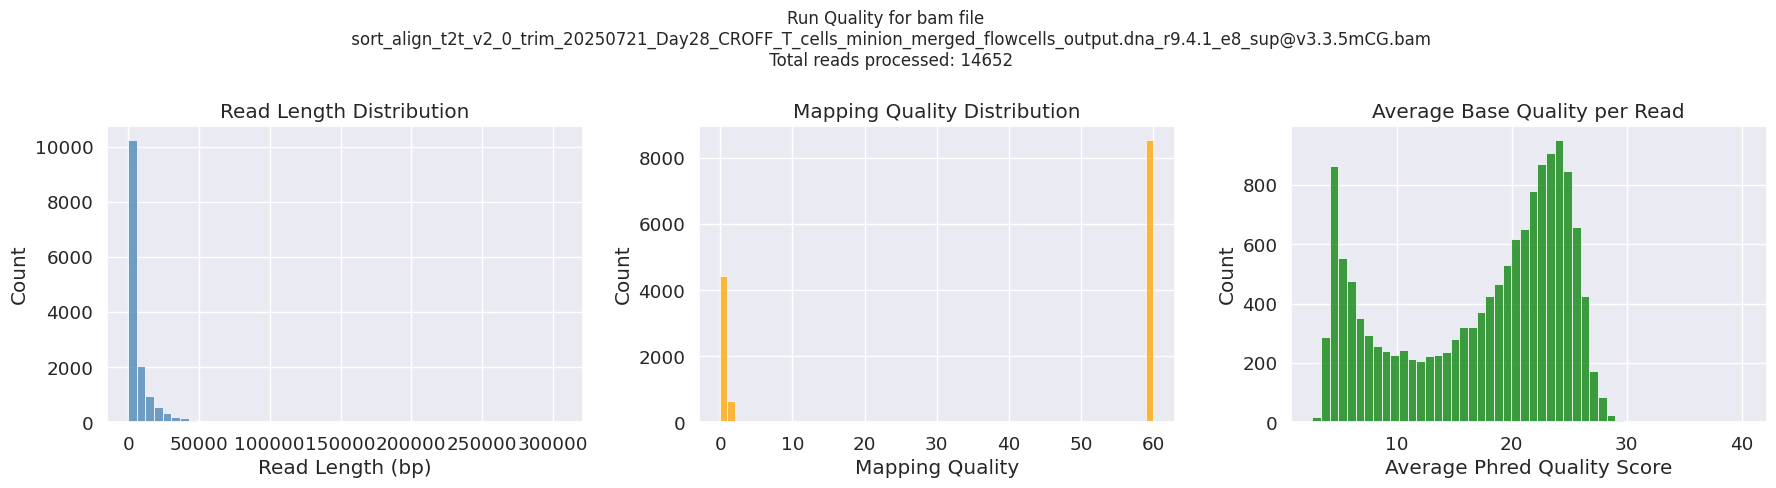

Total reads processed: 14652


In [29]:
plot_bam_quality_metrics(original_bam_path)

# Load BAM files

In [30]:
# removed_reads_bam_path= '/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/reads_with_mC_less_than_mean_x_50_day6_unedited_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam'
# removed_reads_bam_path
# plot_bam_quality_metrics(removed_reads_bam_path)

In [31]:
region_str

'chr1:206583354-206589854'

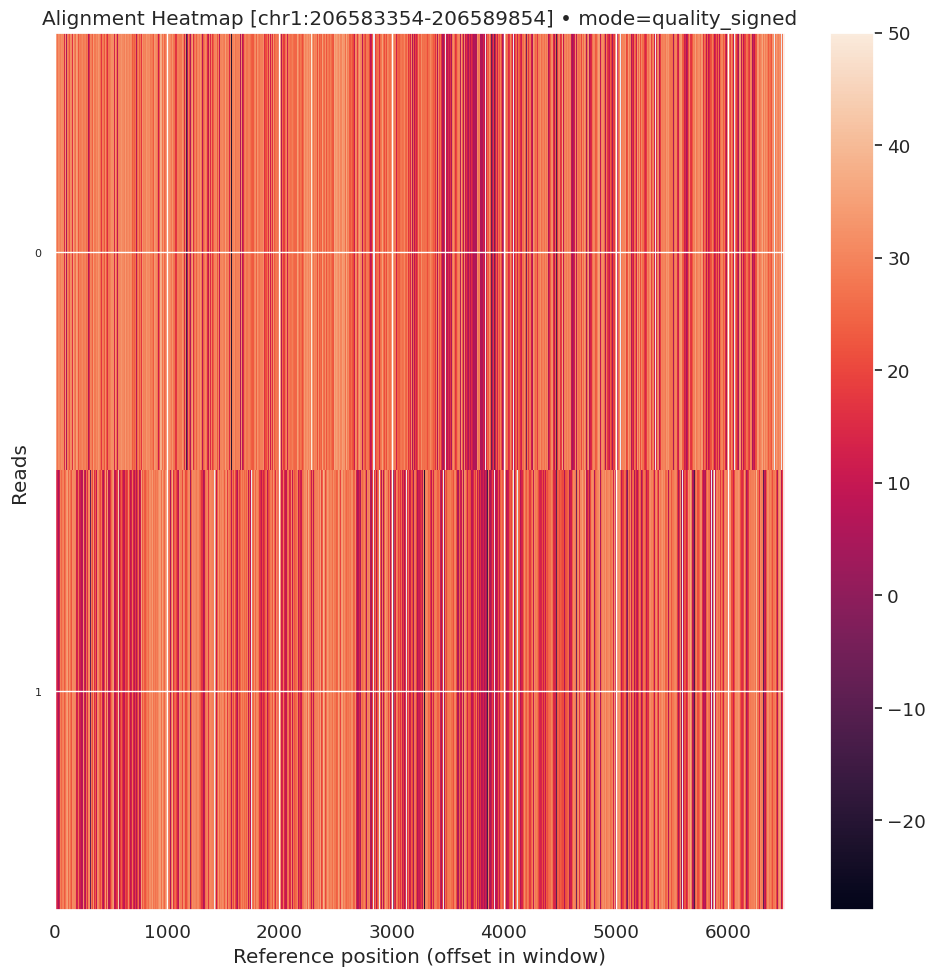

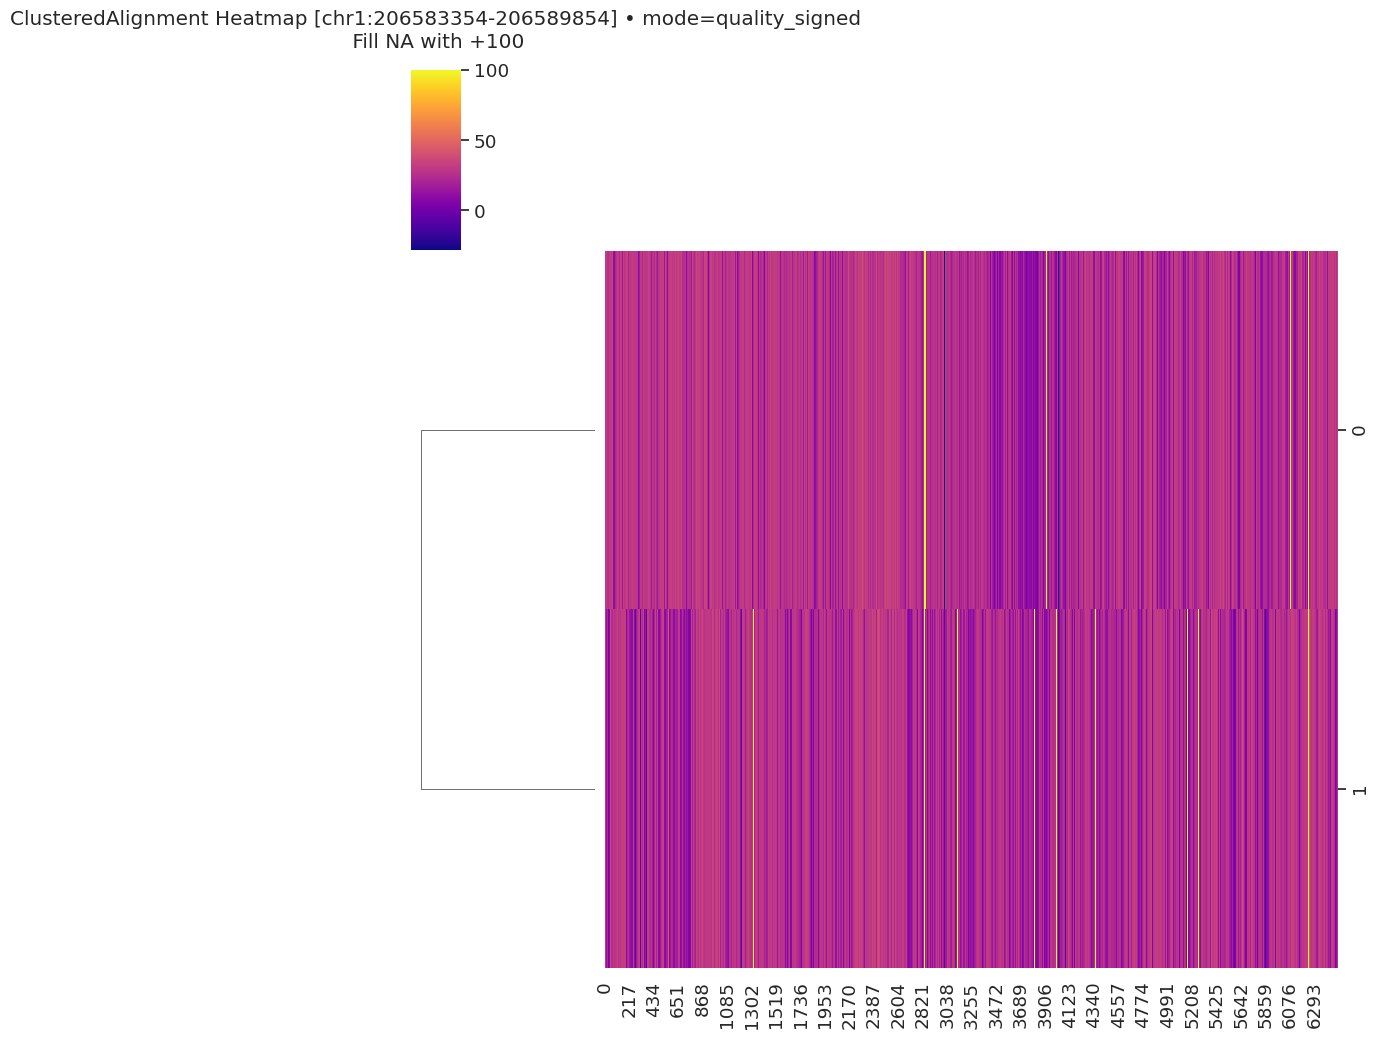

In [32]:
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams


bam = removed_output_bam_path # removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)

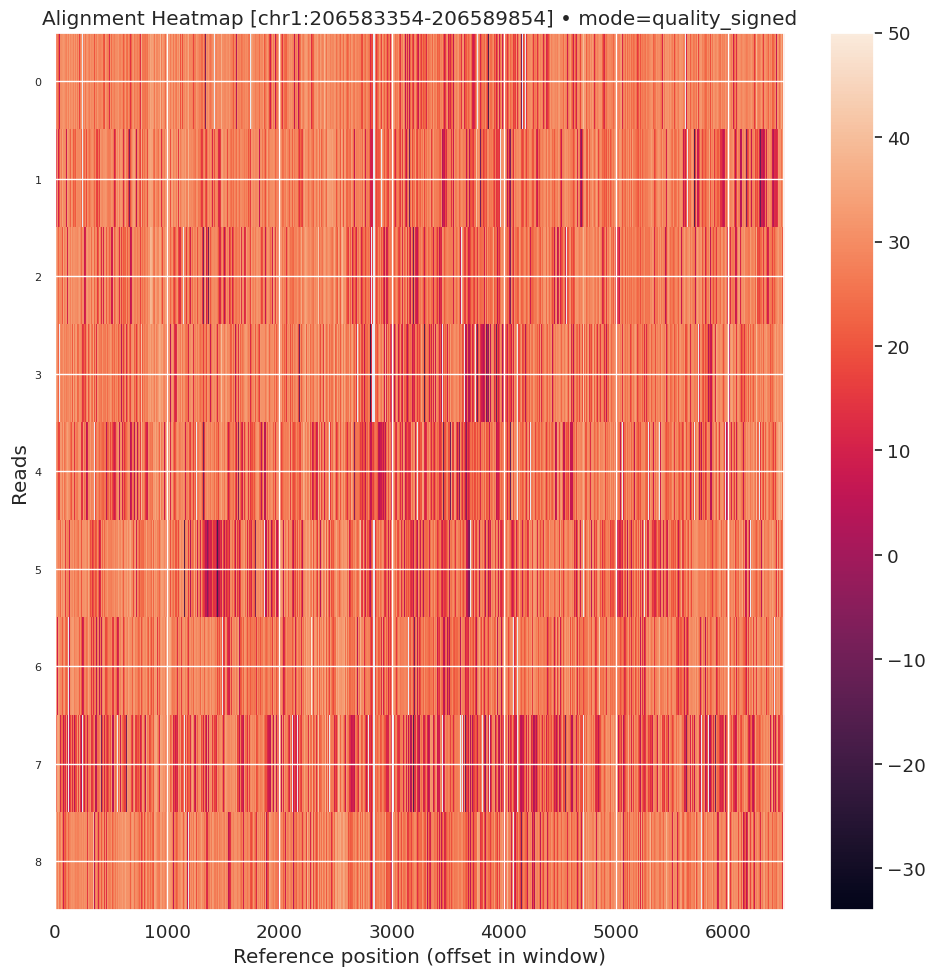

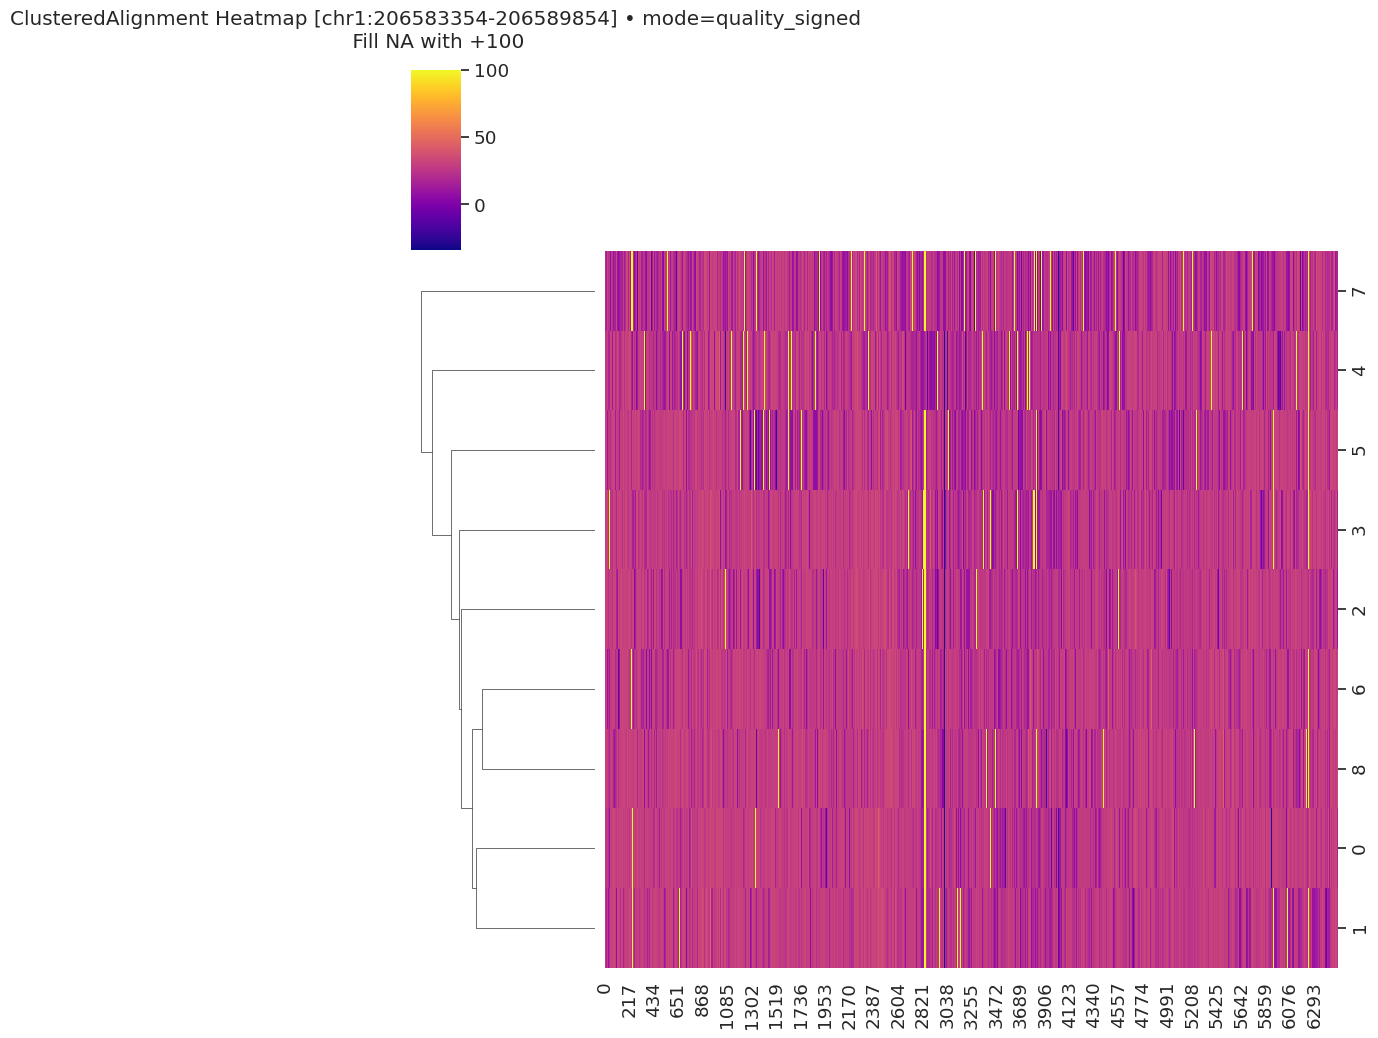

In [33]:


sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams

bam = filtered_output_bam_path  #  removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)



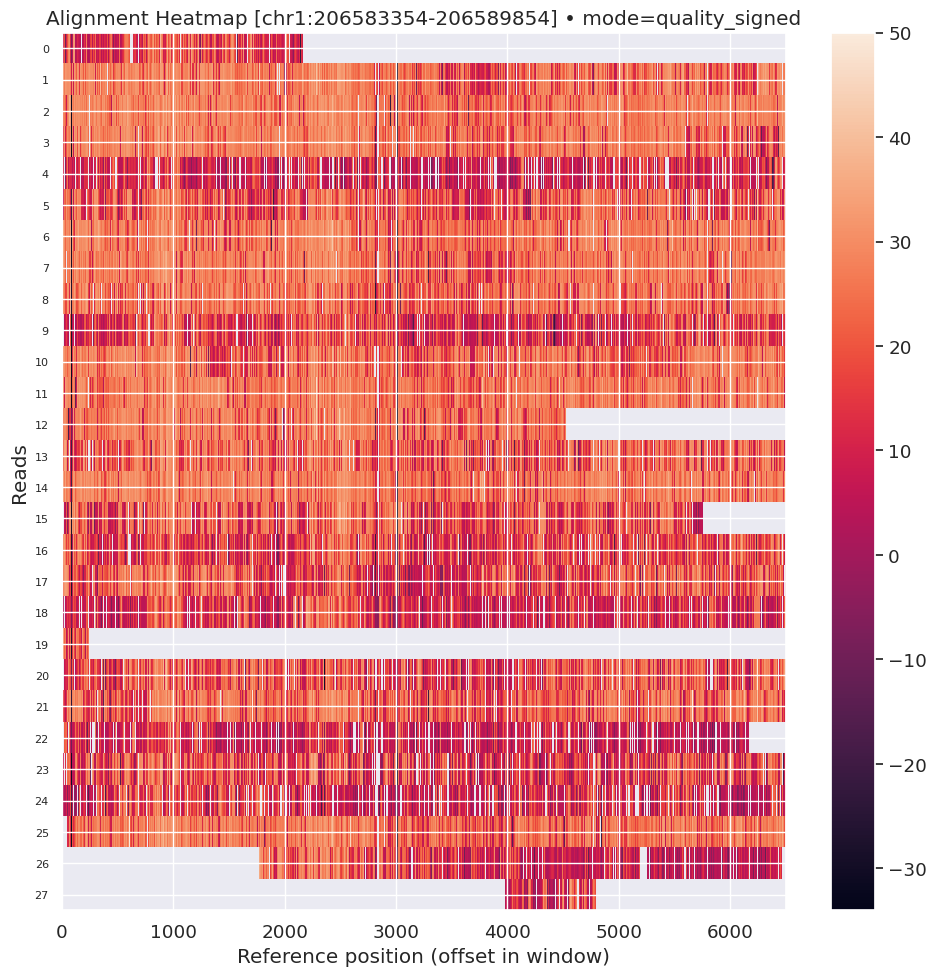

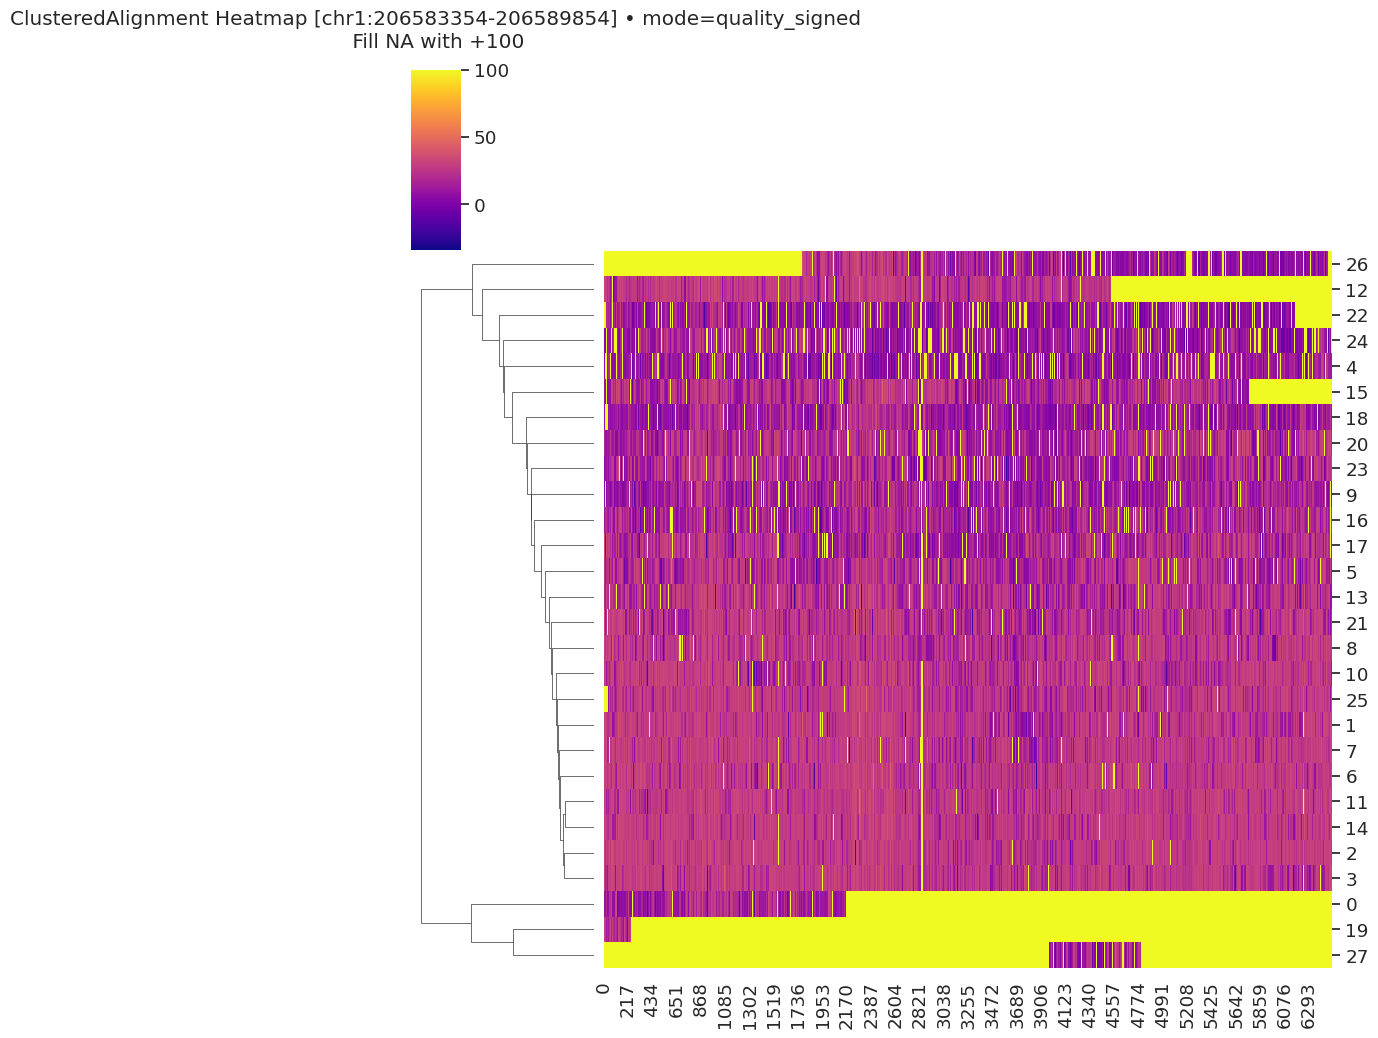

In [34]:
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams

bam = original_bam_path #  unedit_bam_path # removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)


# Get read #27 start and end coordinates:

In [35]:
import pysam

bam_path = "/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_CROFF_Day28/mergered_outputs/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20250721_Day28_CROFF_T_cells_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam"
with pysam.AlignmentFile(bam_path, "rb") as bamfile:
    for i, read in enumerate(bamfile):
        if i == 0:
            print(f"Read 0: {read.query_name}, start: {read.reference_start}, end: {read.reference_end}")
        if i == 16:
            print(f"Read 16: {read.query_name}, start: {read.reference_start}, end: {read.reference_end}")
            
        if i == 27:
            print(f"Read 27: {read.query_name}, start: {read.reference_start}, end: {read.reference_end}")
            break


Read 0: 480da1c8-0f2e-4fd4-922f-3c9e4d058434, start: 51791, end: 62486
Read 16: f1afd653-3b6c-464a-84c9-4340cfa78efa, start: 2257538, end: 2264425
Read 27: d67195fa-1c2f-4354-864e-9f51788bf8ef, start: 3335363, end: 3338603


In [36]:

import pysam

bam_path = str(bam_path)  # Ensure bam_path is a string if it's a Path object

read_name = "a18a8888-b8f5-4be5-bd58-504a07241f92"

with pysam.AlignmentFile(bam_path, "rb") as bamfile:
    for i, read in enumerate(bamfile):
        if read.query_name == read_name:
            print(f"Read Index Number: {i}")
            print(f"Read name: {read.query_name}")
            print(f"Reference name: {bamfile.get_reference_name(read.reference_id)}")
            print(f"Start: {read.reference_start}")
            print(f"End: {read.reference_end}")
            print(f"Mapping quality:  {read.mapping_quality}")
            print(f"Is reverse: {read.is_reverse}")
            break

Read Index Number: 923
Read name: a18a8888-b8f5-4be5-bd58-504a07241f92
Reference name: chr1
Start: 206587329
End: 206588147
Mapping quality:  40
Is reverse: False


In [37]:
get_read_info_by_index(original_bam_path, 0)

Read Index Number: 0
Read name: 480da1c8-0f2e-4fd4-922f-3c9e4d058434
Reference name: chr1
Start: 51791
End: 62486
Mapping quality:  0
Is reverse: False


In [38]:
get_read_info_by_name(original_bam_path, "a18a8888-b8f5-4be5-bd58-504a07241f92")

Read Index Number: 923
Read name: a18a8888-b8f5-4be5-bd58-504a07241f92
Reference name: chr1
Start: 206587329
End: 206588147
Mapping quality:  40
Is reverse: False


In [39]:
get_read_info_by_index(original_bam_path, 923)

Read Index Number: 923
Read name: a18a8888-b8f5-4be5-bd58-504a07241f92
Reference name: chr1
Start: 206587329
End: 206588147
Mapping quality:  40
Is reverse: False


In [40]:
206587329 - 206583354

3975

In [41]:
206589854 - 206588147

1707

In [42]:

region_str

'chr1:206583354-206589854'

In [43]:
3335363 - 206583354

-203247991

# Threshold 10%*mean(mC in alll reads)

In [44]:
threshold_percent = 10
filtered_reads_df, methylation_counts, remove_reads_df = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

Mean methylated CGs per read: 33.0
Maximum methylated CGs per read: 74.0
Threshold (10% of max): 3.30
Original number of reads: 11
Number of reads after filtering: 11
Removed 0 reads


read_name_str read_name read_id_number   mod  \
0    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
1    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
2    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
3    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
4    c758517d-05c4-4357-8457-6526c65c72a0         2              2  CG,0   
..                                    ...       ...            ...   ...   
451  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
452  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
453  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
454  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
455  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   

      pos  read_lengths  mapping_qualities  avg_base_qualities  \
0   -2897          6790                 60           24.387482   
1   -2500          6790                 60           24.387482   
2   -2332          6790                 60           24.387482   
3   -2193          6790                 60           24.387482   
4   -2897          6766                 60           26.344073   
..    ...           ...                ...                 ...   
451   921          6768                 60           22.379580   
452  1157          6768                 60           22.379580   
453  2304          6768                 60           22.379580   
454  2386          6768                 60           22.379580   
455  2554          6768                 60           22.379580   

     num_overlap_aligned_bases  fraction_overlap_aligned  num_nones  \
0                         6404                  0.985231        102   
1                         6404                  0.985231        102   
2                         6404                  0.985231        102   
3                         6404                  0.985231        102   
4                         6436                  0.990154         64   
..                         ...                       ...        ...   
451                       6352                  0.977231        151   
452                       6352                  0.977231        151   
453                       6352                  0.977231        151   
454                       6352                  0.977231        151   
455                       6352                  0.977231        151   

     fraction_nones  num_inserts  fraction_inserts  num_mismatches  \
0          0.015022          110          0.016200              48   
1          0.015022          110          0.016200              48   
2          0.015022          110          0.016200              48   
3          0.015022          110          0.016200              48   
4          0.009459           50          0.007390              30   
..              ...          ...               ...             ...   
451        0.022311          149          0.022015              86   
452        0.022311          149          0.022015              86   
453        0.022311          149          0.022015              86   
454        0.022311          149          0.022015              86   
455        0.022311          149          0.022015              86   

     fraction_mismatches  num_ambiguous  pos_shifted  num_CG_methylated  
0               0.007069              0          353                1.0  
1               0.007069              0          750                1.0  
2               0.007069              0          918                1.0  
3               0.007069              0         1057                1.0  
4               0.004434              0          353                1.0  
..                   ...            ...          ...                ...  
451             0.012707              0         4171                1.0  
452             0.012707            

In [45]:
remove_reads_df

Empty DataFrame
Columns: [read_name_str, read_name, read_id_number, mod, pos, read_lengths, mapping_qualities, avg_base_qualities, num_overlap_aligned_bases, fraction_overlap_aligned, num_nones, fraction_nones, num_inserts, fraction_inserts, num_mismatches, fraction_mismatches, num_ambiguous, pos_shifted, num_CG_methylated]
Index: []

In [46]:
bam_path

'/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_CROFF_Day28/mergered_outputs/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20250721_Day28_CROFF_T_cells_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam'

In [47]:
!pwd

/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads


In [48]:
# output_dir_path = '/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/' # "/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/"
removed_reads_bam_name = "reads_with_mC_less_than_mean_x_" +  str(threshold_percent) + "_" + experiment_name +".bam"
removed_output_bam_path=Path(output_dir_path, removed_reads_bam_name)
removed_output_bam_path

PosixPath('/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/reads_with_mC_less_than_mean_x_10_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam')

In [49]:
subset_BAM_by_read_IDs(original_bam_path, remove_reads_df, output_bam_path=removed_output_bam_path, index_output=True)


ValueError: remove_mCG_reads_df has no read names to subset.

# Save filtered reads to BAM

In [50]:
# output_dir_path = "/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/outputs"
removed_reads_bam_name = "filtered_reads_with_mC_MORE_than_mean_x_" +  str(threshold_percent) + "_" + experiment_name +".bam"
filtered_output_bam_path=Path(output_dir_path, removed_reads_bam_name)
filtered_output_bam_path

PosixPath('/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_10_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam')

In [51]:
subset_BAM_by_read_IDs(original_bam_path, filtered_reads_df, output_bam_path=filtered_output_bam_path, index_output=True)


Subset BAM written to: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_10_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam
Index written to: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_10_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam.bai


PosixPath('/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_10_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam')

In [52]:
sam_path = bam_to_sam(filtered_output_bam_path, sam_path=None)
sam_path

Converted BAM → SAM: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_10_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.sam


PosixPath('/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_10_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.sam')

In [53]:
# sam_path = bam_to_sam(removed_output_bam_path, sam_path=None)
# sam_path
# removed_reads_bam_path = '/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/reads_with_mC_less_than_mean_x_50_day6_unedited_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam'
# removed_reads_bam_path
# plot_bam_quality_metrics(removed_reads_bam_path)

In [54]:

plot_bam_quality_metrics(removed_output_bam_path)

[E::hts_open_format] Failed to open file "/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/reads_with_mC_less_than_mean_x_10_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam" : No such file or directory


FileNotFoundError: [Errno 2] could not open alignment file `/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/reads_with_mC_less_than_mean_x_10_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam`: No such file or directory

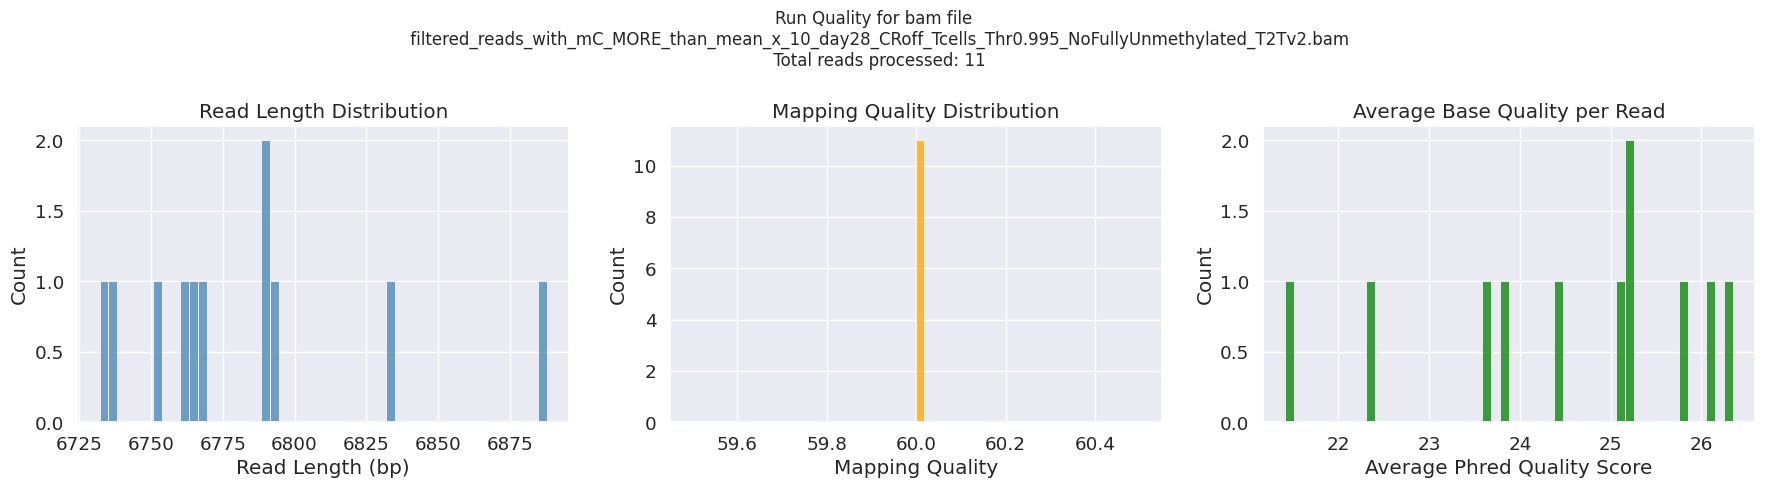

Total reads processed: 11


In [55]:
plot_bam_quality_metrics(filtered_output_bam_path)

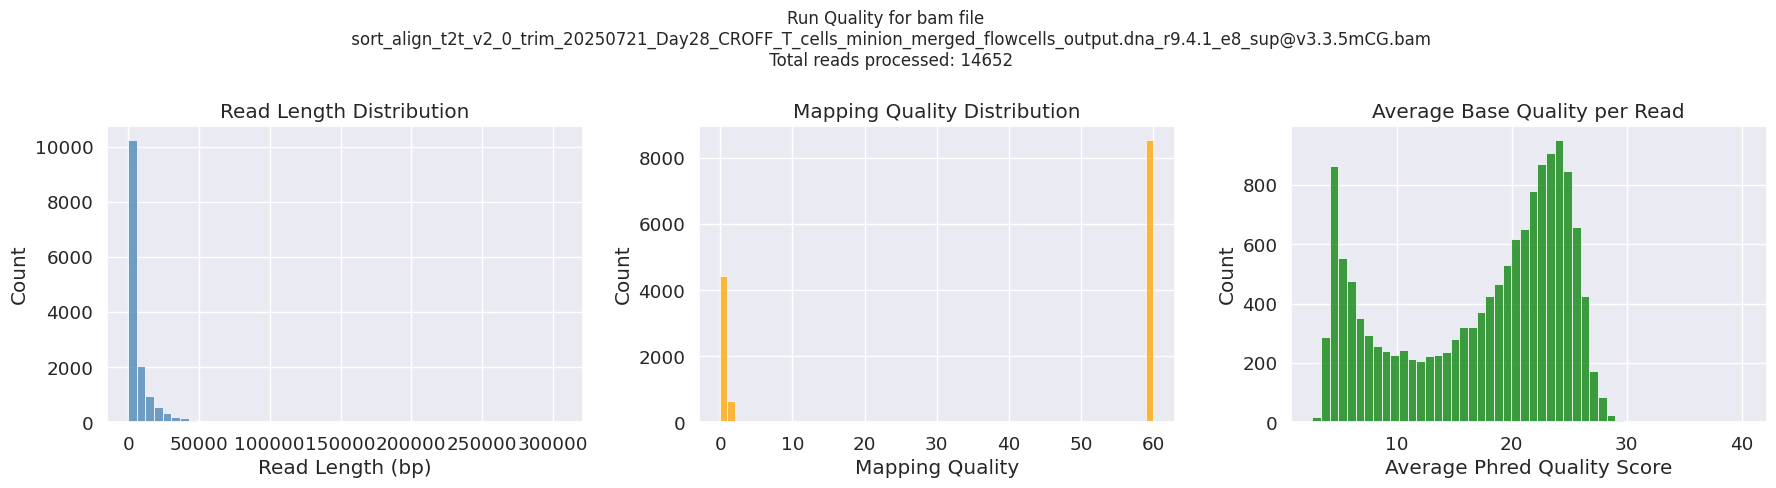

Total reads processed: 14652


In [56]:
plot_bam_quality_metrics(original_bam_path)

# Load BAM files

In [57]:
# removed_reads_bam_path= '/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/reads_with_mC_less_than_mean_x_50_day6_unedited_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam'
# removed_reads_bam_path
# plot_bam_quality_metrics(removed_reads_bam_path)

In [58]:
region_str

'chr1:206583354-206589854'

In [59]:
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams


bam = removed_output_bam_path # removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)

[E::hts_open_format] Failed to open file "/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/reads_with_mC_less_than_mean_x_10_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam" : No such file or directory


FileNotFoundError: [Errno 2] could not open alignment file `/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/reads_with_mC_less_than_mean_x_10_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam`: No such file or directory

In [ ]:


sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams

bam = filtered_output_bam_path  #  removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)



In [60]:
matrix

array([[ 7.,  7.,  7., ..., nan, nan, nan],
       [31., 31., 31., ..., 34., 30., 32.],
       [30., 29., 30., ..., 17., 17., 27.],
       ...,
       [nan, nan, nan, ..., 17., 18., 29.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(28, 6500))

In [61]:
meta

{'read_names': ['66e0b8f0-e20d-4fe8-b8fb-3755683e5167',
  '26691903-e686-4670-a760-ad70b0f87b42',
  'c758517d-05c4-4357-8457-6526c65c72a0',
  '035da8dd-fe81-463d-ab71-f3868112d62a',
  'ec0296e6-f5d3-4209-8ef5-c677a5a240aa',
  'a177f8ff-555a-47a7-98b3-235c69dcc230',
  '960b12aa-160c-4d90-abd7-9a6d03a6a225',
  '158c6df5-c59b-4d5b-ba66-9f7333f60628',
  '81d9c9a4-e181-4d1b-a08e-b079b8c2d493',
  '196a1a95-9ebc-406d-a20d-c370d3d00dd8',
  '2d177852-83a1-4015-bd0e-15c09376d3e1',
  'c6ce1a02-47c1-419a-8689-9b25c7b6597b',
  '4571a190-f277-49cb-abed-83630bf1e7d7',
  'cf3b0d9a-dbb4-4d70-99f3-a2da9be46bcc',
  '57b38588-021d-4039-bce7-6a1324d97628',
  'efa9e0e4-703e-4729-baa6-c006358484ed',
  '21336473-111b-4310-84dc-500452649158',
  '697a7a83-47dd-4e9e-b472-d668f05c4f37',
  'ddbbdd14-6486-42aa-8b5e-87a5713d18fa',
  'c9200e4e-e9b2-4970-bcf1-c61600f3cead',
  'aeae711b-9209-4a64-ba15-da27152587b9',
  '30258949-6bba-40d0-a628-978b9f04ae14',
  'e4c83f62-594c-41b5-937e-87290576382d',
  '9e90d97f-44fa-452

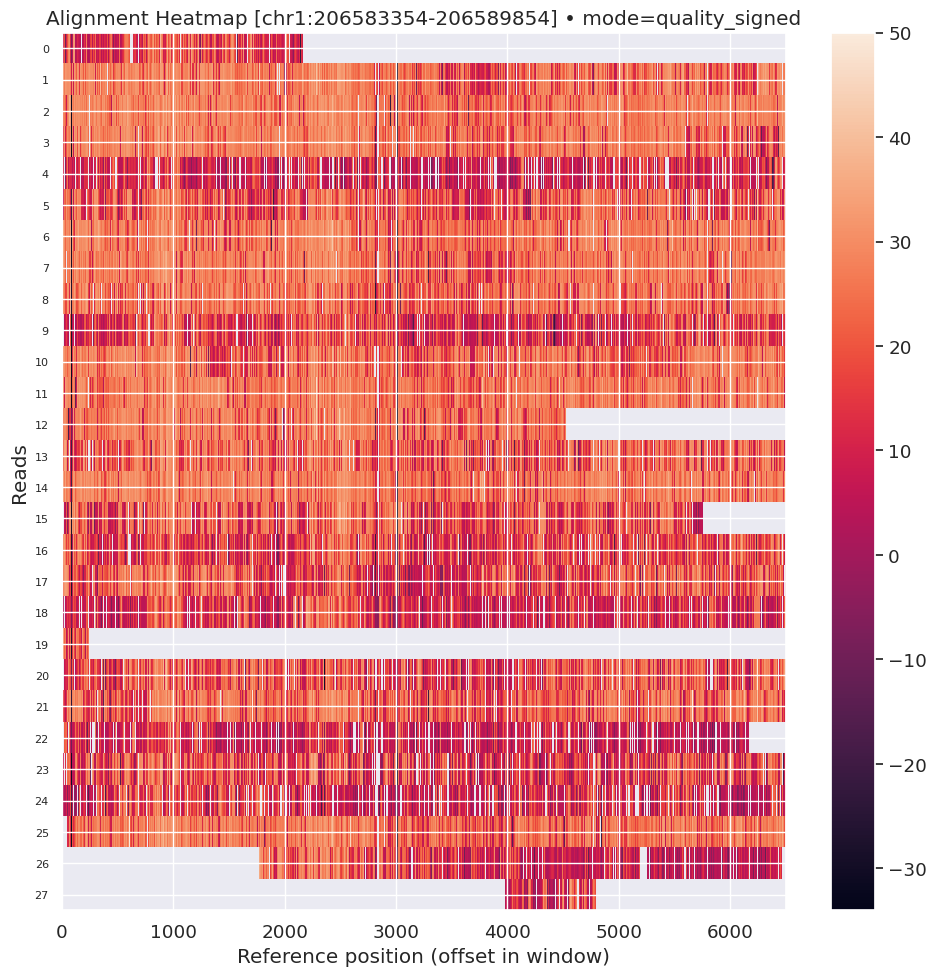

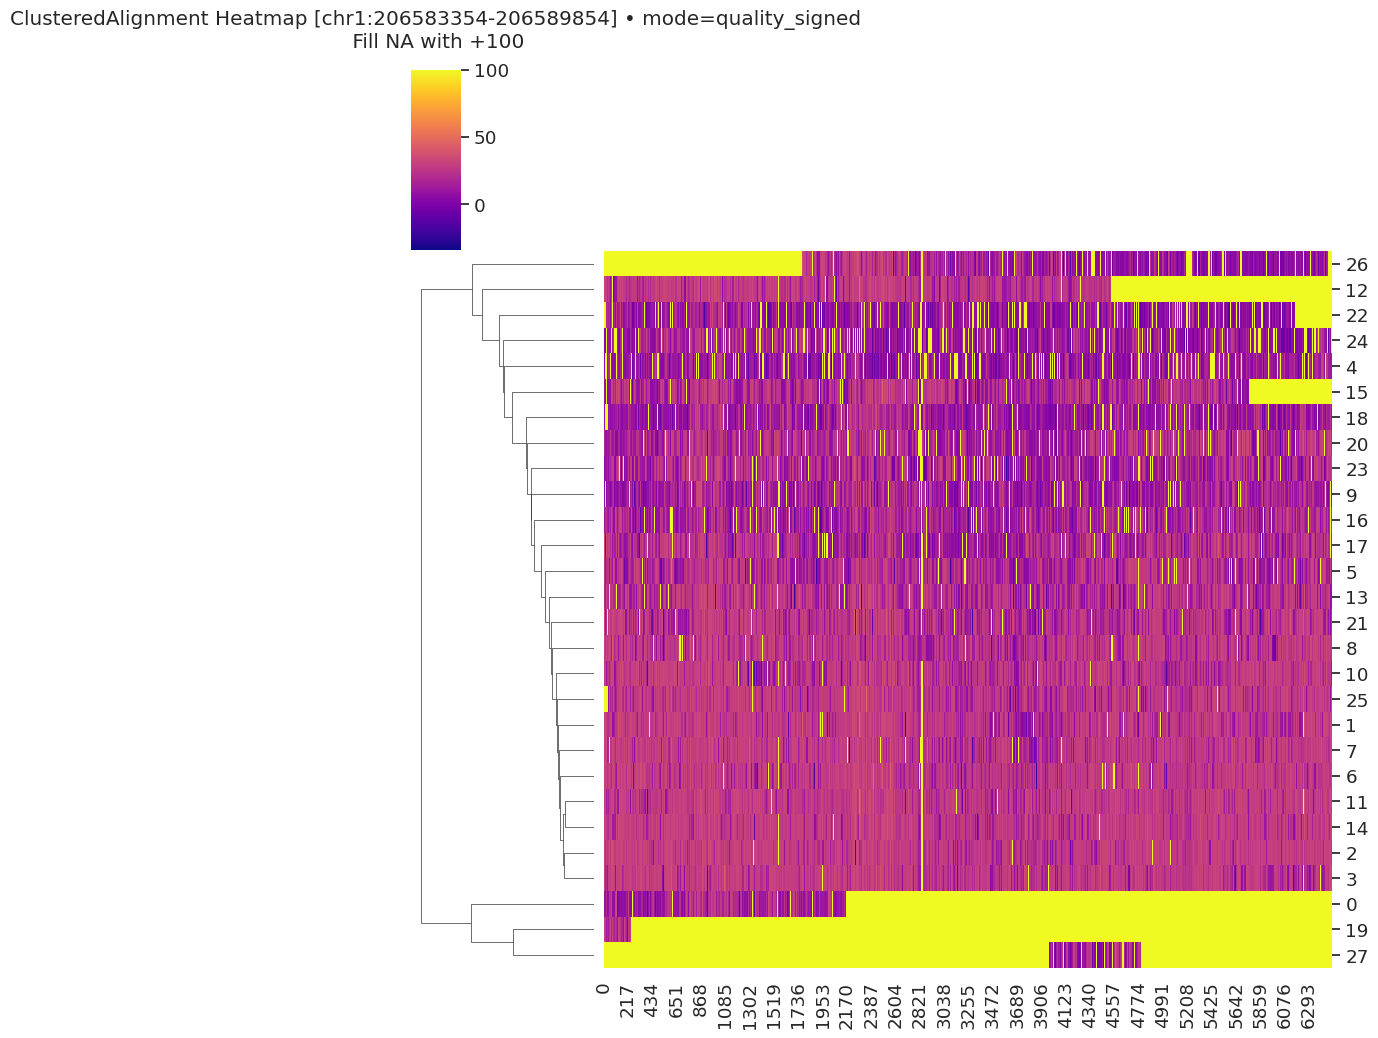

In [62]:
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams

bam = original_bam_path # unedit_bam_path # removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)


# Threshold 5%*mean(mC in alll reads)

In [63]:
threshold_percent = 5
filtered_reads_df, methylation_counts, remove_reads_df = remove_low_methylated_reads(reads_df, threshold_percent=threshold_percent)
filtered_reads_df

Mean methylated CGs per read: 33.0
Maximum methylated CGs per read: 74.0
Threshold (5% of max): 1.65
Original number of reads: 11
Number of reads after filtering: 11
Removed 0 reads


read_name_str read_name read_id_number   mod  \
0    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
1    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
2    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
3    26691903-e686-4670-a760-ad70b0f87b42         1              1  CG,0   
4    c758517d-05c4-4357-8457-6526c65c72a0         2              2  CG,0   
..                                    ...       ...            ...   ...   
451  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
452  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
453  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
454  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   
455  30258949-6bba-40d0-a628-978b9f04ae14        21             21  CG,0   

      pos  read_lengths  mapping_qualities  avg_base_qualities  \
0   -2897          6790                 60           24.387482   
1   -2500          6790                 60           24.387482   
2   -2332          6790                 60           24.387482   
3   -2193          6790                 60           24.387482   
4   -2897          6766                 60           26.344073   
..    ...           ...                ...                 ...   
451   921          6768                 60           22.379580   
452  1157          6768                 60           22.379580   
453  2304          6768                 60           22.379580   
454  2386          6768                 60           22.379580   
455  2554          6768                 60           22.379580   

     num_overlap_aligned_bases  fraction_overlap_aligned  num_nones  \
0                         6404                  0.985231        102   
1                         6404                  0.985231        102   
2                         6404                  0.985231        102   
3                         6404                  0.985231        102   
4                         6436                  0.990154         64   
..                         ...                       ...        ...   
451                       6352                  0.977231        151   
452                       6352                  0.977231        151   
453                       6352                  0.977231        151   
454                       6352                  0.977231        151   
455                       6352                  0.977231        151   

     fraction_nones  num_inserts  fraction_inserts  num_mismatches  \
0          0.015022          110          0.016200              48   
1          0.015022          110          0.016200              48   
2          0.015022          110          0.016200              48   
3          0.015022          110          0.016200              48   
4          0.009459           50          0.007390              30   
..              ...          ...               ...             ...   
451        0.022311          149          0.022015              86   
452        0.022311          149          0.022015              86   
453        0.022311          149          0.022015              86   
454        0.022311          149          0.022015              86   
455        0.022311          149          0.022015              86   

     fraction_mismatches  num_ambiguous  pos_shifted  num_CG_methylated  
0               0.007069              0          353                1.0  
1               0.007069              0          750                1.0  
2               0.007069              0          918                1.0  
3               0.007069              0         1057                1.0  
4               0.004434              0          353                1.0  
..                   ...            ...          ...                ...  
451             0.012707              0         4171                1.0  
452             0.012707            

In [64]:
remove_reads_df

Empty DataFrame
Columns: [read_name_str, read_name, read_id_number, mod, pos, read_lengths, mapping_qualities, avg_base_qualities, num_overlap_aligned_bases, fraction_overlap_aligned, num_nones, fraction_nones, num_inserts, fraction_inserts, num_mismatches, fraction_mismatches, num_ambiguous, pos_shifted, num_CG_methylated]
Index: []

In [65]:
bam_path

'/home/michalula/data/cas9_nanopore/data/20250721_nCATs_Tcells_CROFF_Day28/mergered_outputs/5mCG/to_t2t_v2_0/sort_align_t2t_v2_0_trim_20250721_Day28_CROFF_T_cells_minion_merged_flowcells_output.dna_r9.4.1_e8_sup@v3.3.5mCG.bam'

In [66]:
!pwd

/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads


In [67]:
# output_dir_path = '/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_6/unedited/analyze_single_reads/' # "/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/"
removed_reads_bam_name = "reads_with_mC_less_than_mean_x_" +  str(threshold_percent) + "_" + experiment_name +".bam"
removed_output_bam_path=Path(output_dir_path, removed_reads_bam_name)
removed_output_bam_path

PosixPath('/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/reads_with_mC_less_than_mean_x_5_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam')

In [68]:
subset_BAM_by_read_IDs(original_bam_path, remove_reads_df, output_bam_path=removed_output_bam_path, index_output=True)


ValueError: remove_mCG_reads_df has no read names to subset.

# Save filtered reads to BAM

In [69]:
# output_dir_path = "/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/outputs"
removed_reads_bam_name = "filtered_reads_with_mC_MORE_than_mean_x_" +  str(threshold_percent) + "_" + experiment_name +".bam"
filtered_output_bam_path=Path(output_dir_path, removed_reads_bam_name)
filtered_output_bam_path

PosixPath('/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_5_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam')

In [70]:
subset_BAM_by_read_IDs(original_bam_path, filtered_reads_df, output_bam_path=filtered_output_bam_path, index_output=True)


Subset BAM written to: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_5_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam
Index written to: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_5_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam.bai


PosixPath('/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_5_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam')

In [71]:
sam_path = bam_to_sam(filtered_output_bam_path, sam_path=None)
sam_path

Converted BAM → SAM: /home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_5_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.sam


PosixPath('/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/filtered_reads_with_mC_MORE_than_mean_x_5_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.sam')

In [72]:
# sam_path = bam_to_sam(removed_output_bam_path, sam_path=None)
# sam_path
# removed_reads_bam_path = '/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/reads_with_mC_less_than_mean_x_50_day6_unedited_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam'
# removed_reads_bam_path
# plot_bam_quality_metrics(removed_reads_bam_path)

In [73]:

plot_bam_quality_metrics(removed_output_bam_path)

[E::hts_open_format] Failed to open file "/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/reads_with_mC_less_than_mean_x_5_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam" : No such file or directory


FileNotFoundError: [Errno 2] could not open alignment file `/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/reads_with_mC_less_than_mean_x_5_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam`: No such file or directory

In [ ]:
plot_bam_quality_metrics(filtered_output_bam_path)

In [ ]:
plot_bam_quality_metrics(original_bam_path)

# Load BAM files

In [ ]:
# removed_reads_bam_path= '/home/michalula/code/epiCausality/epiCode/utils/development_notebooks/reads_with_mC_less_than_mean_x_50_day6_unedited_Tcells_Thr0.7_NoFullyUnmethylated_T2Tv2.bam'
# removed_reads_bam_path
# plot_bam_quality_metrics(removed_reads_bam_path)

In [74]:
region_str

'chr1:206583354-206589854'

In [75]:
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams


bam = removed_output_bam_path # removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)

[E::hts_open_format] Failed to open file "/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/reads_with_mC_less_than_mean_x_5_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam" : No such file or directory


FileNotFoundError: [Errno 2] could not open alignment file `/home/michalula/code/epiCausality/epiCode/analyze_ont_data/T2T_v2.0_mapped/T_cells/day_28/croff/analyze_single_reads/output/reads_with_mC_less_than_mean_x_5_day28_CRoff_Tcells_Thr0.995_NoFullyUnmethylated_T2Tv2.bam`: No such file or directory

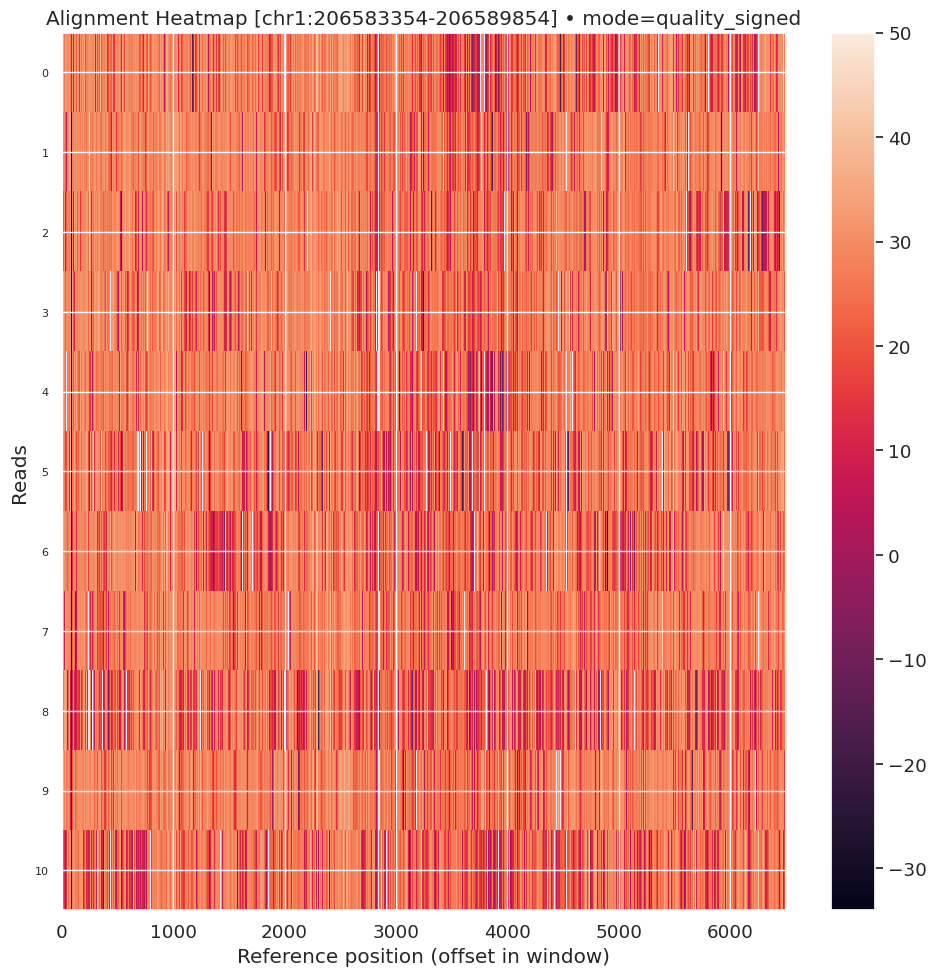

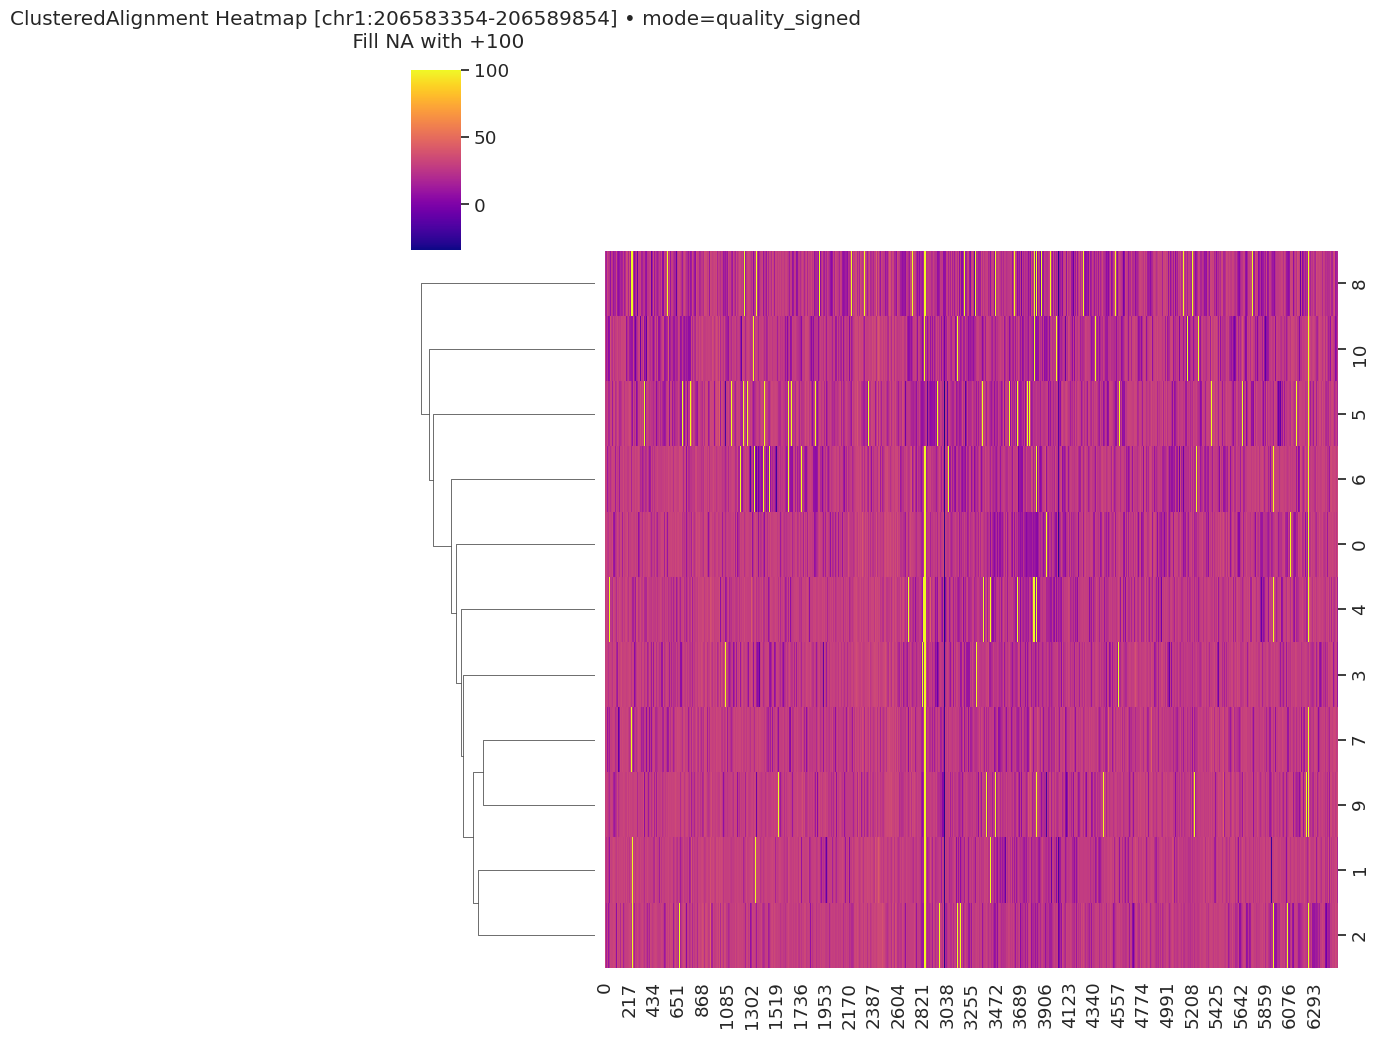

In [76]:


sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams

bam = filtered_output_bam_path  #  removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)



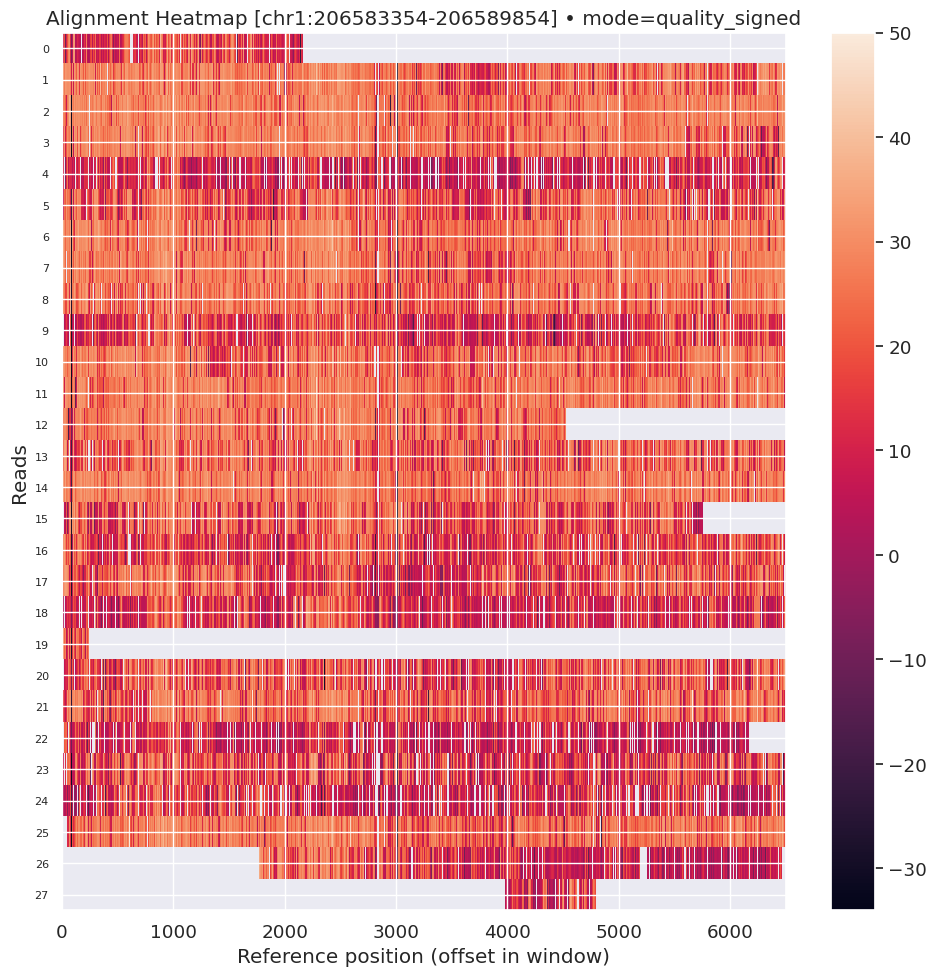

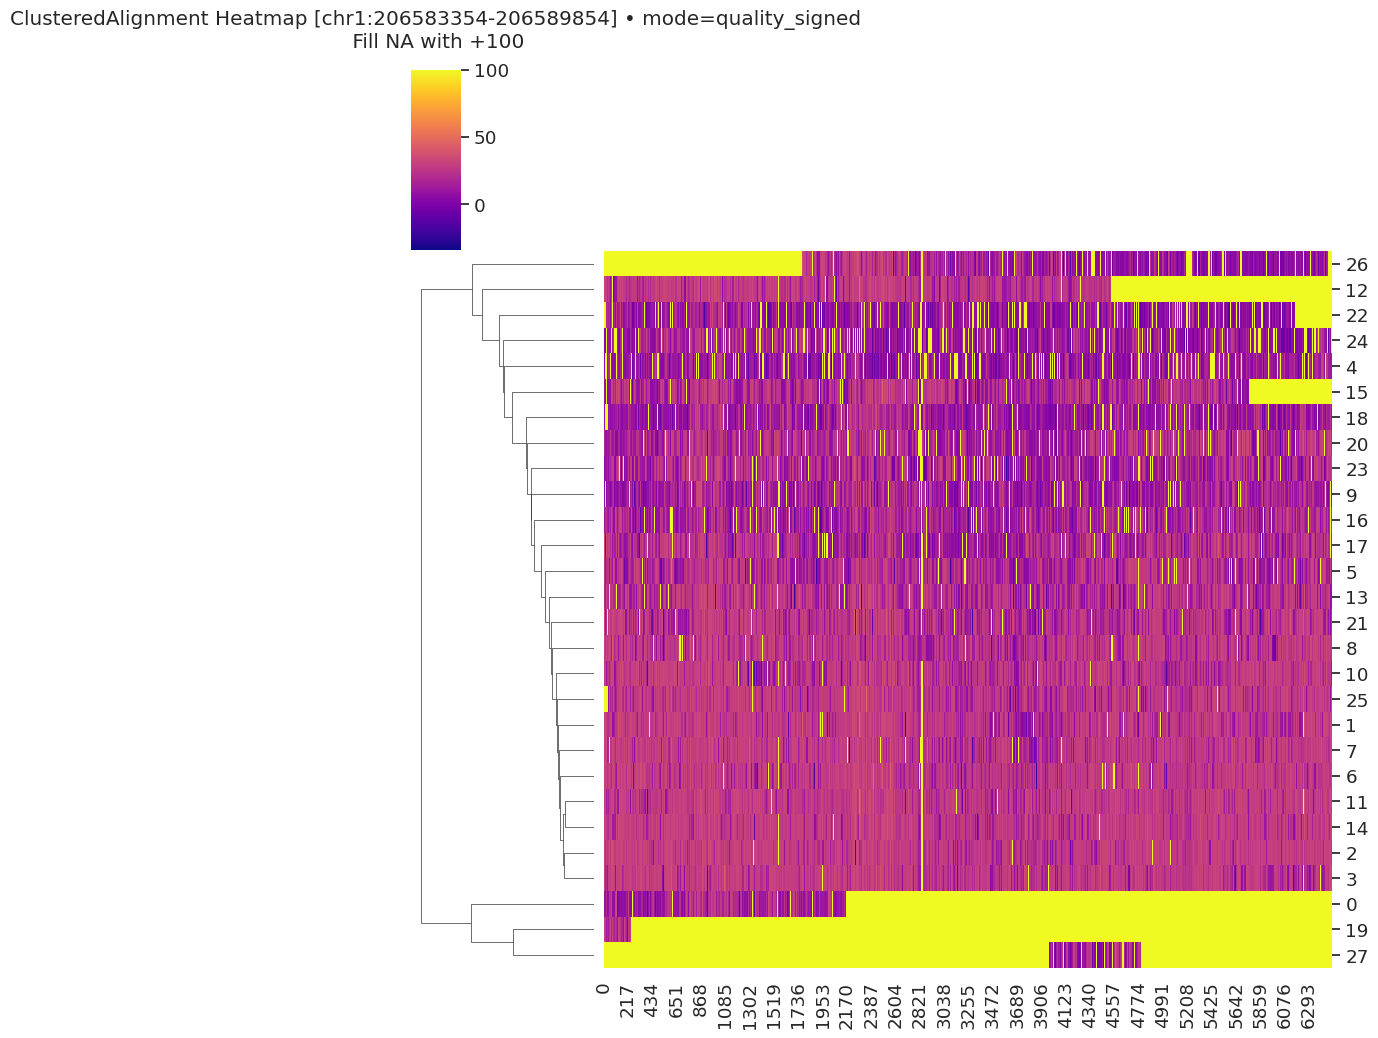

In [77]:
sys.path.append("/home/michalula/code/epiCausality/epiCode/utils/") # str(Path(__file__).parent / 'utils'))
import funcs_check_quality_bams

bam = original_bam_path # removed_reads_bam_path # "/path/to/your.bam"
ref_genome_path = Path('/home/michalula/data/ref_genomes/t2t_v2_0/up_chm13v2.0.fasta') # ref = "/path/to/reference.fa"  # must have .fai index

# region = "chr1:206586100-206586220"  # keep windows reasonably small

# Build matrix (limit to, say, 3000 reads to keep memory sane)
matrix, meta = funcs_check_quality_bams.build_alignment_heatmap(
    bam_path=bam,
    region=region_str, #region,
    reference_fasta=ref_genome_path,
    mode="quality_signed",   # try 'binary' for a simple match/mismatch view
    max_reads=3000,
    primary_only=True,
    min_mapq=0,
)

# Plot it
funcs_check_quality_bams.plot_alignment_heatmap(matrix, meta)

# (Optional) Save for later
np.save("alignment_heatmap.npy", matrix)
